# Nootebook d'essais de différents algorithmes de clustering et de features

Le travail effectué dans ce notebook vise à trouver le meilleur algorithme de clustering et les meilleures features sur lesquelles l'entrainer, afin d'obtenir un résultats exploitables par les équipes métier (marketing, ciblage de campagnes).

# Importation des données

In [59]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Import de librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

!pip install yellowbrick
from yellowbrick.cluster import (
    KElbowVisualizer,
    SilhouetteVisualizer,
    InterclusterDistance,
)

In [61]:
# Chargement du dataset
df = pd.read_csv('drive/MyDrive/POlist/df.csv')


In [62]:
# Fonction d'aggrégation du dataset par individu
def dataset_aggregate(df, start_date, end_date):
    """
    Agrège le DataFrame au customer entre les dates de commandes renseignées.
    Retourne l'id du customer et plusieurs variables agrègées.

    Args:
    - df: DataFrame à agrèger
    - start_date: filtre les commandes passées avant la date
    - end_date: filtre les commandes passées après la date

    Output: DataFrame agrègé au customer
    """

    # convertit les arguments en dates
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    # Filtre le dataset sur les dates
    df = df[
        (df["order_purchase_timestamp"] >= start_date)
        & (df["order_purchase_timestamp"] <= end_date)
    ]

    # Calcul des features agrègées
    df_agg = df.groupby(["customer_unique_id"], as_index=False, sort=False).agg(
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        number_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_amount=pd.NamedAgg(column="payment_value", aggfunc="sum"),
        average_cart=pd.NamedAgg(column="payment_value", aggfunc="mean"),
        average_price=pd.NamedAgg(column="price", aggfunc="mean"),
        average_qty=pd.NamedAgg(column="order_item_id", aggfunc="mean"),
        average_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        number_reviews=pd.NamedAgg(column="review_comment_message", aggfunc="count"),
        average_payment_sequential=pd.NamedAgg(
            column="payment_sequential", aggfunc="mean"
        ),
        average_payment_installments=pd.NamedAgg(
            column="payment_installments", aggfunc="mean"
        ),
        average_freight_value=pd.NamedAgg(column="freight_value", aggfunc="mean"),
        average_product_weight_g=pd.NamedAgg(column="product_weight_g", aggfunc="mean"),
        average_product_length_cm=pd.NamedAgg(
            column="product_length_cm", aggfunc="mean"
        ),
        average_product_height_cm=pd.NamedAgg(
            column="product_height_cm", aggfunc="mean"
        ),
        average_product_width_cm=pd.NamedAgg(column="product_width_cm", aggfunc="mean"),
        average_distance=pd.NamedAgg(column="distance_km", aggfunc="mean"),
        customer_state=pd.NamedAgg(
            column="customer_state",
            aggfunc=lambda x: np.nan if x.isnull().all() else x.value_counts().index[0],
        ),
        order_different_state=pd.NamedAgg(
            column="order_different_state",
            aggfunc=lambda x: "yes" if x.sum() > 0 else "no",
        ),
        first_payment_type=pd.NamedAgg(
            column="payment_type",
            aggfunc=lambda x: np.nan if x.isnull().all() else x.value_counts().index[0],
        ),
        first_product_category=pd.NamedAgg(
            column="product_category_name_english",
            aggfunc=lambda x: np.nan if x.isnull().all() else x.value_counts().index[0],
        ),
        average_product_name_lenght=pd.NamedAgg(
            column="product_name_lenght", aggfunc="mean"
        ),
        average_product_description_lenght=pd.NamedAgg(
            column="product_description_lenght", aggfunc="mean"
        ),
        average_review_lenght=pd.NamedAgg(
            column="review_comment_message", aggfunc=lambda x: np.mean(x.str.len())
        ),
        average_product_photos_qty=pd.NamedAgg(
            column="product_photos_qty", aggfunc="mean"
        ),
    )

    # Nombre de jours depuis la dernière commande
    df_agg["days_since_last_order"] = end_date - df_agg["last_order"]
    df_agg["days_since_last_order"] = pd.to_numeric(
        df_agg["days_since_last_order"].dt.days, downcast="integer"
    )

    # Taux de review
    df_agg["review_rate"] = df_agg["number_reviews"] / df_agg["number_orders"]

    return df_agg

In [63]:
import datetime

# Gestion des dates

# colonnes comportant des dates
cols_date = ['order_purchase_timestamp',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date',
             'review_creation_date',
             'review_answer_timestamp',
             'shipping_limit_date']

# convert au bon Dtype et arrondi à la journée
for col in cols_date:
    df[col] = pd.to_datetime(df[col])
    df[col] = df[col].dt.round("D")


On exclu les commandes de 2016, qui ont été effectuées avant le gros du reste des commandes dans un laps de temps très court. 
Ne connaissant pas avec certitude pourquoi ces commandes sont séparées temporellement des autres (fausses commandes de test? beta fermée du site?), je choisi de les ignorer et de les retirer du dataset d'entrainement et d'évaluation car elles risquent d'impacter le clustering.

In [64]:
# date de début du dataset
start = '01-01-2017'

# date de fin
end = '01-01-2020'

# aggrégation à l'individu
df_agg = dataset_aggregate(df, start, end)
df_agg

,customer_unique_id,last_order,first_order,number_orders,total_amount,average_cart,average_price,average_qty,average_review_score,number_reviews,...,customer_state,order_different_state,first_payment_type,first_product_category,average_product_name_lenght,average_product_description_lenght,average_review_lenght,average_product_photos_qty,days_since_last_order,review_rate
0,397c24b06740a0578e1e4ef14ab7dc4e,2018-04-13,2018-04-13,1,46.96,46.96,24.90,1.0,5.0,1,...,MS,yes,credit_card,sports_leisure,52.0,1392.0,48.0,1.0,628,1.0
1,3cde4b009a25beebc485cf2059ddc991,2018-03-17,2018-03-17,1,38.13,38.13,19.90,1.0,3.0,0,...,MS,yes,boleto,bed_bath_table,52.0,153.0,NaN,1.0,655,0.0
2,469356420bccdecae3c5a3f9d8089ddd,2018-02-13,2018-02-13,1,76.17,76.17,59.99,1.0,4.0,0,...,MS,yes,credit_card,bed_bath_table,57.0,504.0,NaN,1.0,687,0.0
3,a2353d74607f052ae9640d3af3b81132,2018-02-26,2018-02-26,1,387.14,387.14,369.80,1.0,4.0,0,...,MS,yes,credit_card,watches_gifts,50.0,464.0,NaN,2.0,674,0.0
4,99f0c33abddbeb5b72869e0e505453a9,2017-11-25,2017-11-25,1,24.30,24.30,9.20,1.0,5.0,1,...,MS,yes,boleto,auto,60.0,324.0,21.0,1.0,767,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90761,31e412b9fb766b6794724ed17a41dfa6,2017-12-14,2017-12-14,1,1014.02,1014.02,59.00,14.0,1.0,0,...,SP,no,boleto,garden_tools,56.0,348.0,NaN,2.0,748,0.0
90762,f7ea4eef770a388bd5b225acfc546604,2018-02-21,2018-02-21,1,528.78,528.78,29.99,14.0,1.0,1,...,SP,no,credit_card,telephony,55.0,55.0,75.0,1.0,679,1.0
90763,11f97da02237a49c8e783dfda6f50e8e,2017-01-31,2017-01-31,1,783.00,783.00,51.00,15.0,5.0,0,...,GO,yes,credit_card,garden_tools,43.0,369.0,NaN,2.0,1065,0.0
90764,c402f431464c72e27330a67f7b94d4fb,2018-02-23,2018-02-23,1,2202.40,2202.40,100.00,20.0,1.0,0,...,SP,no,boleto,computers_accessories,43.0,452.0,NaN,1.0,677,0.0


# RFM + reviews

## KMeans

Le code utilisé ici vient de la documentation officielle de la librairie Yellowbrick (dont le but est de faciliter l'évaluation des modèles):

Lien vers la documentation:

https://www.scikit-yb.org/en/latest/api/cluster/index.html

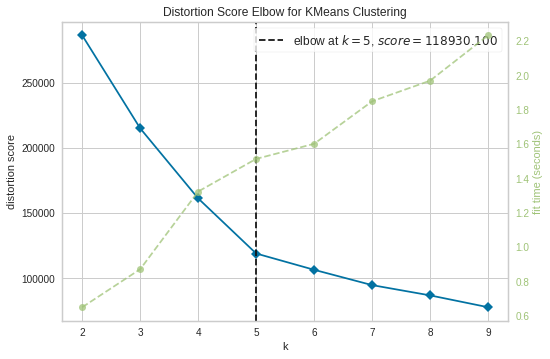

In [65]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data


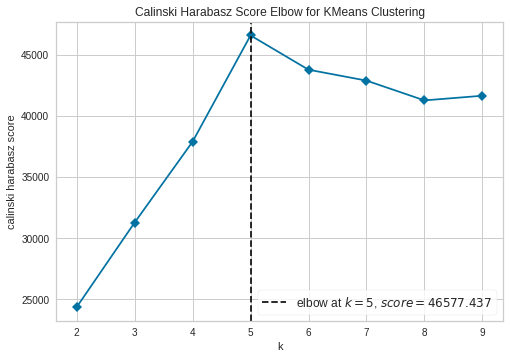

In [66]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    model, k=(2, 10), metric="calinski_harabasz", timings=False
)

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data


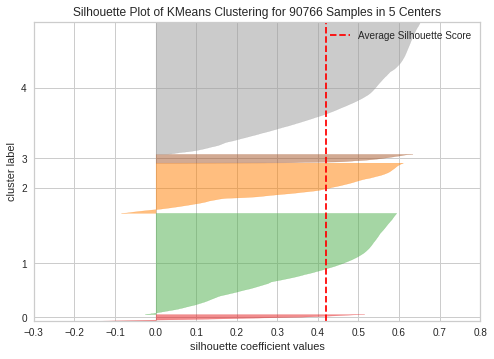

In [67]:
# Instantiate the clustering model and visualizer
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data


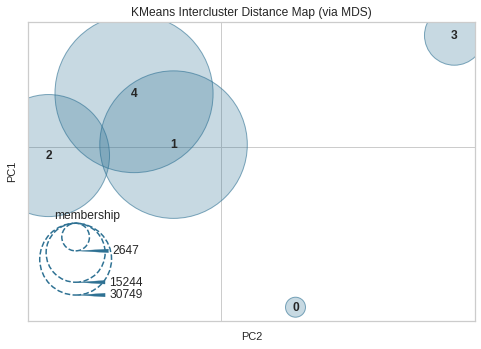

In [68]:
# Inter cluster distance map


# Instantiate the clustering model and visualizer
model = KMeans(5, random_state=42)
visualizer = InterclusterDistance(model)

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure


### EDA des clusters

In [69]:
# Modèle KMeans dont on explore les clusters
kmeans = KMeans(5, random_state=42)

# fit du modèle
kmeans.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)

# Obtention des clusters
clusters_kmeans = kmeans.fit_predict(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)

# DataFrame avec une colonne indiquant le cluster d'appartenance
df_w_clusters = df_agg.copy()
df_w_clusters["cluster_kmeans"] = clusters_kmeans

# Check
df_w_clusters.head()


,customer_unique_id,last_order,first_order,number_orders,total_amount,average_cart,average_price,average_qty,average_review_score,number_reviews,...,order_different_state,first_payment_type,first_product_category,average_product_name_lenght,average_product_description_lenght,average_review_lenght,average_product_photos_qty,days_since_last_order,review_rate,cluster_kmeans
0,397c24b06740a0578e1e4ef14ab7dc4e,2018-04-13,2018-04-13,1,46.96,46.96,24.90,1.0,5.0,1,...,yes,credit_card,sports_leisure,52.0,1392.0,48.0,1.0,628,1.0,4
1,3cde4b009a25beebc485cf2059ddc991,2018-03-17,2018-03-17,1,38.13,38.13,19.90,1.0,3.0,0,...,yes,boleto,bed_bath_table,52.0,153.0,NaN,1.0,655,0.0,2
2,469356420bccdecae3c5a3f9d8089ddd,2018-02-13,2018-02-13,1,76.17,76.17,59.99,1.0,4.0,0,...,yes,credit_card,bed_bath_table,57.0,504.0,NaN,1.0,687,0.0,4
3,a2353d74607f052ae9640d3af3b81132,2018-02-26,2018-02-26,1,387.14,387.14,369.80,1.0,4.0,0,...,yes,credit_card,watches_gifts,50.0,464.0,NaN,2.0,674,0.0,4
4,99f0c33abddbeb5b72869e0e505453a9,2017-11-25,2017-11-25,1,24.30,24.30,9.20,1.0,5.0,1,...,yes,boleto,auto,60.0,324.0,21.0,1.0,767,1.0,1


In [70]:
# nombre d'individus par cluster
df_w_clusters['cluster_kmeans'].value_counts()

4    40106
1    30749
2    15244
3     2647
0     2020
Name: cluster_kmeans, dtype: int64

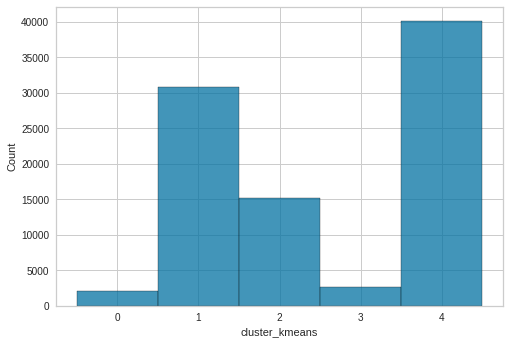

In [71]:
# histogramme du nombre d'individus par cluster
sns.histplot(data=df_w_clusters, x="cluster_kmeans", discrete=True)

In [72]:
# Variables à explorer
cat_var = ['customer_state', 
           'order_different_state', 
           'first_payment_type',
           'first_product_category']

quant_var = ['number_orders',
             'days_since_last_order',
             'total_amount',
             'average_review_score',
             'average_distance',
             'average_payment_installments',
             'average_cart',
             'average_price',
             'average_qty',
             'number_reviews',
             'average_payment_sequential',
             'average_freight_value',
             'average_product_weight_g',
             'average_product_name_lenght',
             'average_product_description_lenght',
             'average_review_lenght',
             'average_product_photos_qty',
             'review_rate']

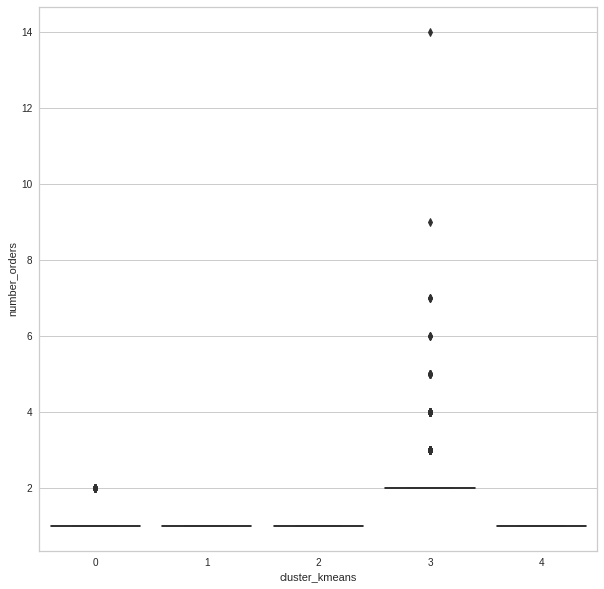

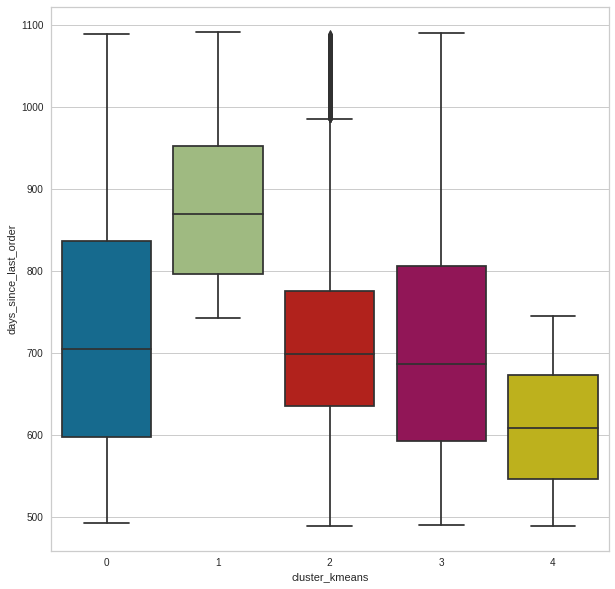

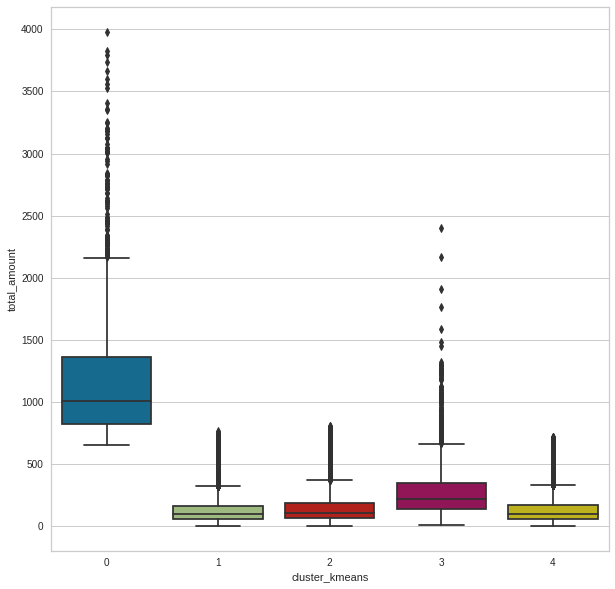

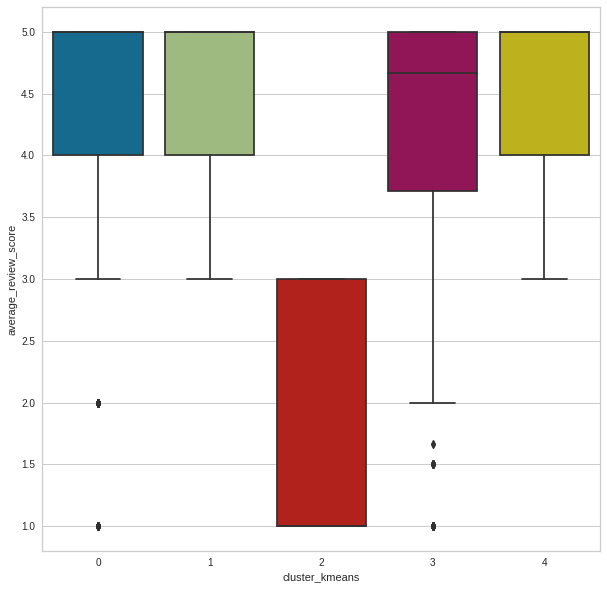

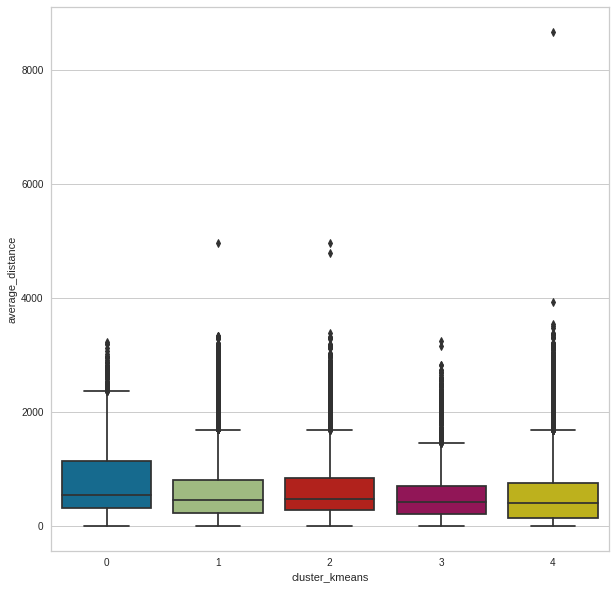

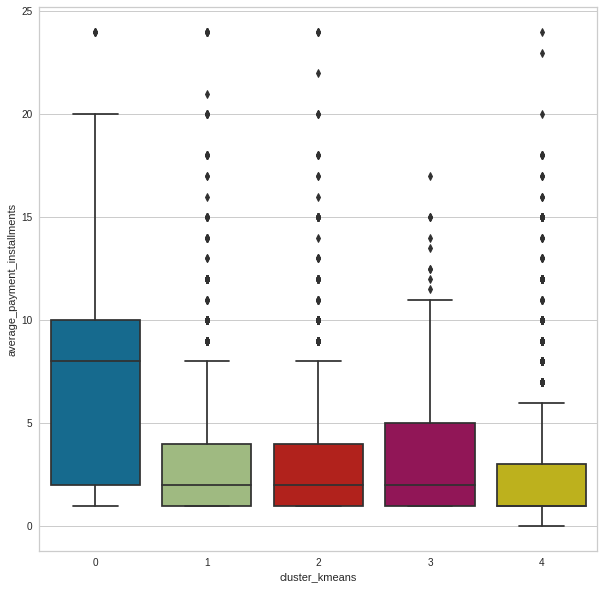

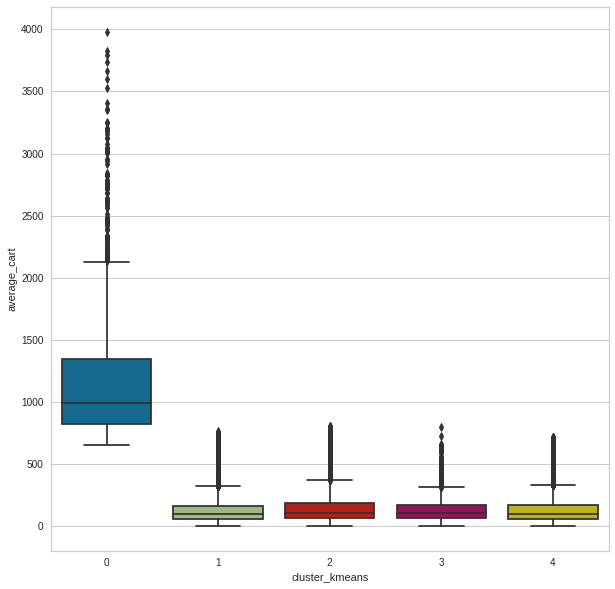

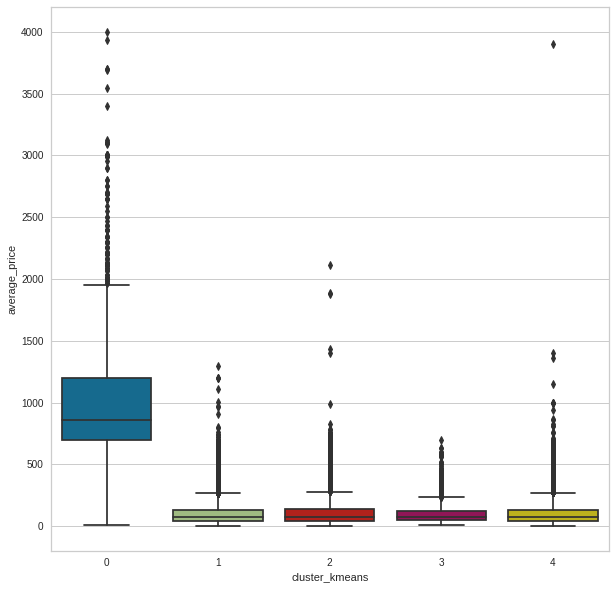

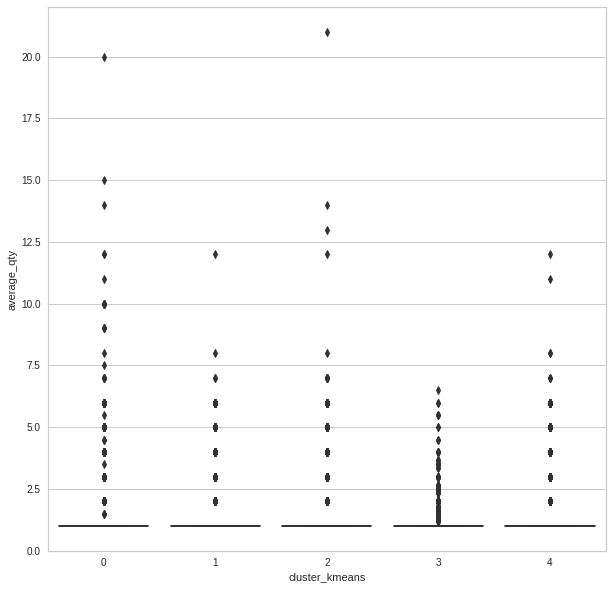

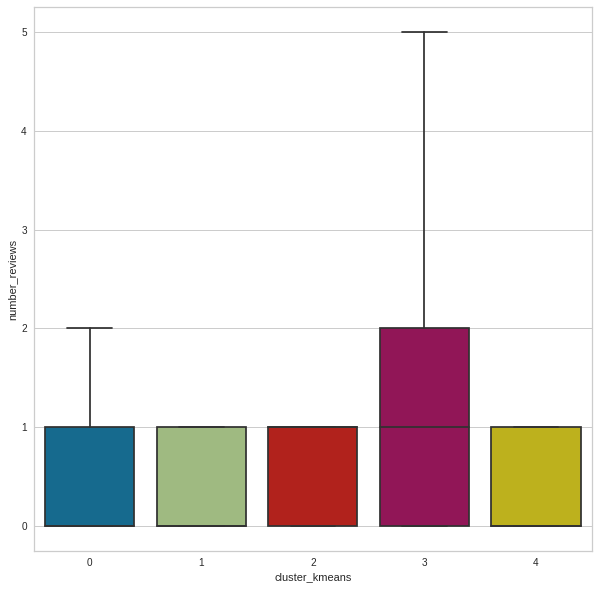

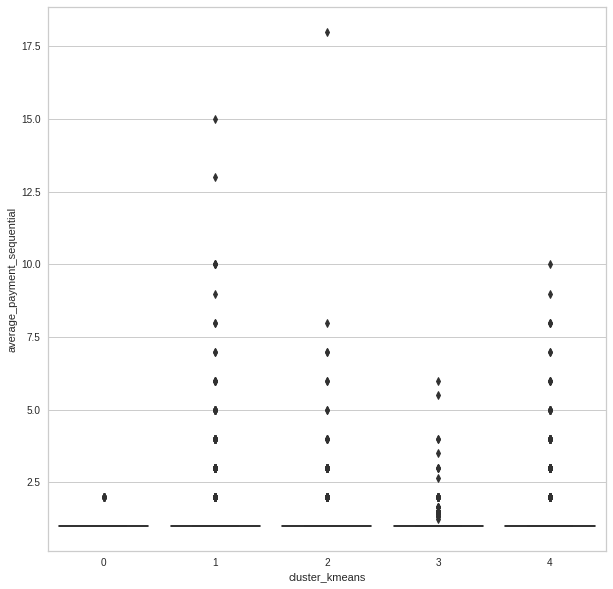

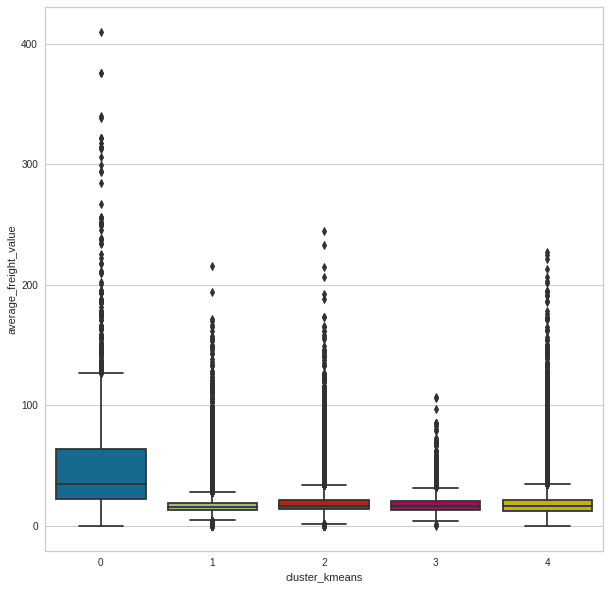

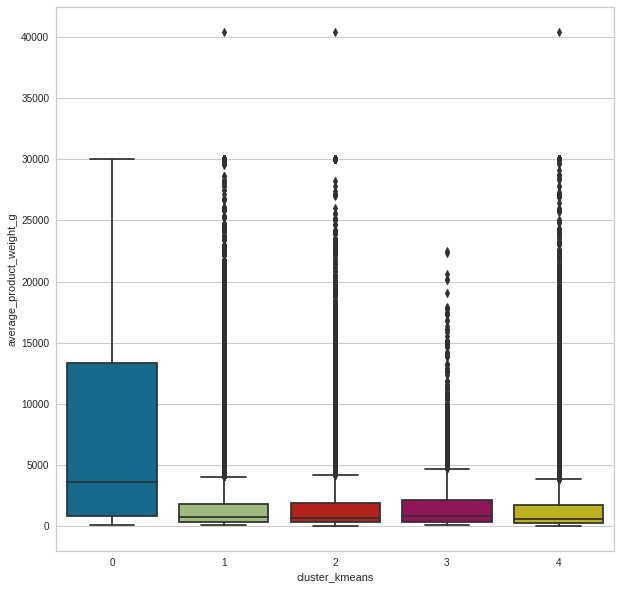

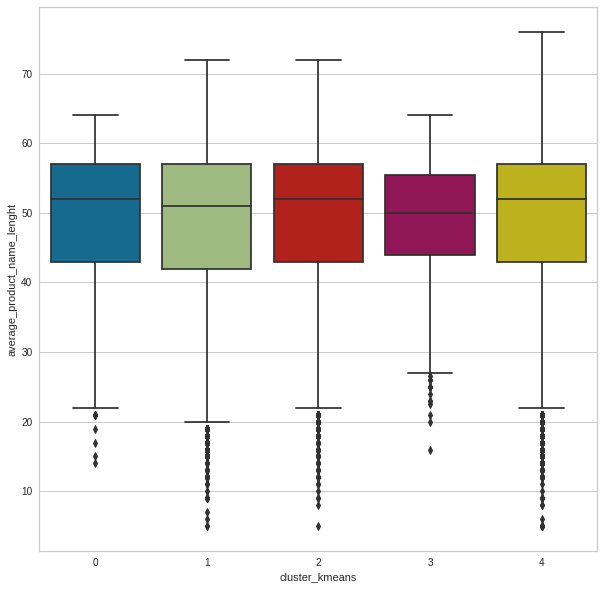

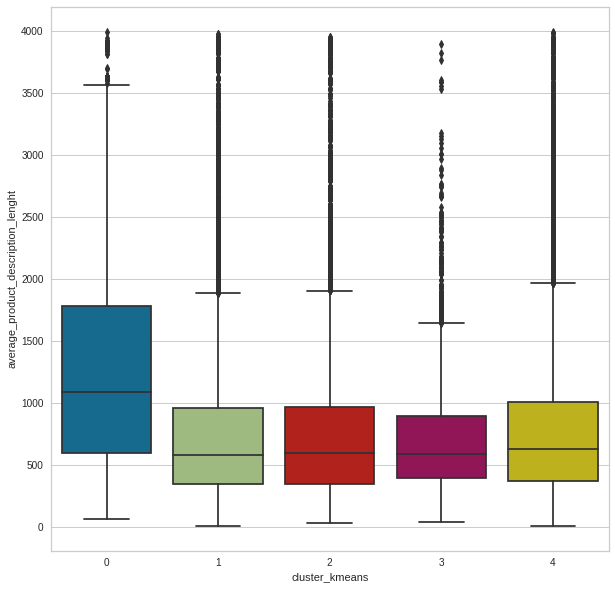

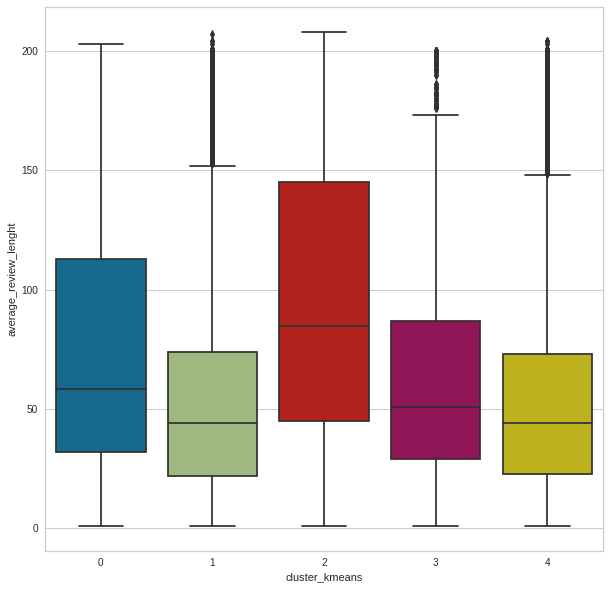

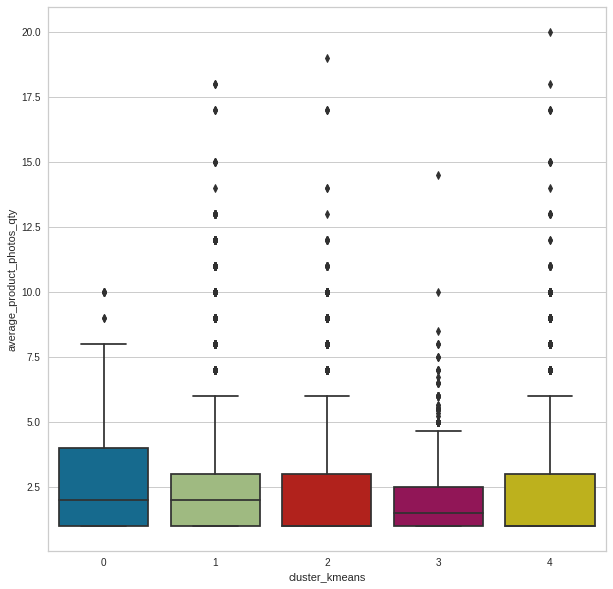

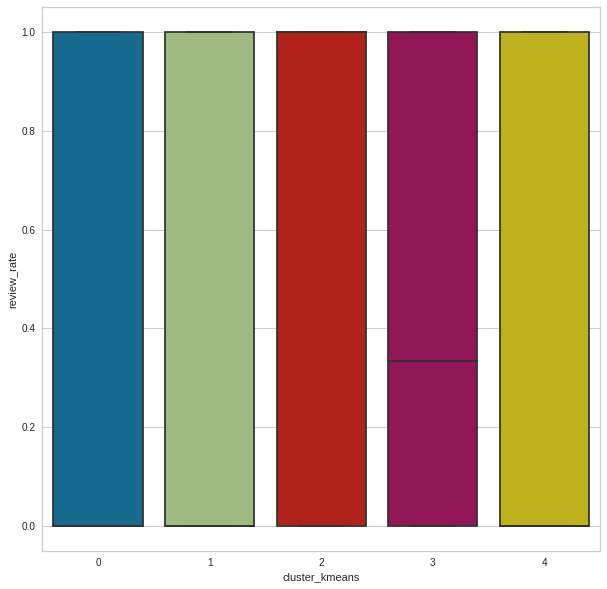

In [73]:
# Boxplots des variables par cluster
for i in quant_var:
    plt.figure(figsize=(10, 10))
    sns.boxplot(
        data=df_w_clusters[df_w_clusters["total_amount"] < 4000],
        x="cluster_kmeans",
        y=i,
    )
    plt.show()


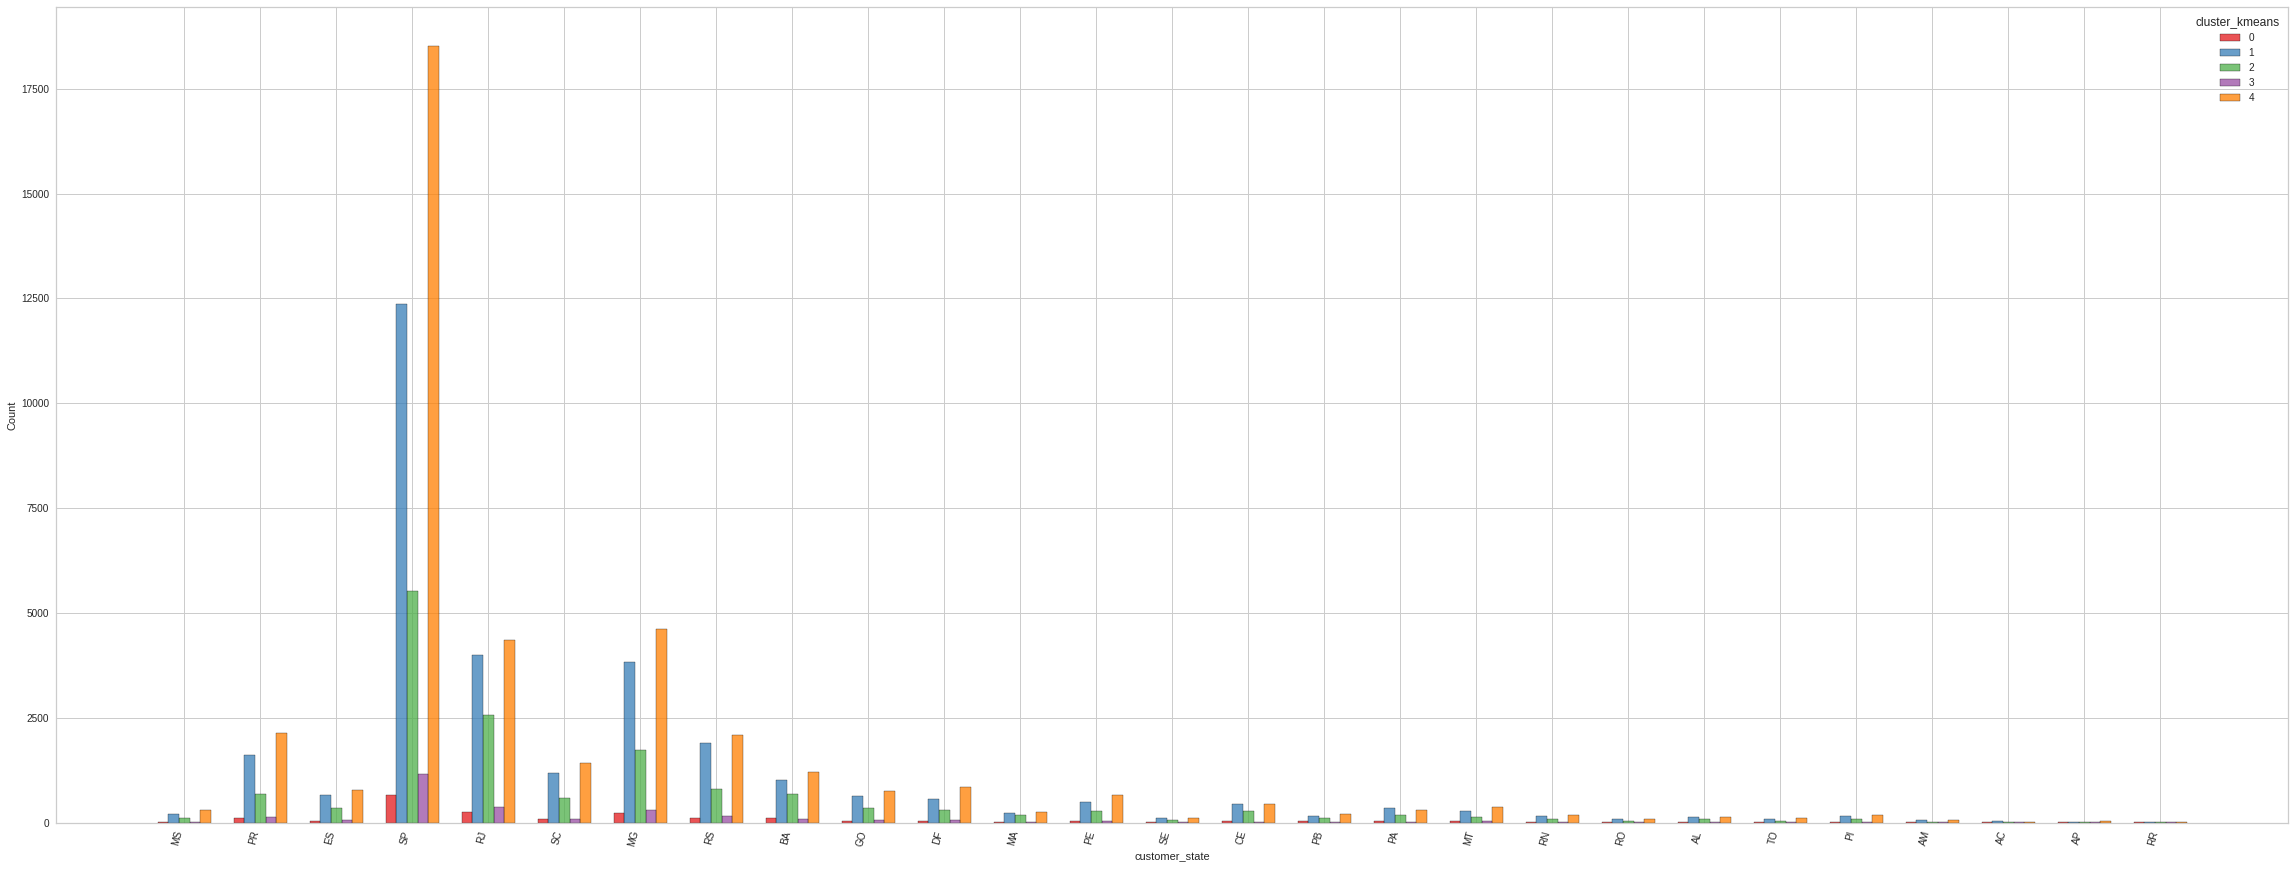

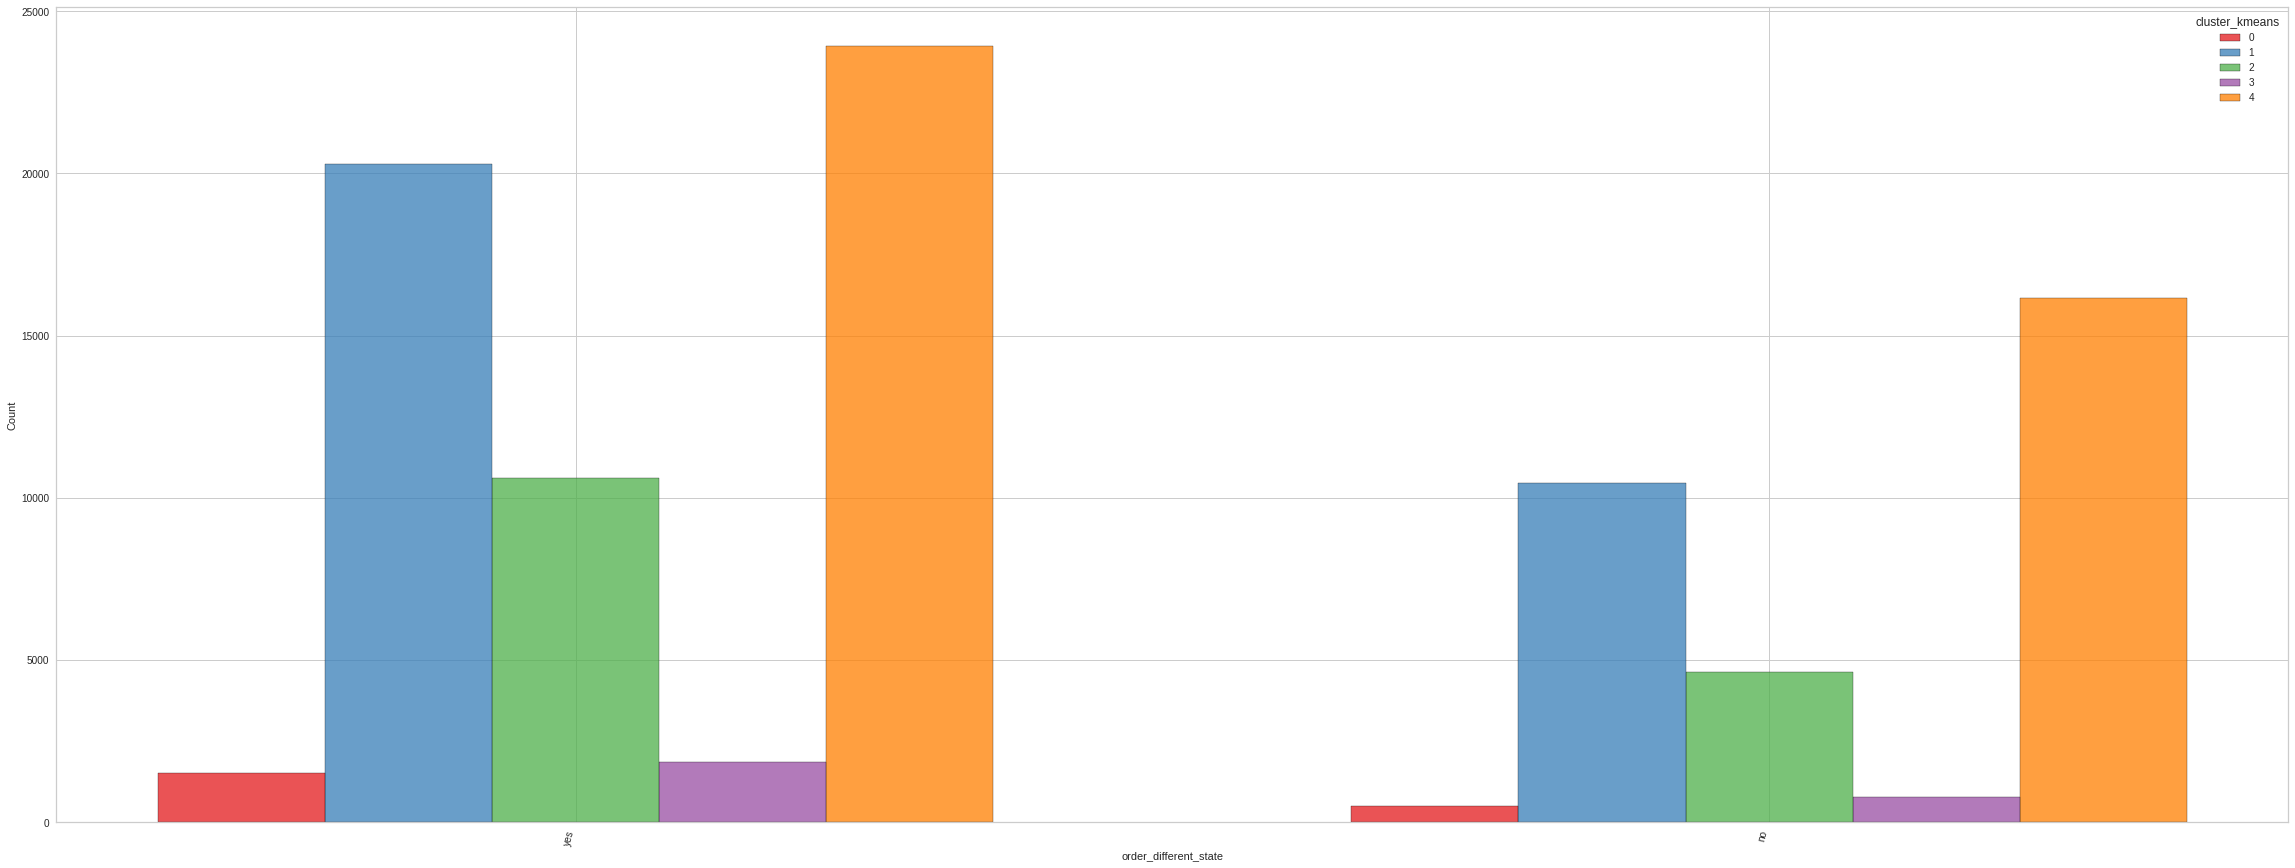

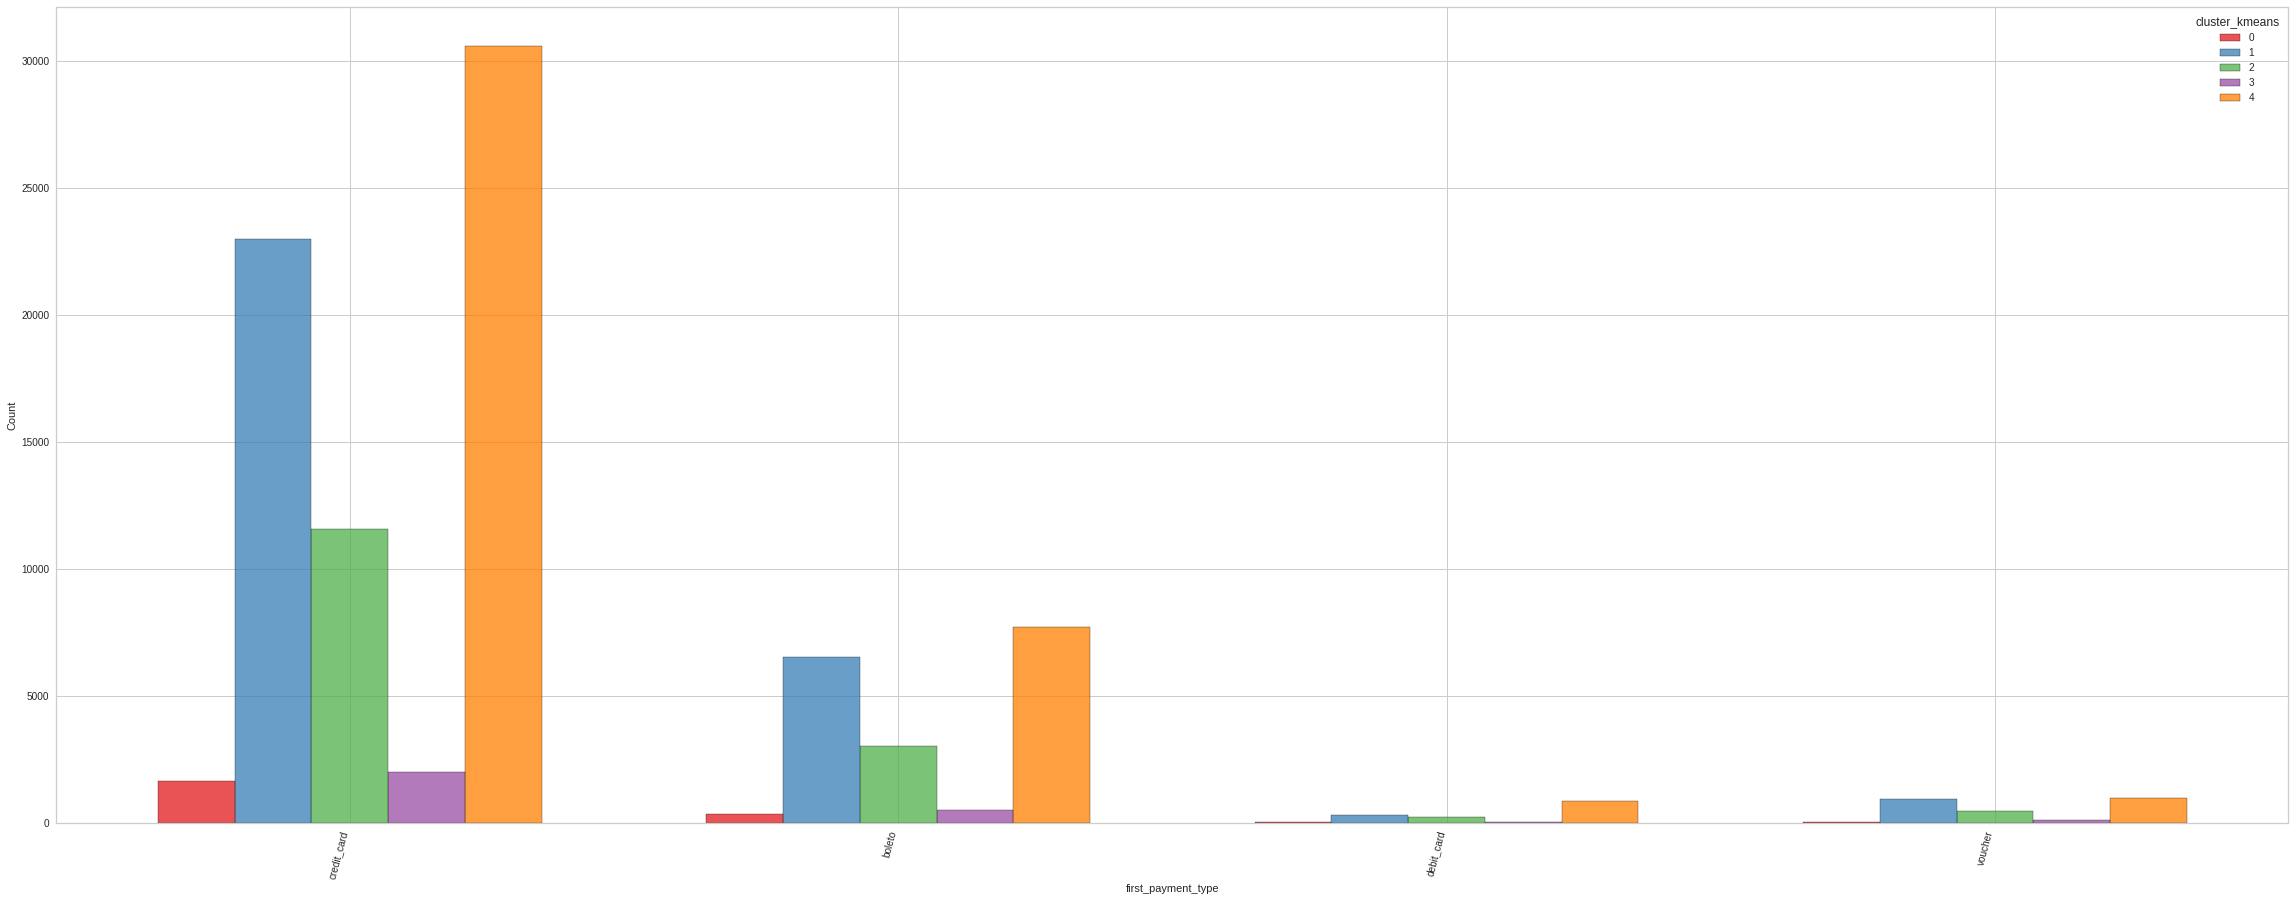

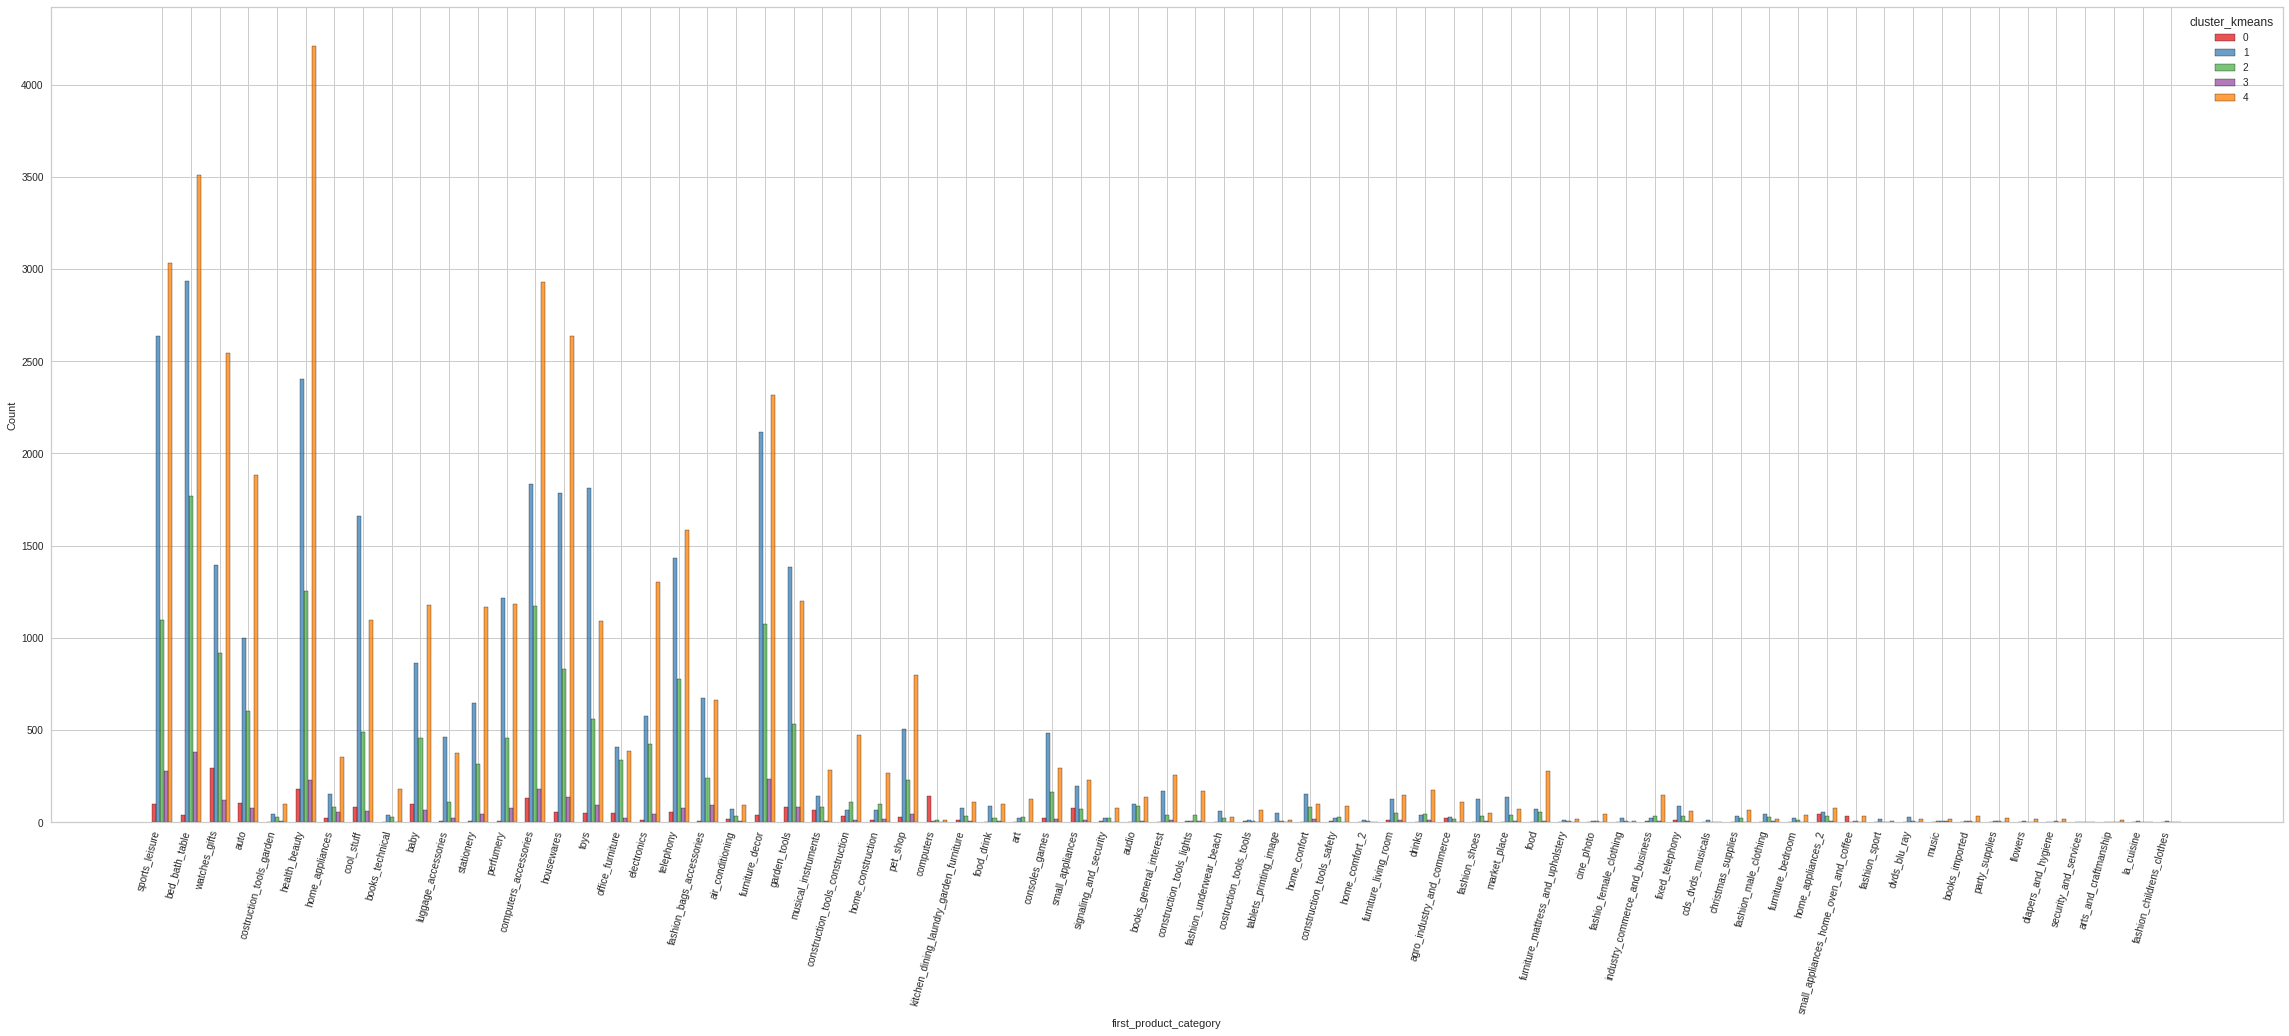

In [16]:
# Boxplots des variables par cluster
for i in cat_var:
    plt.figure(figsize=(40, 15))
    sns.histplot(
        data=df_w_clusters,
        x=i,
        hue="cluster_kmeans",
        multiple="dodge",
        shrink=0.7,
        palette="Set1",
    )
    plt.xticks(rotation=75, ha="right")
    plt.show()


#### ACP

Visualisation des clusters dans un espace réduit via Analyse en Composantes Principales.

Le code provient du github OpenClassrooms:    
https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py

Rattaché à ce cours:    
https://openclassrooms.com/fr/courses/5869986-perform-an-exploratory-data-analysis/6172111-analyze-the-results


In [17]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
   
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

In [18]:
# constitution du dataset pour l'ACP
df_acp = df_w_clusters[['days_since_last_order','number_orders','total_amount', 'average_review_score']]

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

X = df_acp.values
features = df_acp.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

<Figure size 1080x1080 with 0 Axes>

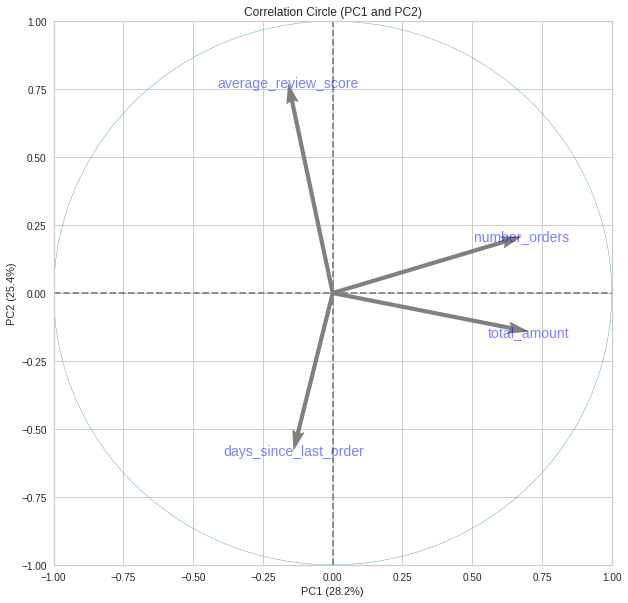

In [19]:
# Cercle des corrélations PC1 x PC2
plt.figure(figsize=(15, 15))
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

<Figure size 1080x1080 with 0 Axes>

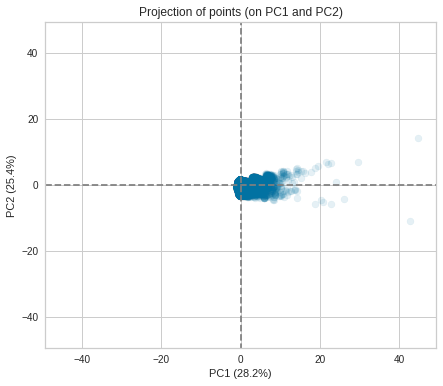

In [20]:
# Projection dans le plans PC1 x PC2

# Transform the original scaled data to the new vector space
X_projected = pca.transform(X_scaled) 

# Display a scatter plot of the data points in this new vector space
plt.figure(figsize=(15, 15))
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha = 0.1)
plt.show()

Text(0, 0.5, 'PC2')

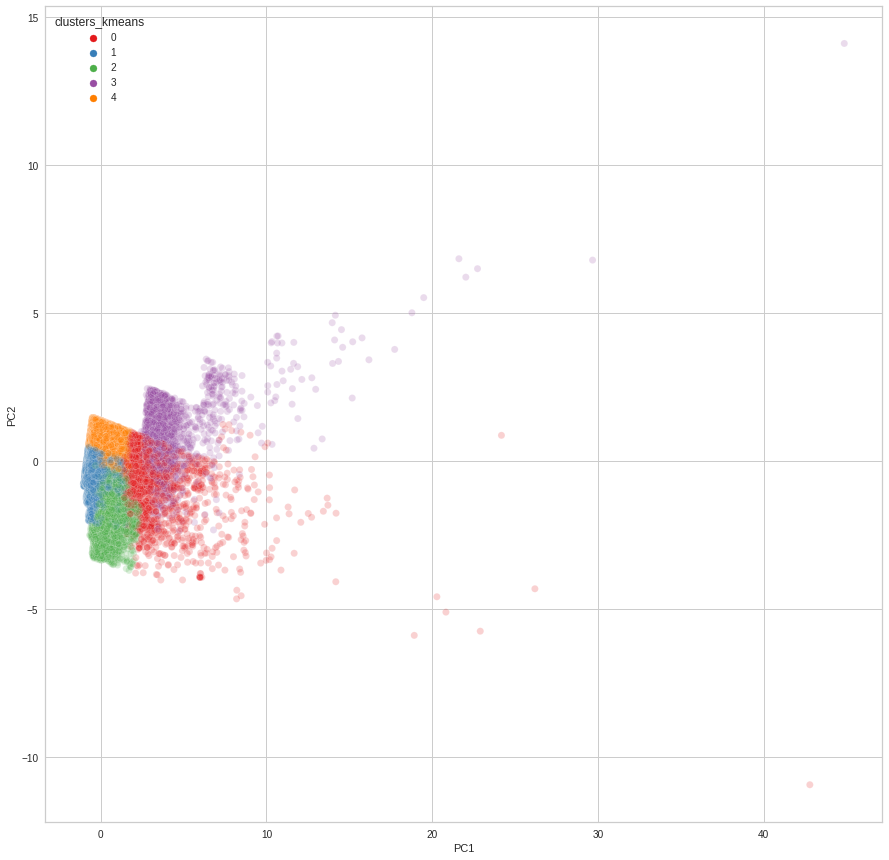

In [21]:
X_p = pd.DataFrame(X_projected)
ck = pd.DataFrame(clusters_kmeans)

X_p['clusters_kmeans'] = ck

# Projection des points dans le plans PC1 x PC2, colorisés par cluster
plt.figure(figsize = (15, 15))
sns.scatterplot(data = X_p,
               x = 0, 
               y = 1,
               hue = "clusters_kmeans",
               palette = "Set1",
               alpha = 0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")

### Analyse des clusters et profils types

Les clusters 3 et 0 ont un nombre beaucoup plus faible d'individus:
- **4** :    40106
- **1** :    30749
- **2** :    15244
- **3** :     2647
- **0** :     2020


---


Le cluster 3 contient la quasi totalité des indvidus ayant effectué plus d'une commande.

Les autres clusters sont similaire en terme de nombre de commandes (une seule commande par individu).


---


Le cluster 1 contient la majorité des individus ayant commandé pour la dernière fois il y a plus de 800 jours.

Les individus du cluster 4 sont en moyenne ceux qui ont commandé le plus récemment.

Les clusters 0, 2 et 3 sont similaires et entre les cluster 1 et 4 concernant la récence.



---



Les individus du cluster 0 ont dépensé beaucoup plus sur la periode (tous > ~700, mediane = ~1000), 
suivi des individus du cluster 3 dont la dépense mediane est d'environ 250 (lié au multiples commandes), 
suivi des clusters 1, 2 et 4 dont la dépense mediane et plus proche de 100.



---



Les individus du cluster 0 ont également un panier moyen beaucoup plus élevé(mediane=1000, tous les individus > 700)
 vs. les autres clusters (mediane d'environ 100, iso).
Cela vient principalement du prix beaucoup plus élevé des produits achetés par les individus du cluster 0.
Les produits achetés par les individus du cluster 0 sont également: 
- plus lourds
- plus volumineux
- plus couteux à transporter
- ont des descriptions plus longues
- ont légerement plus de photos en moyenne



---



Les individus du cluster 4 étalent d'avantage leurs payements, et ceux du cluster 0 les étalent le moins.
iso pour les clusters 1, 2, et 3



---



Les individus du cluster 2 laissent des reviews avec des notes plus basses, et des reviews plus longues (quand ils laissent un message).
Les individus du cluster 0 semblent laisser des reviews légèrement plus longues que ceux des cluster 1, 3 et4.
Les individus du cluster 3 laissent légèrement plus souvent des reviews écrites.



---



 
**Pas de distinction en terme de:**
- distance avec le vendeur
- average_payment_sequential

**Profil type par cluster:**
- **1** : acheteurs les moins récents
- **2** : reviews négatives et longues (quand ils laissent un message)
- **3** : 
  - achètent plus d'une fois (et ont par conséquent un montant dépensé sur la periode plus élevé que 0, 1 et 2)
  - laissent un peu plus souvent des reviews écrites
    - --> engagement plus élevé
- **4** : les acheteurs les plus récents, étalent un peu moins leur payements
- **0** : achètent des produits plus chers, volumineux, lourds, et mieux renseignés étalent d'avantage leurs payement

## DBscan

Le code provient en partie de la documentation officielle de Scikit-Learn.

In [22]:
## Finding best values of eps and min_samples
from sklearn.metrics import silhouette_score

 
# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.3, stop=0.6, step=0.1)
min_sample=100
 
# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()
 
X = StandardScaler().fit_transform(df_agg[['days_since_last_order','number_orders','total_amount','average_review_score']])

for eps_trial in eps_list:
      
      # Generating DBSAN clusters
      db = DBSCAN(eps=eps_trial, min_samples=min_sample)
      
      if(len(np.unique(db.fit_predict(X)))) > 1:
          sil_score=silhouette_score(X, db.fit_predict(X))
      else:
          continue
      
      silhouette_scores_data=silhouette_scores_data.append(pd.DataFrame(data=[[sil_score,eps_trial,min_sample]], columns=["score", "eps_trial","min_sample_trial"]))


In [23]:
 # Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)

,score,eps_trial,min_sample_trial
0,0.157073,0.5,100


In [24]:
# Modèle retenu dont on explore les clusters
db = DBSCAN(eps=0.5, min_samples=100)

# Fit du modèle
db.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)

DBSCAN(min_samples=100)

In [25]:
# Obtention des clusters pour chaque individu
clusters_dbscan = db.fit_predict(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)

# Ajout au DataFrame des clusters
df_w_clusters["cluster_dbscan"] = clusters_dbscan

# Check
df_w_clusters.head()


,customer_unique_id,last_order,first_order,number_orders,total_amount,average_cart,average_price,average_qty,average_review_score,number_reviews,...,first_payment_type,first_product_category,average_product_name_lenght,average_product_description_lenght,average_review_lenght,average_product_photos_qty,days_since_last_order,review_rate,cluster_kmeans,cluster_dbscan
0,397c24b06740a0578e1e4ef14ab7dc4e,2018-04-13,2018-04-13,1,46.96,46.96,24.90,1.0,5.0,1,...,credit_card,sports_leisure,52.0,1392.0,48.0,1.0,628,1.0,4,0
1,3cde4b009a25beebc485cf2059ddc991,2018-03-17,2018-03-17,1,38.13,38.13,19.90,1.0,3.0,0,...,boleto,bed_bath_table,52.0,153.0,NaN,1.0,655,0.0,2,1
2,469356420bccdecae3c5a3f9d8089ddd,2018-02-13,2018-02-13,1,76.17,76.17,59.99,1.0,4.0,0,...,credit_card,bed_bath_table,57.0,504.0,NaN,1.0,687,0.0,4,2
3,a2353d74607f052ae9640d3af3b81132,2018-02-26,2018-02-26,1,387.14,387.14,369.80,1.0,4.0,0,...,credit_card,watches_gifts,50.0,464.0,NaN,2.0,674,0.0,4,2
4,99f0c33abddbeb5b72869e0e505453a9,2017-11-25,2017-11-25,1,24.30,24.30,9.20,1.0,5.0,1,...,boleto,auto,60.0,324.0,21.0,1.0,767,1.0,1,0


### EDA des clusters

In [26]:
# Repartition des individus par cluster
df_w_clusters['cluster_dbscan'].value_counts()

 0    51380
 2    17038
 3     8223
 1     7052
-1     3043
 4     2530
 5     1500
Name: cluster_dbscan, dtype: int64

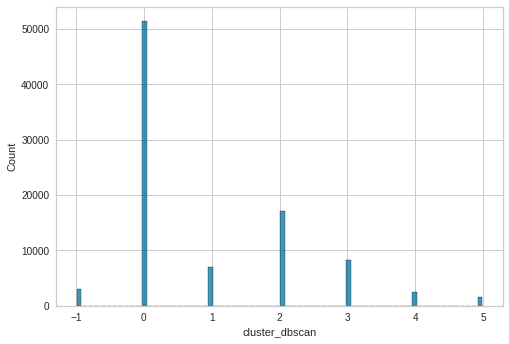

In [27]:
# histogramme de la repartition des individus par cluster
sns.histplot(data=df_w_clusters, x="cluster_dbscan", shrink=.8)

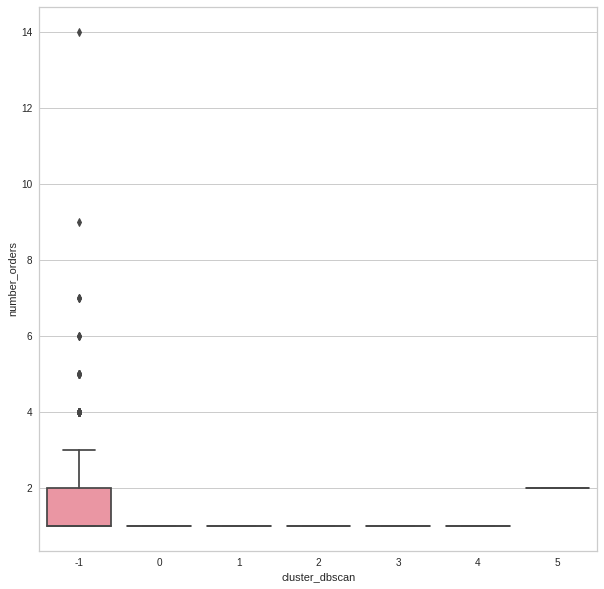

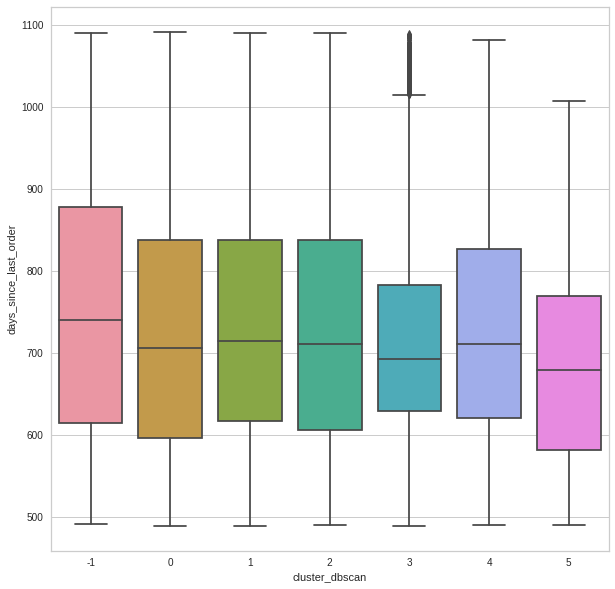

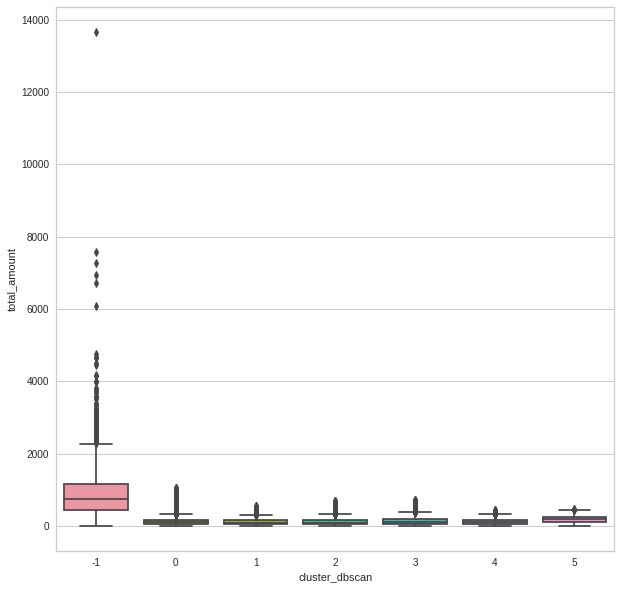

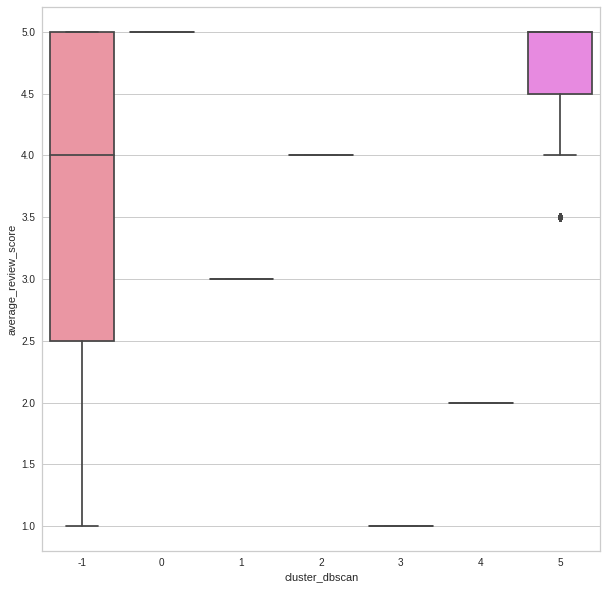

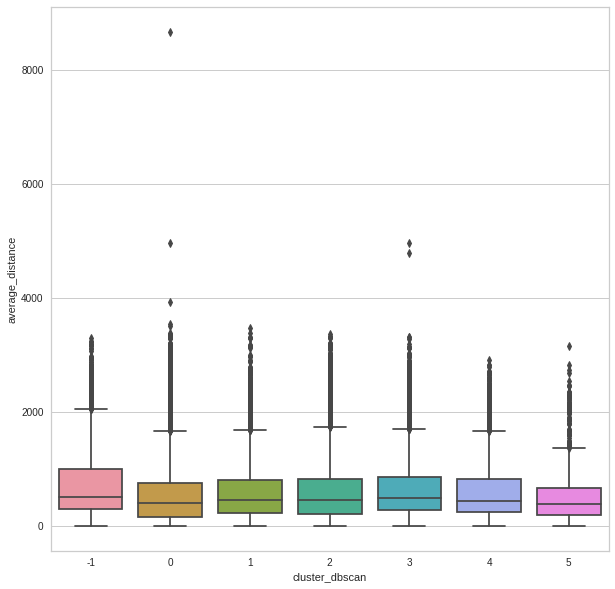

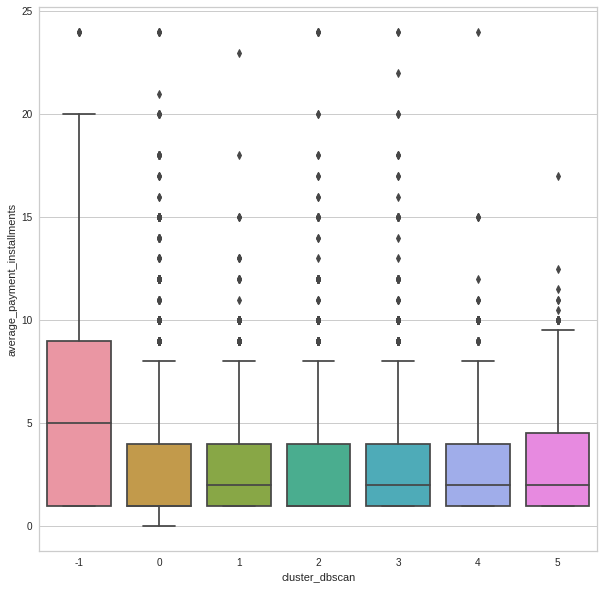

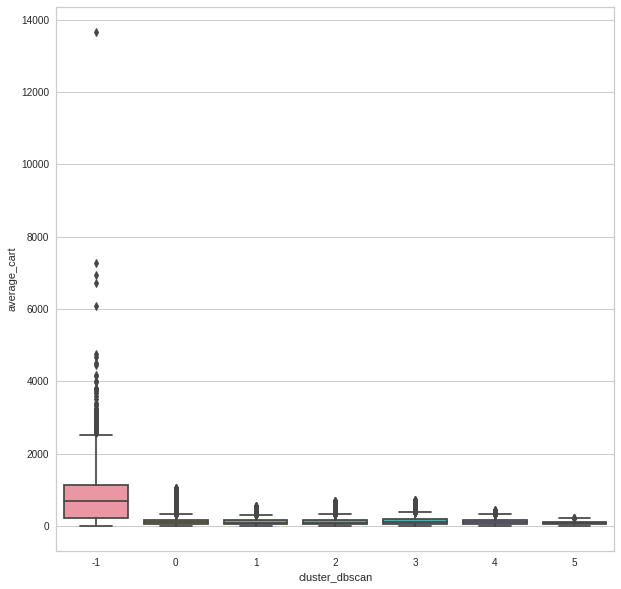

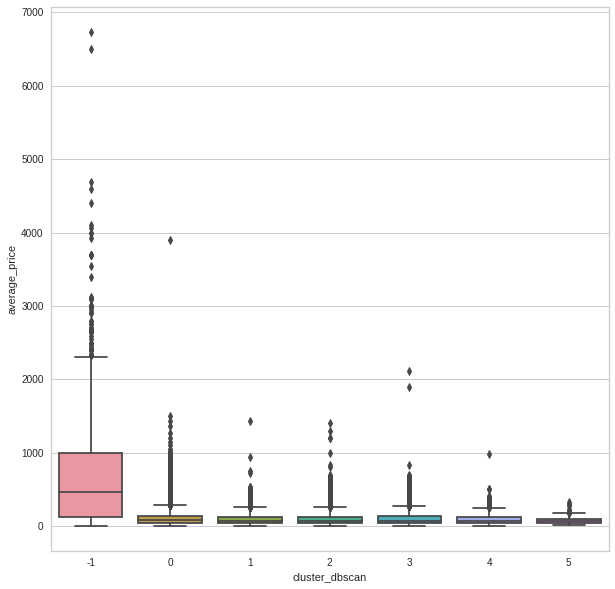

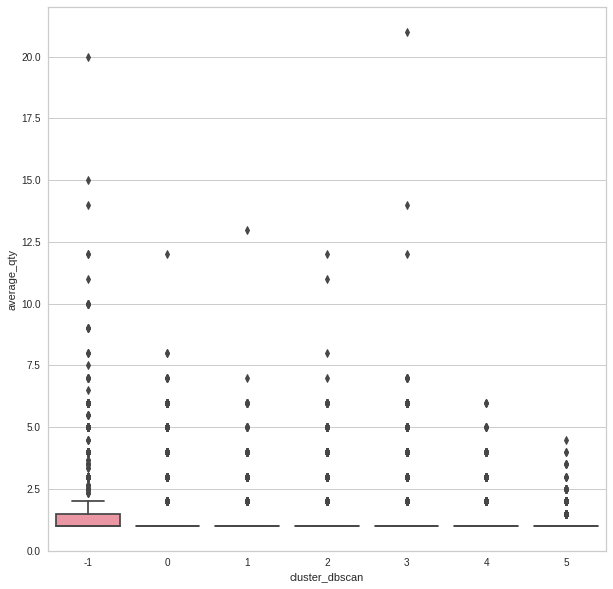

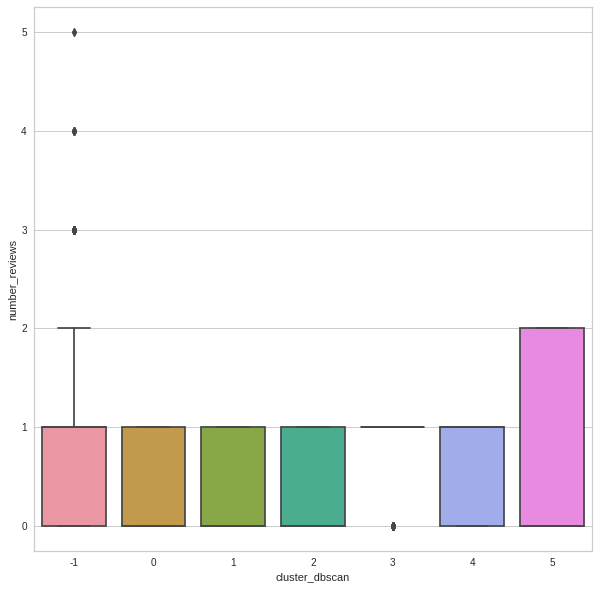

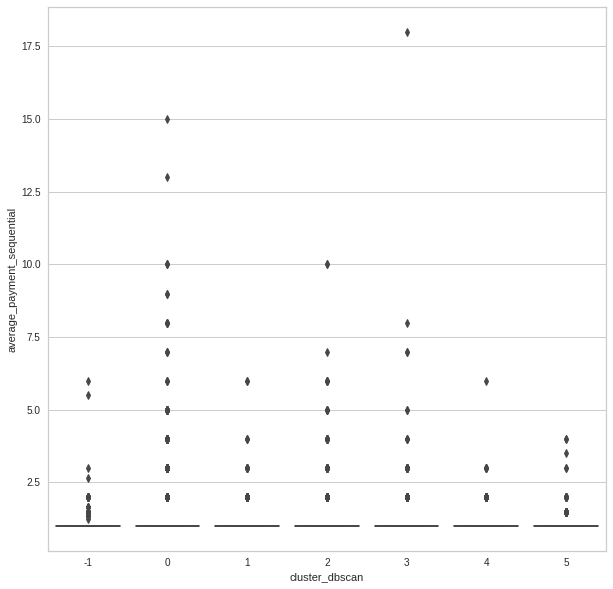

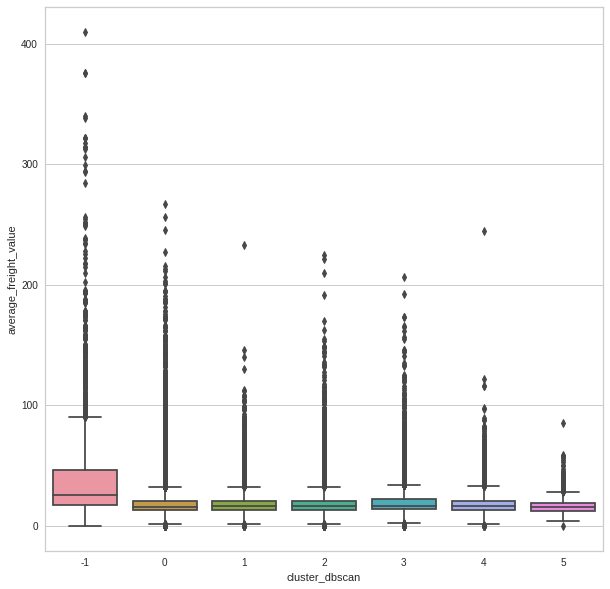

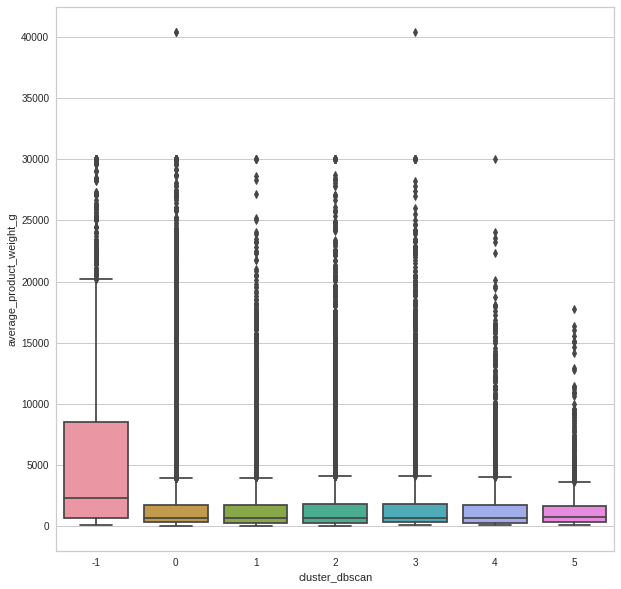

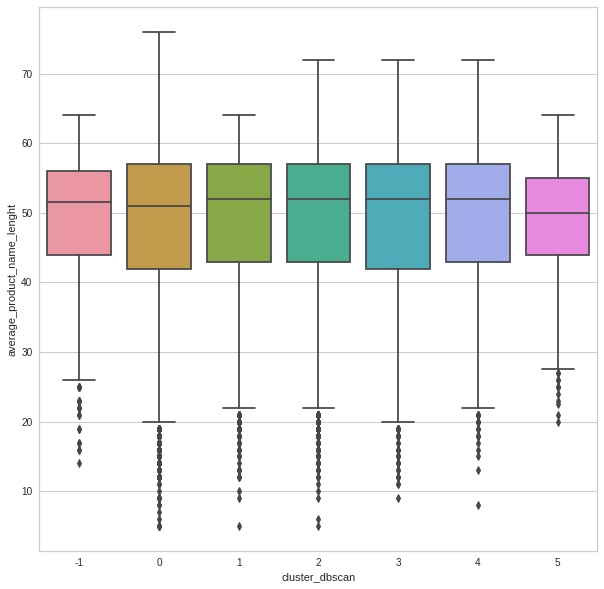

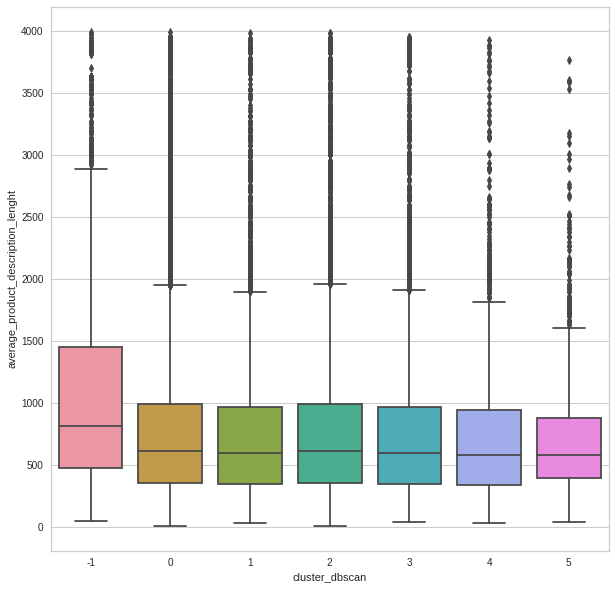

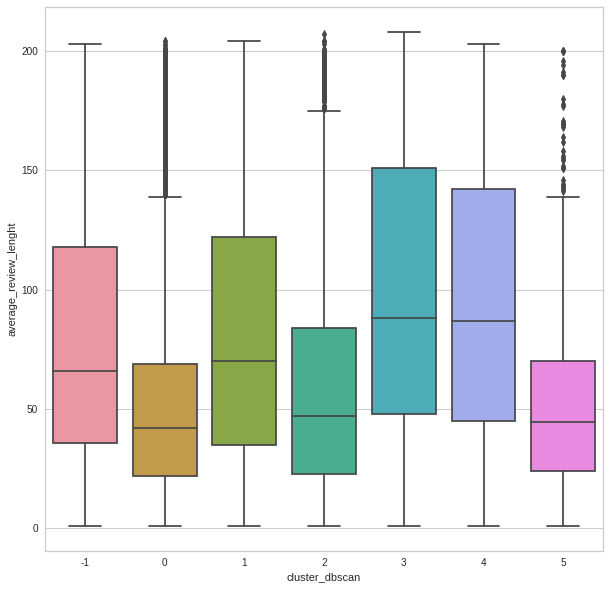

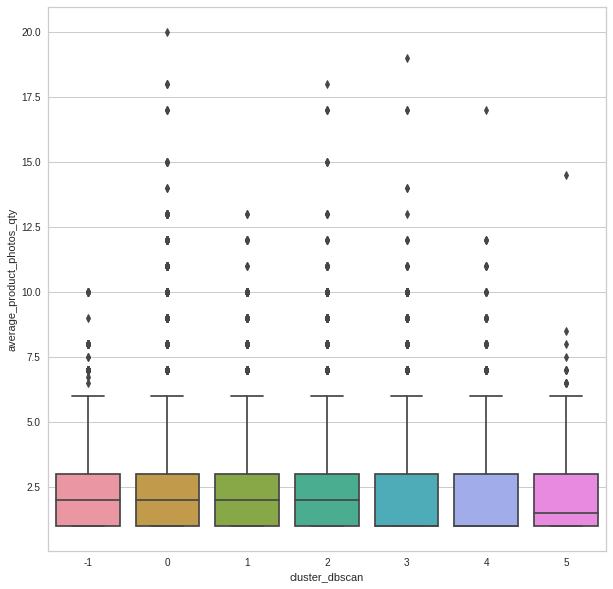

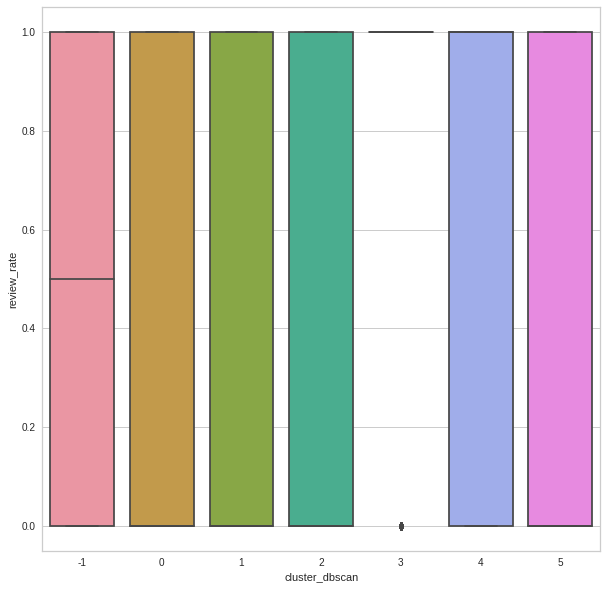

In [28]:
# Boxplot par variable et par cluster
for i in quant_var:
  plt.figure(figsize=(10,10))
  sns.boxplot(data=df_w_clusters, x='cluster_dbscan', y=i)
  plt.show()

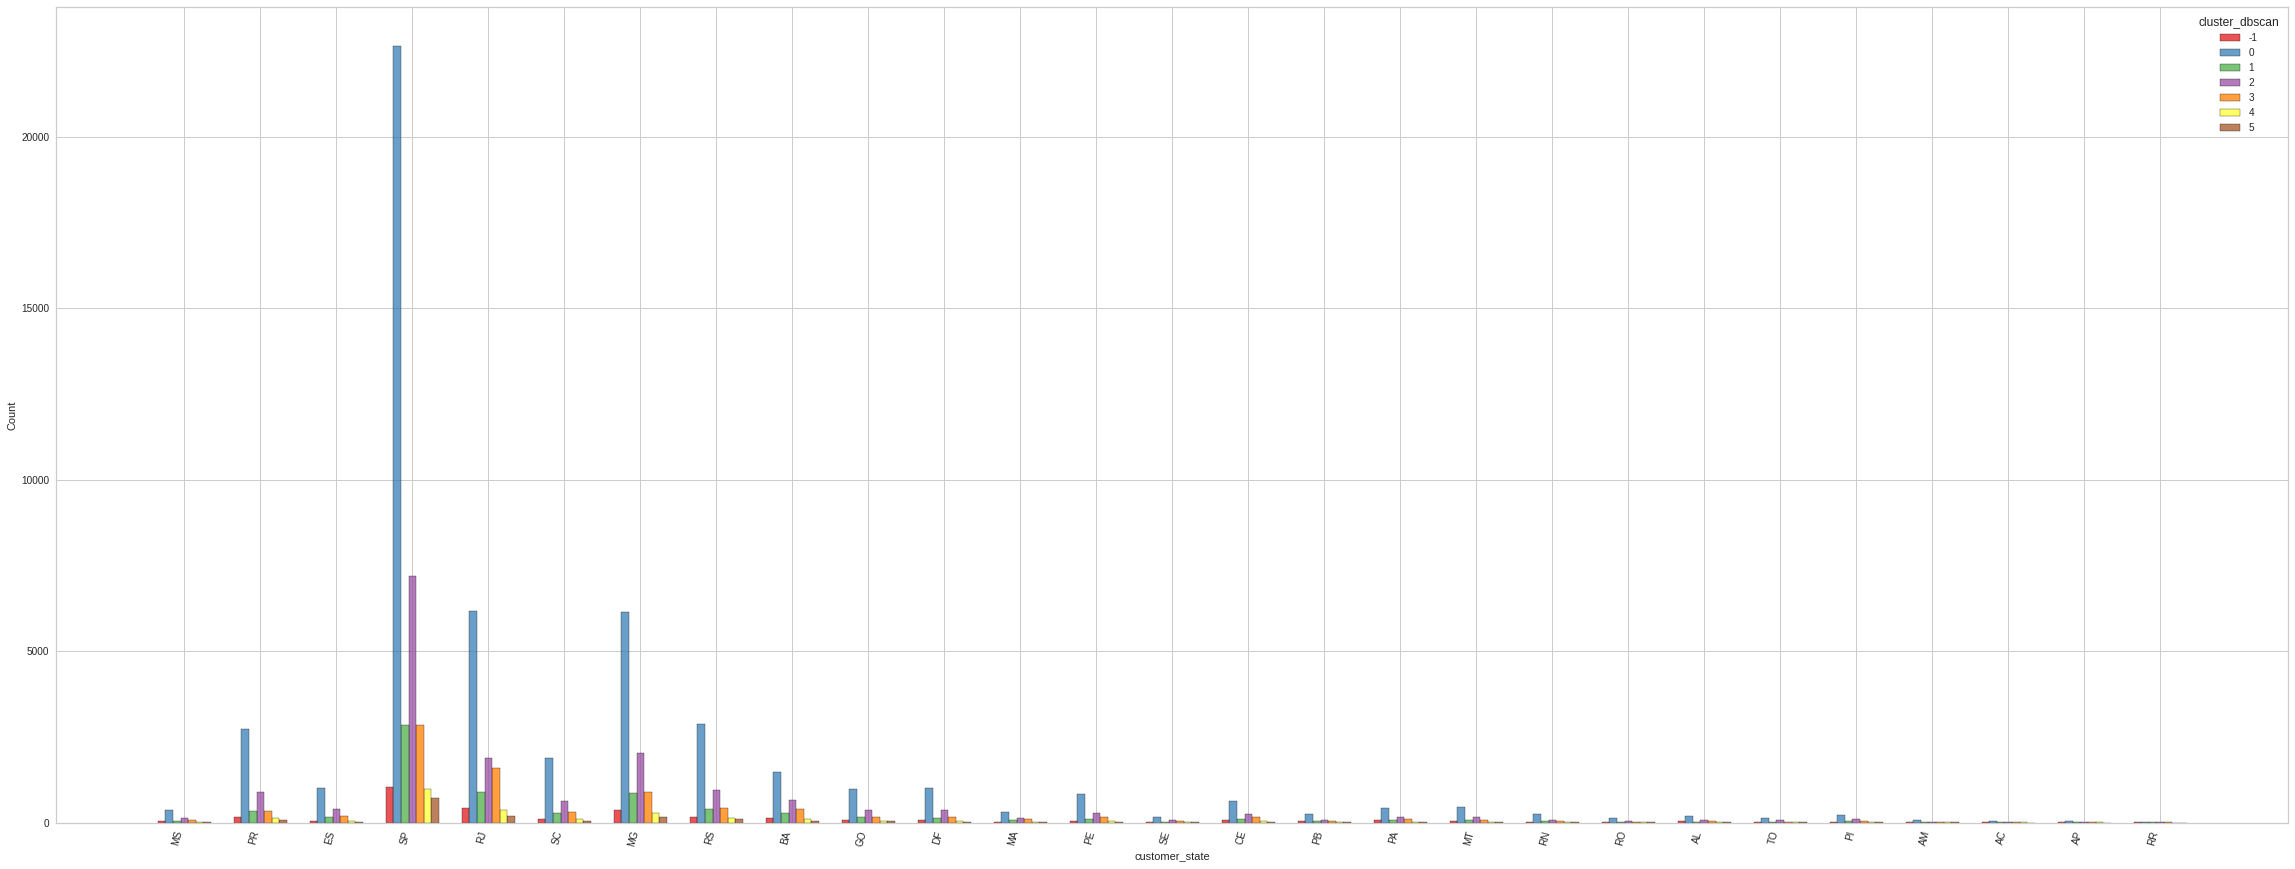

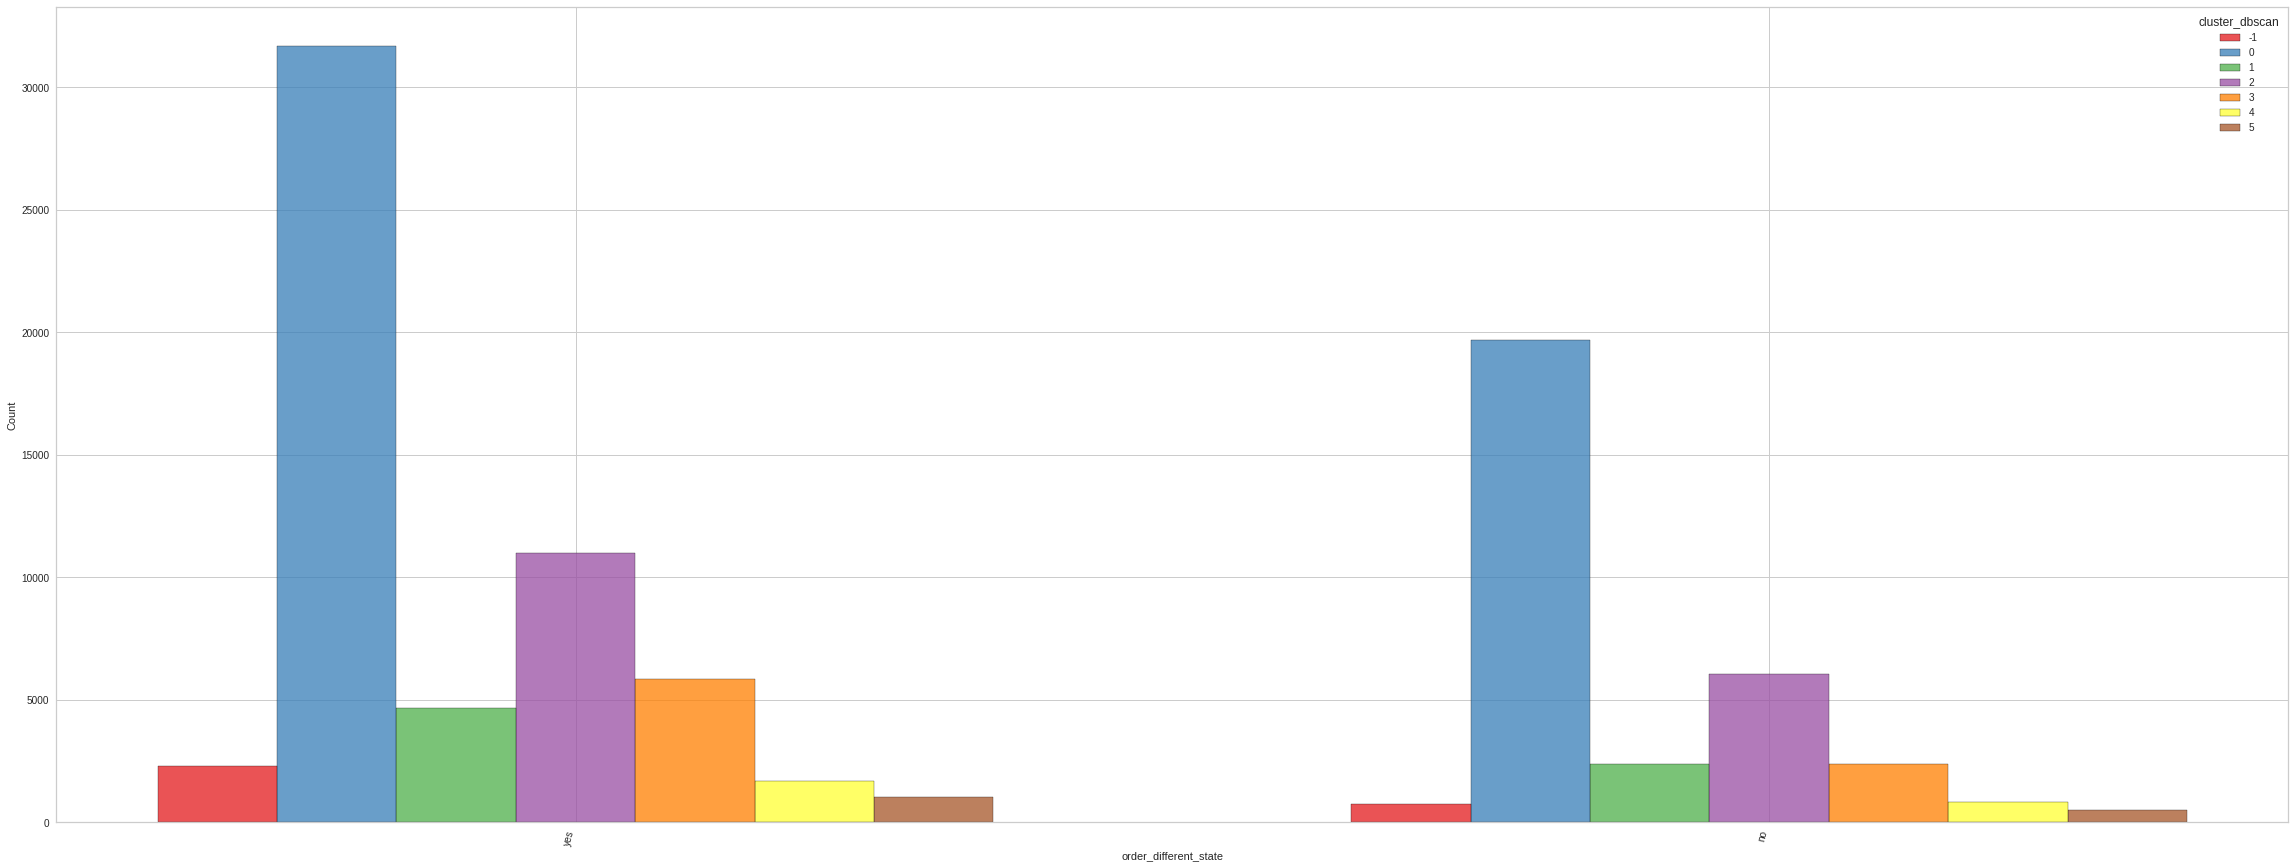

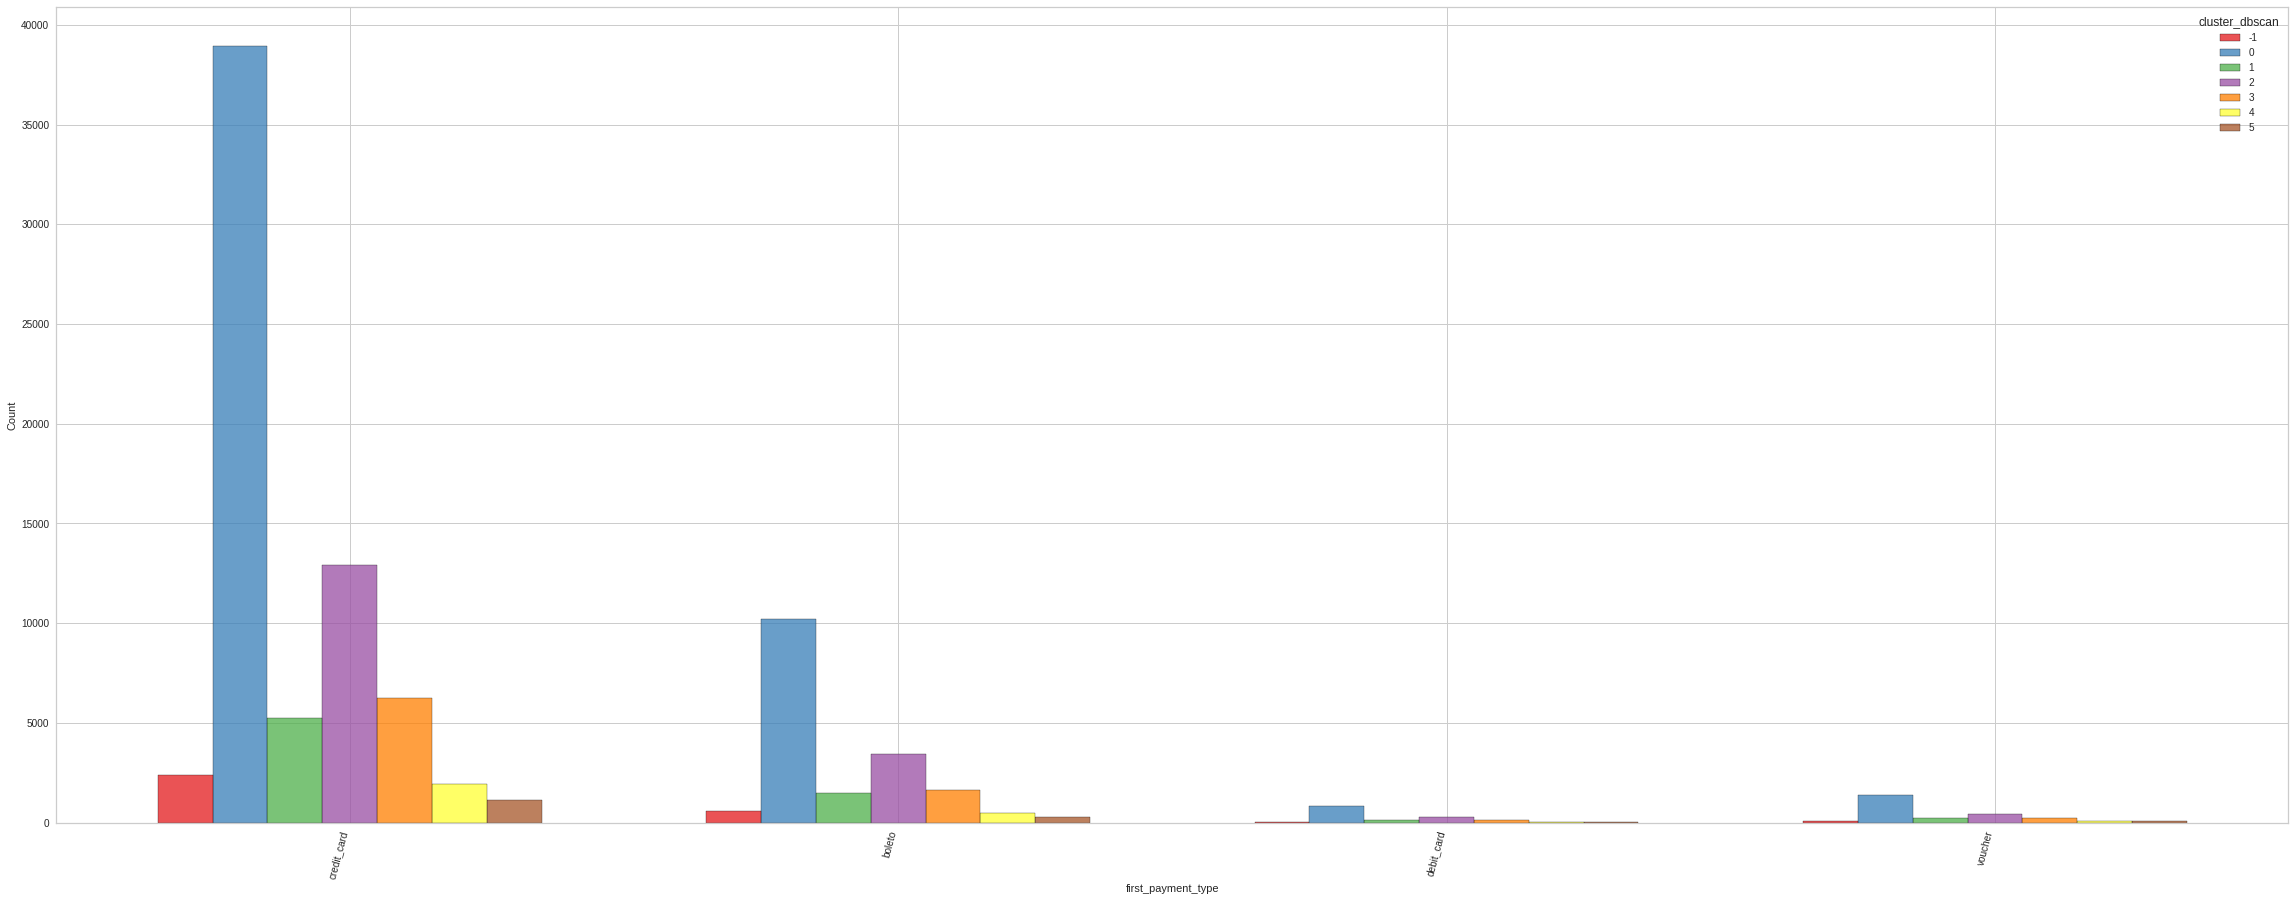

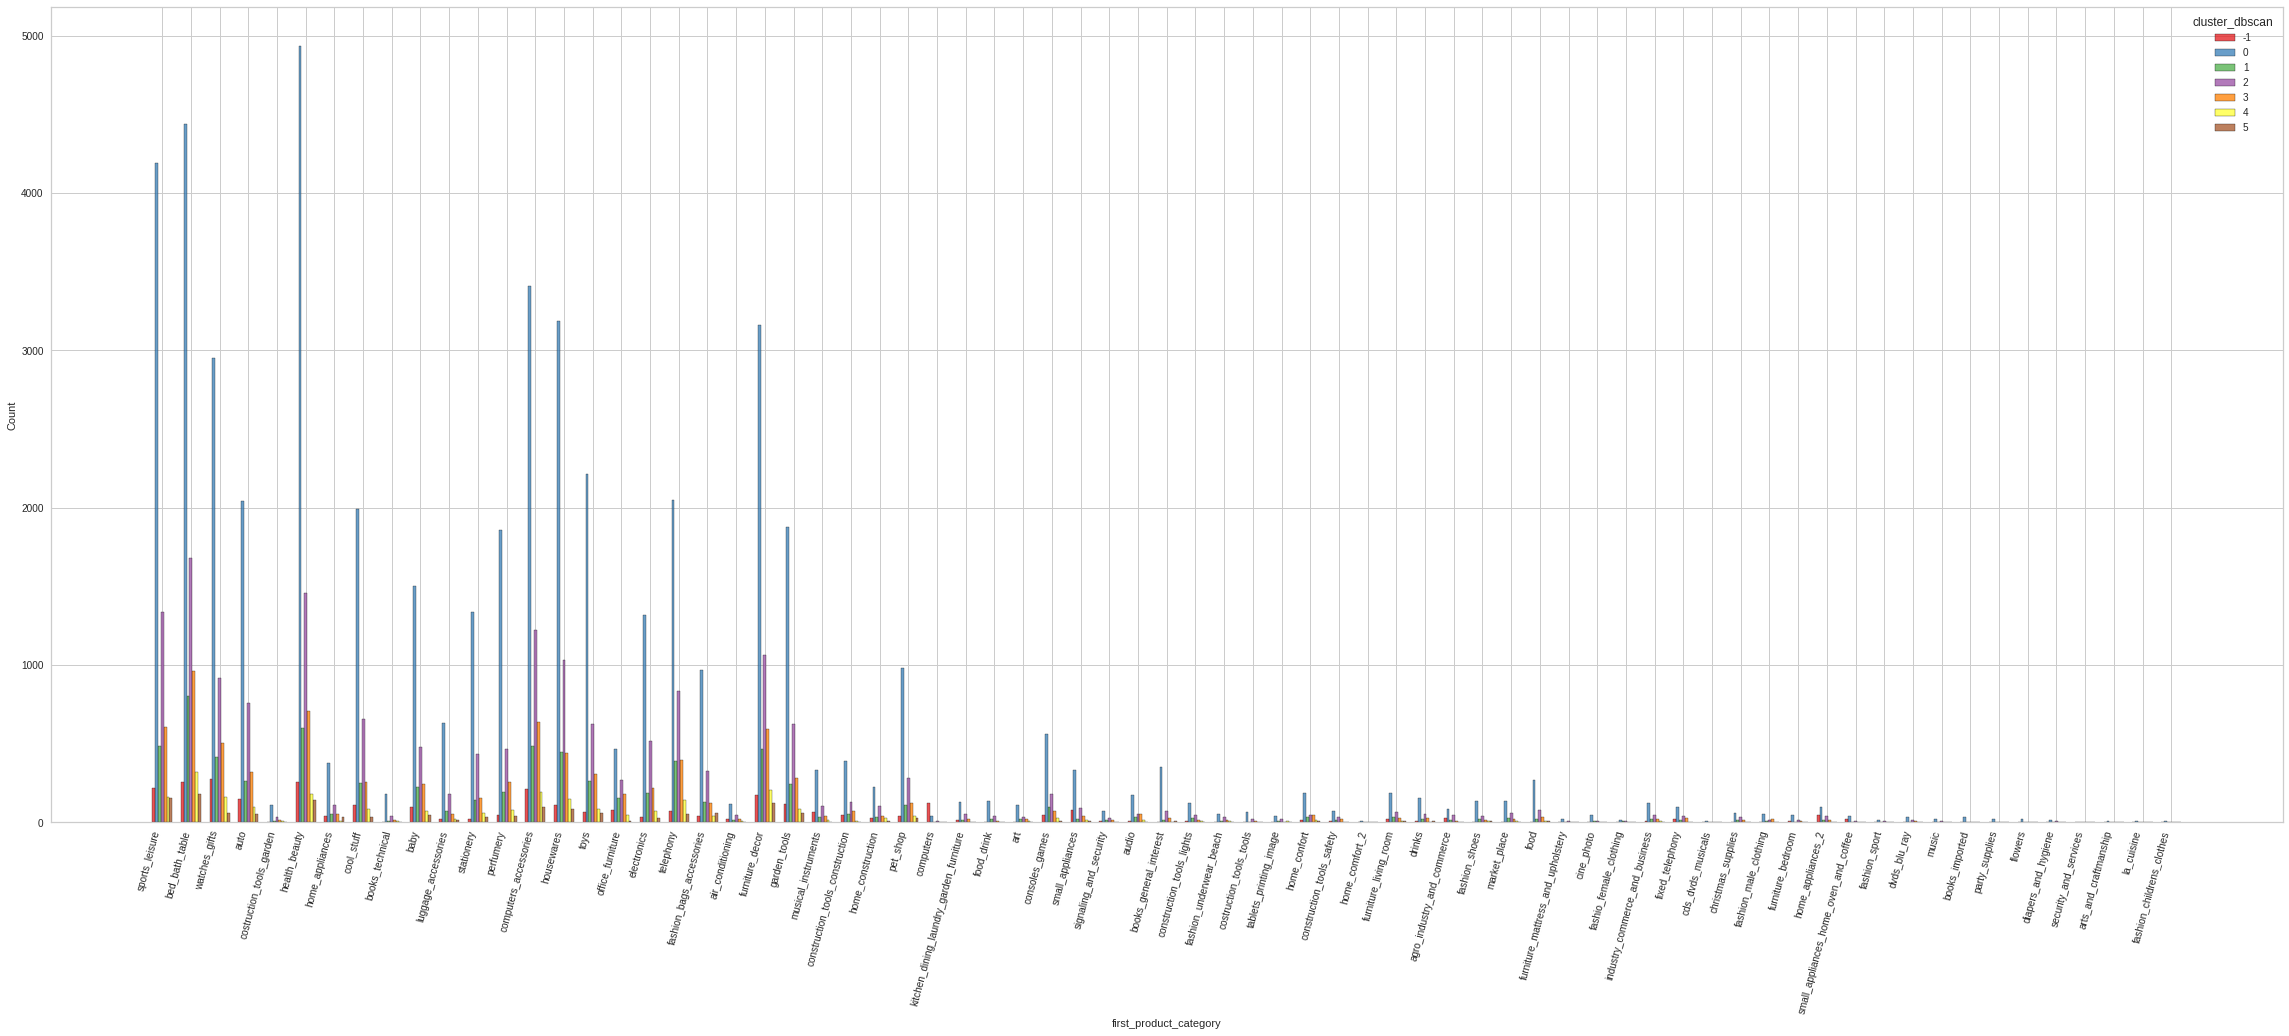

In [29]:
# Boxplot par variable et par cluster
for i in cat_var:
    plt.figure(figsize=(40, 15))
    sns.histplot(
        data=df_w_clusters,
        x=i,
        hue="cluster_dbscan",
        multiple="dodge",
        shrink=0.7,
        palette="Set1",
    )
    plt.xticks(rotation=75, ha="right")
    plt.show()


### Analyse du clustering

6 clusters 

- **certains individus ne sont pas assignés à un cluster**: les individus ayant dépensé beaucoup sur la période et une partie des individus ayant effectué plusieurs commandes
- segmente de manière quasi discriminatoire sur les notes de review

le clustering ne depend que de la note moyenne, sauf pour le cluster 5 qui contient une partie des clients ayant acheté 2 fois.

**Le DBscan ne capture aucune autre nuance: les profils types n'ont pas ou peu d'intérêt.**



## Clustering agglomératif

Ce clustering sera effectué sur un echantillon equilibre (nombre de commandes), car le clustering agglomératif est très groumand en ressources. Un dataset trop grand nécessite beaucoup de mémoire vive pour être effectué.

In [30]:
# Stratified sampling pour entrainer le modèle
df_sample = df_agg.groupby("number_orders", group_keys=False).apply(
    lambda x: x.sample(frac=0.1)
)

# Check
df_sample

,customer_unique_id,last_order,first_order,number_orders,total_amount,average_cart,average_price,average_qty,average_review_score,number_reviews,...,customer_state,order_different_state,first_payment_type,first_product_category,average_product_name_lenght,average_product_description_lenght,average_review_lenght,average_product_photos_qty,days_since_last_order,review_rate
29968,ba15918411dd21ad6ec1a97aa9f52fe4,2017-06-15,2017-06-15,1,81.57,81.5700,45.900,1.00,5.000000,1,...,MA,yes,credit_card,cool_stuff,59.00,734.000000,34.00,4.0,930,1.0
57587,d76adfdcadecba144ec1e65118e8e165,2017-11-28,2017-11-28,1,157.22,157.2200,139.000,1.00,5.000000,1,...,RS,yes,credit_card,toys,48.00,1146.000000,44.00,7.0,764,1.0
77478,ca4c819244dcfc89d532bed6e629c80a,2018-07-10,2018-07-10,1,169.20,169.2000,149.980,1.00,5.000000,0,...,SP,no,credit_card,office_furniture,55.00,1292.000000,NaN,1.0,540,0.0
48183,0340c3b9ed45ab5dc6959d10651775fc,2017-09-13,2017-09-13,1,21.10,21.1000,7.000,1.00,5.000000,0,...,RS,yes,credit_card,telephony,56.00,3135.000000,NaN,2.0,840,0.0
43976,1f773c8d8bfac690beddb97b2864f74f,2017-11-05,2017-11-05,1,77.86,77.8600,65.900,1.00,5.000000,0,...,SP,no,credit_card,home_construction,47.00,870.000000,NaN,2.0,787,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22757,e1224167b1a3f92781c2ff55b0b794be,2018-02-16,2017-12-02,3,141.42,47.1400,37.200,1.00,3.666667,0,...,SP,no,credit_card,electronics,40.00,466.333333,NaN,1.0,684,0.0
5626,795c1622cf7a53d63d324e862349d01c,2018-08-18,2018-01-16,4,354.23,88.5575,70.300,1.00,4.000000,0,...,PR,yes,credit_card,baby,54.75,1189.750000,NaN,2.5,501,0.0
9317,394ac4de8f3acb14253c177f0e15bc58,2018-08-16,2017-12-23,4,722.11,180.5275,118.315,1.25,5.000000,0,...,SP,yes,credit_card,health_beauty,57.75,1266.000000,NaN,3.0,503,0.0
79062,f64ec6d8dd29940264cd0bbb5ecade8a,2017-11-22,2017-10-07,4,359.00,89.7500,72.000,1.00,5.000000,4,...,RJ,yes,credit_card,housewares,54.50,769.000000,98.75,1.0,770,1.0


In [31]:
# instancie le modele
hier = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# fit
hier.fit(
    StandardScaler().fit_transform(
        df_sample[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)


AgglomerativeClustering(distance_threshold=0, n_clusters=None)

La fonction générant le dendrograme provient de la documentation officielle de Scikit Learn.

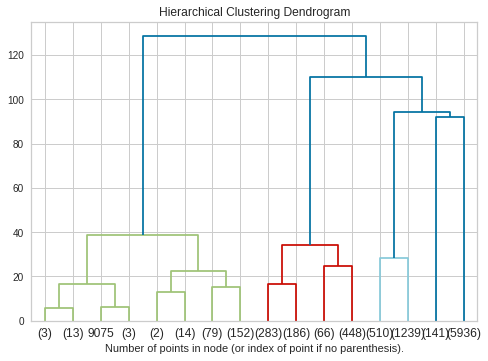

In [32]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



plt.title("Hierarchical Clustering Dendrogram")
# plot the levels of the dendrogram
plot_dendrogram(hier, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

**On choisi de retenir 5 clusters.**

In [33]:
# modèle dont on explore les clusters
hier = AgglomerativeClustering(n_clusters=5, compute_full_tree=False)

# fit et obtention des clusters
clusters_hier = hier.fit_predict(
    StandardScaler().fit_transform(
        df_sample[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
            ]
        ]
    )
)

df_sample_w_clusters = df_sample.copy()
df_sample_w_clusters["cluster_hier"] = clusters_hier


### EDA des clusters

In [34]:
# répartition des individus par cluster
df_sample_w_clusters['cluster_hier'].value_counts()

0    5936
3    1749
2     983
1     267
4     141
Name: cluster_hier, dtype: int64

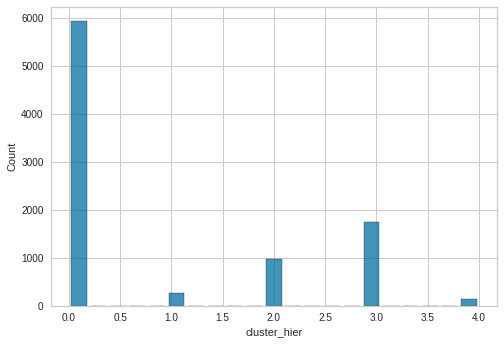

In [35]:
# histograme de la # répartition des individus par cluster
sns.histplot(data=df_sample_w_clusters, x="cluster_hier", shrink=.8)

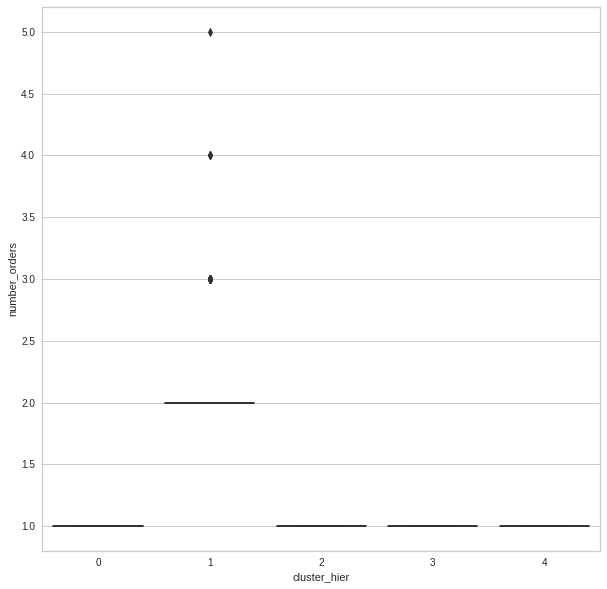

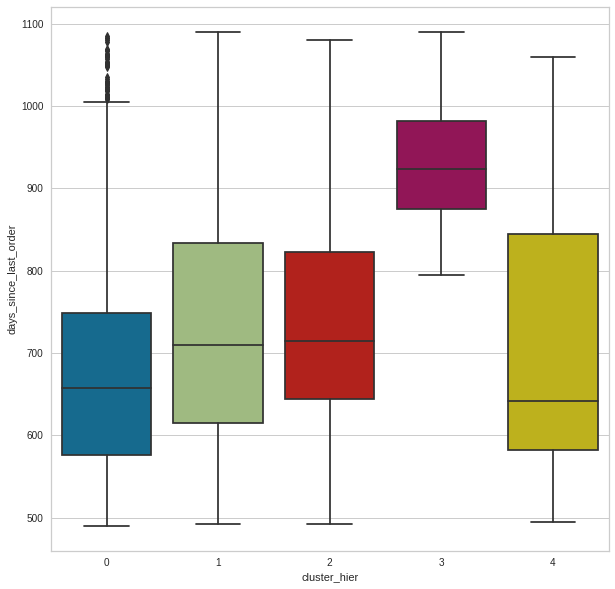

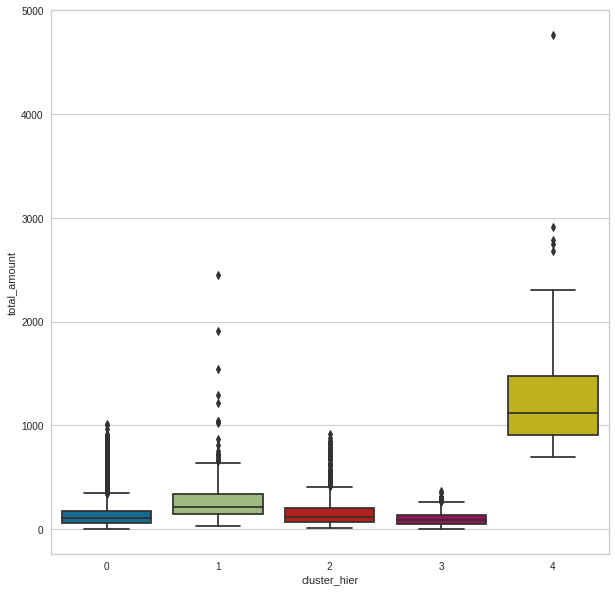

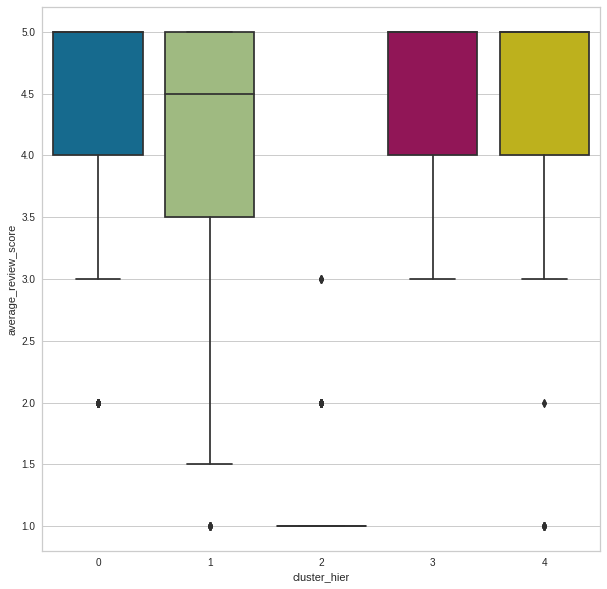

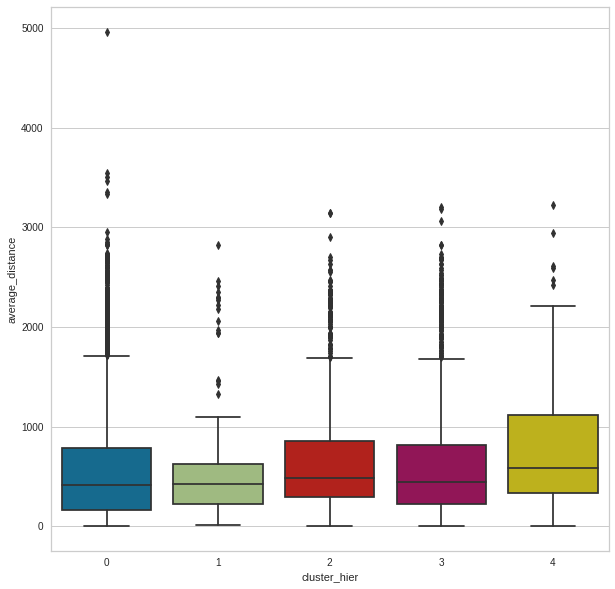

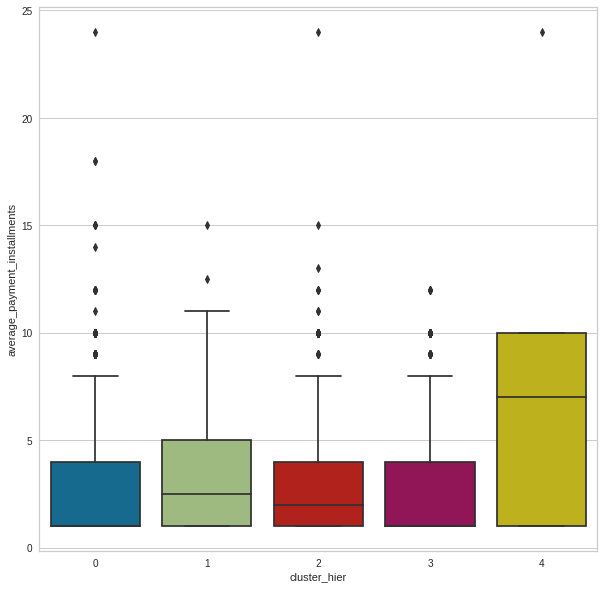

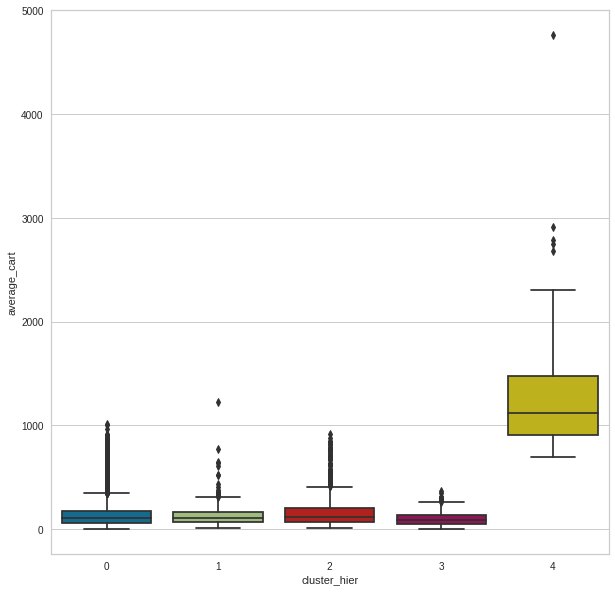

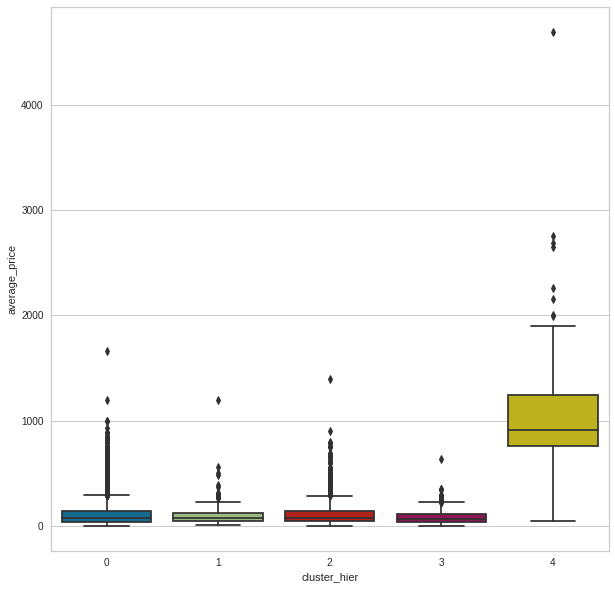

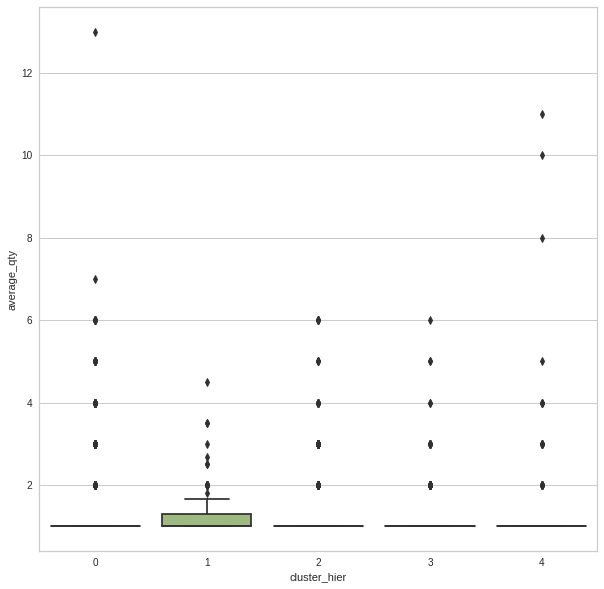

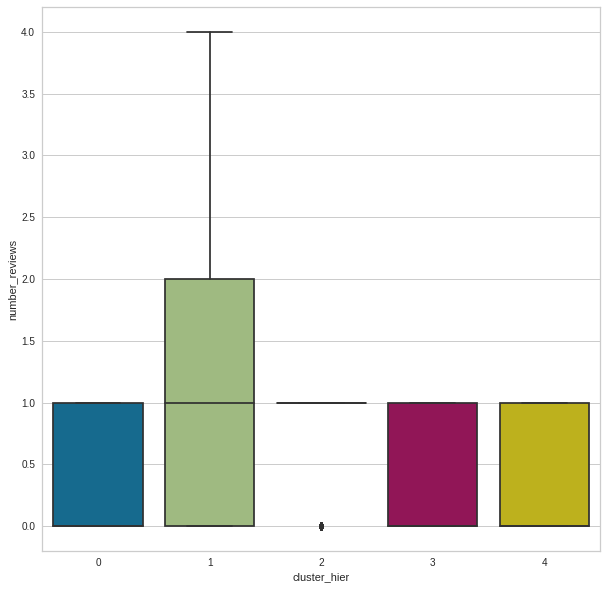

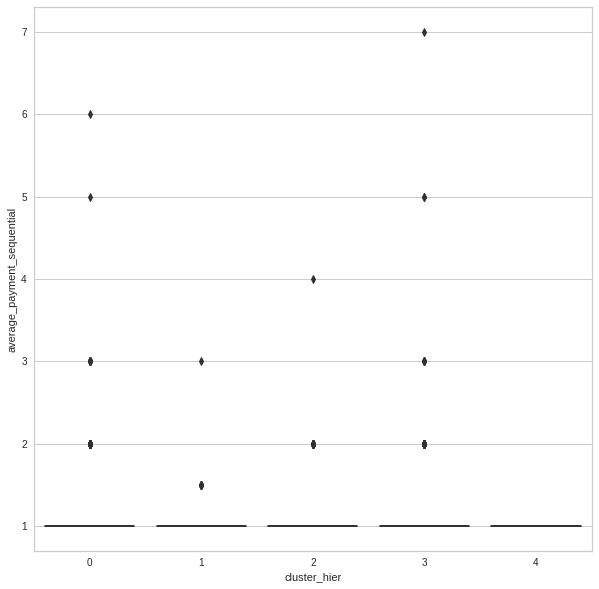

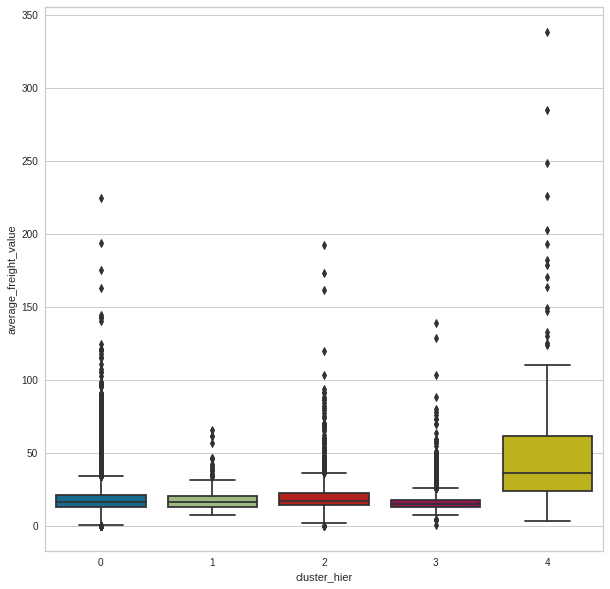

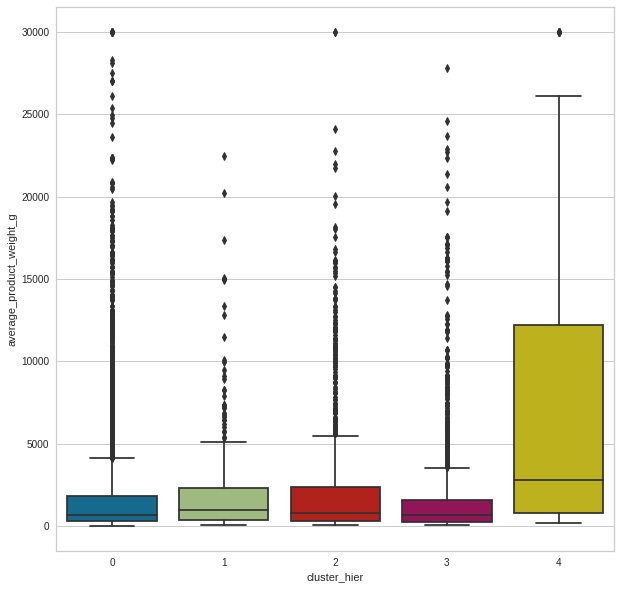

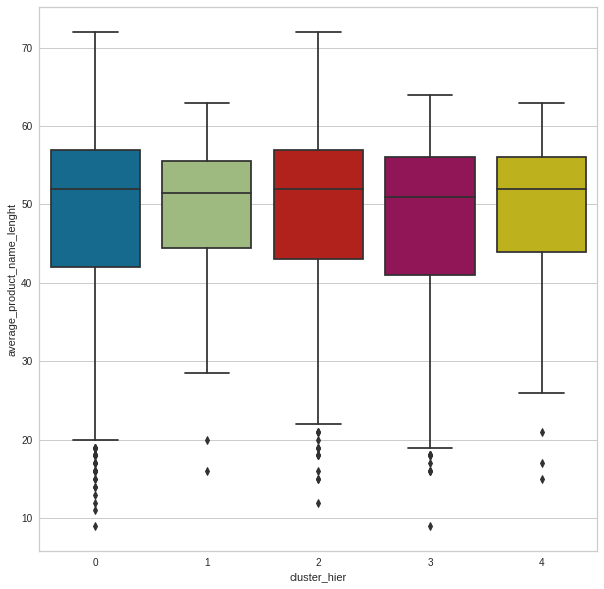

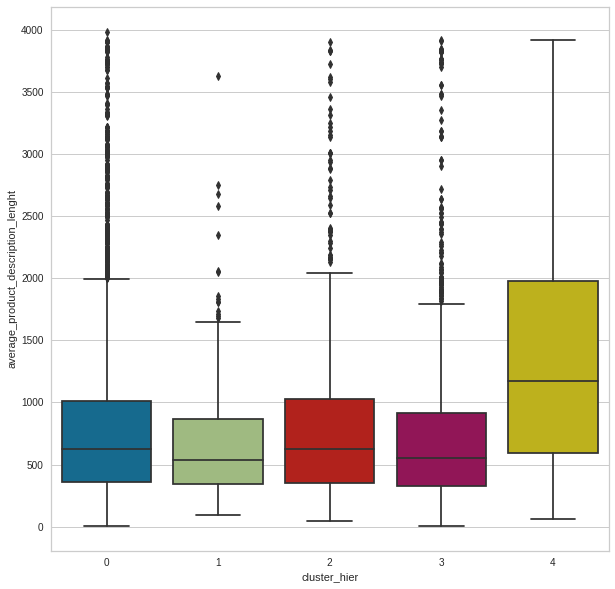

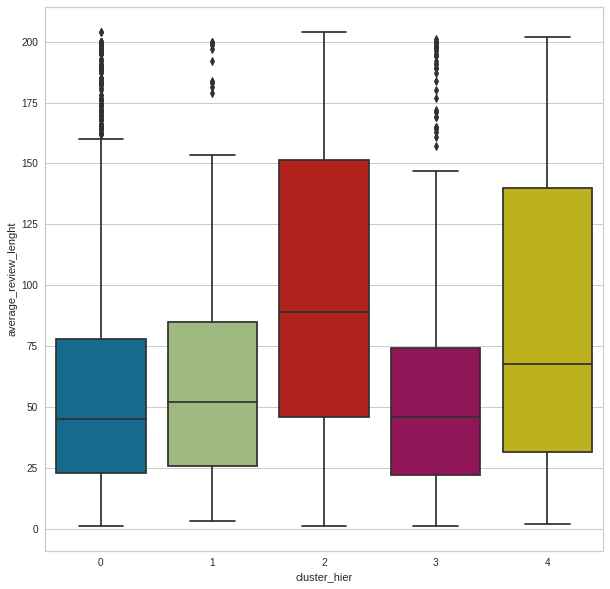

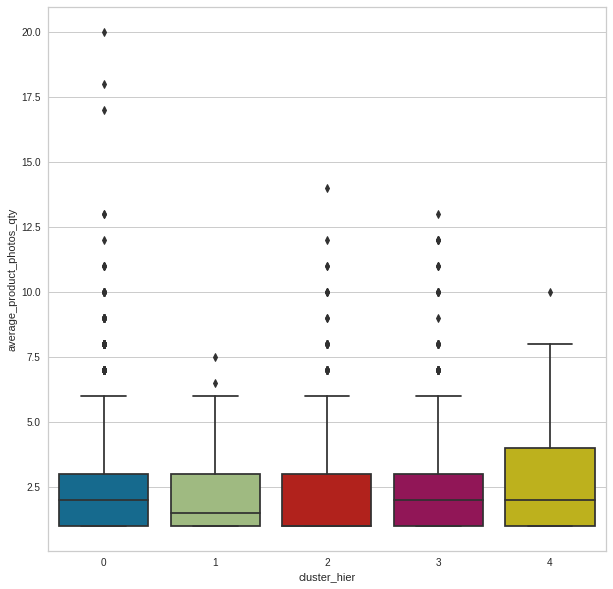

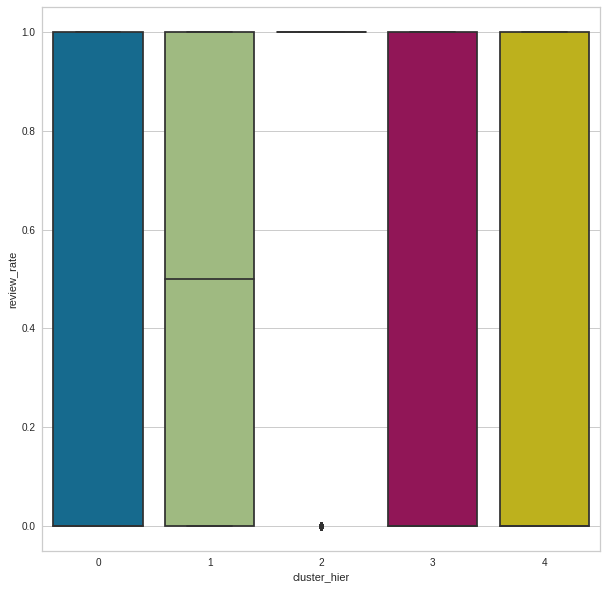

In [36]:
# boxplots par variable et par cluster
for i in quant_var:
  plt.figure(figsize=(10,10))
  sns.boxplot(data=df_sample_w_clusters, x='cluster_hier', y=i)
  plt.show()

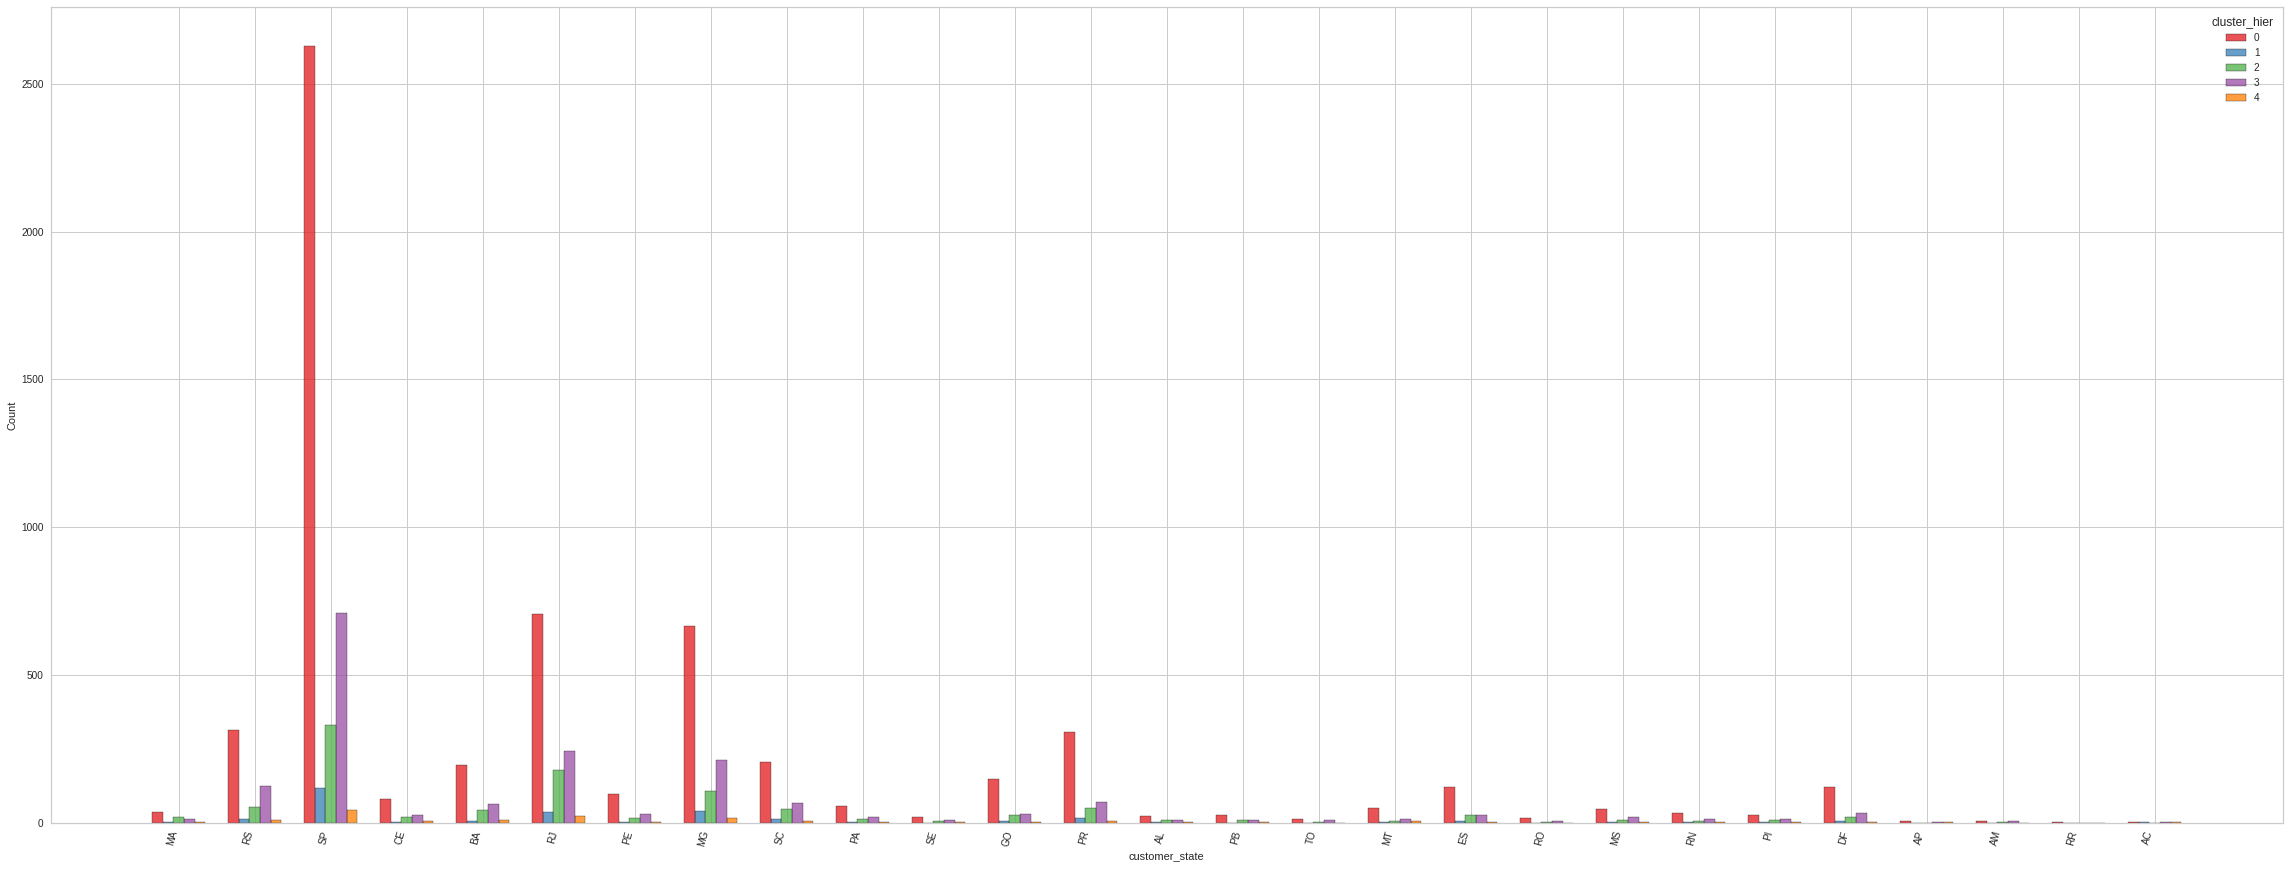

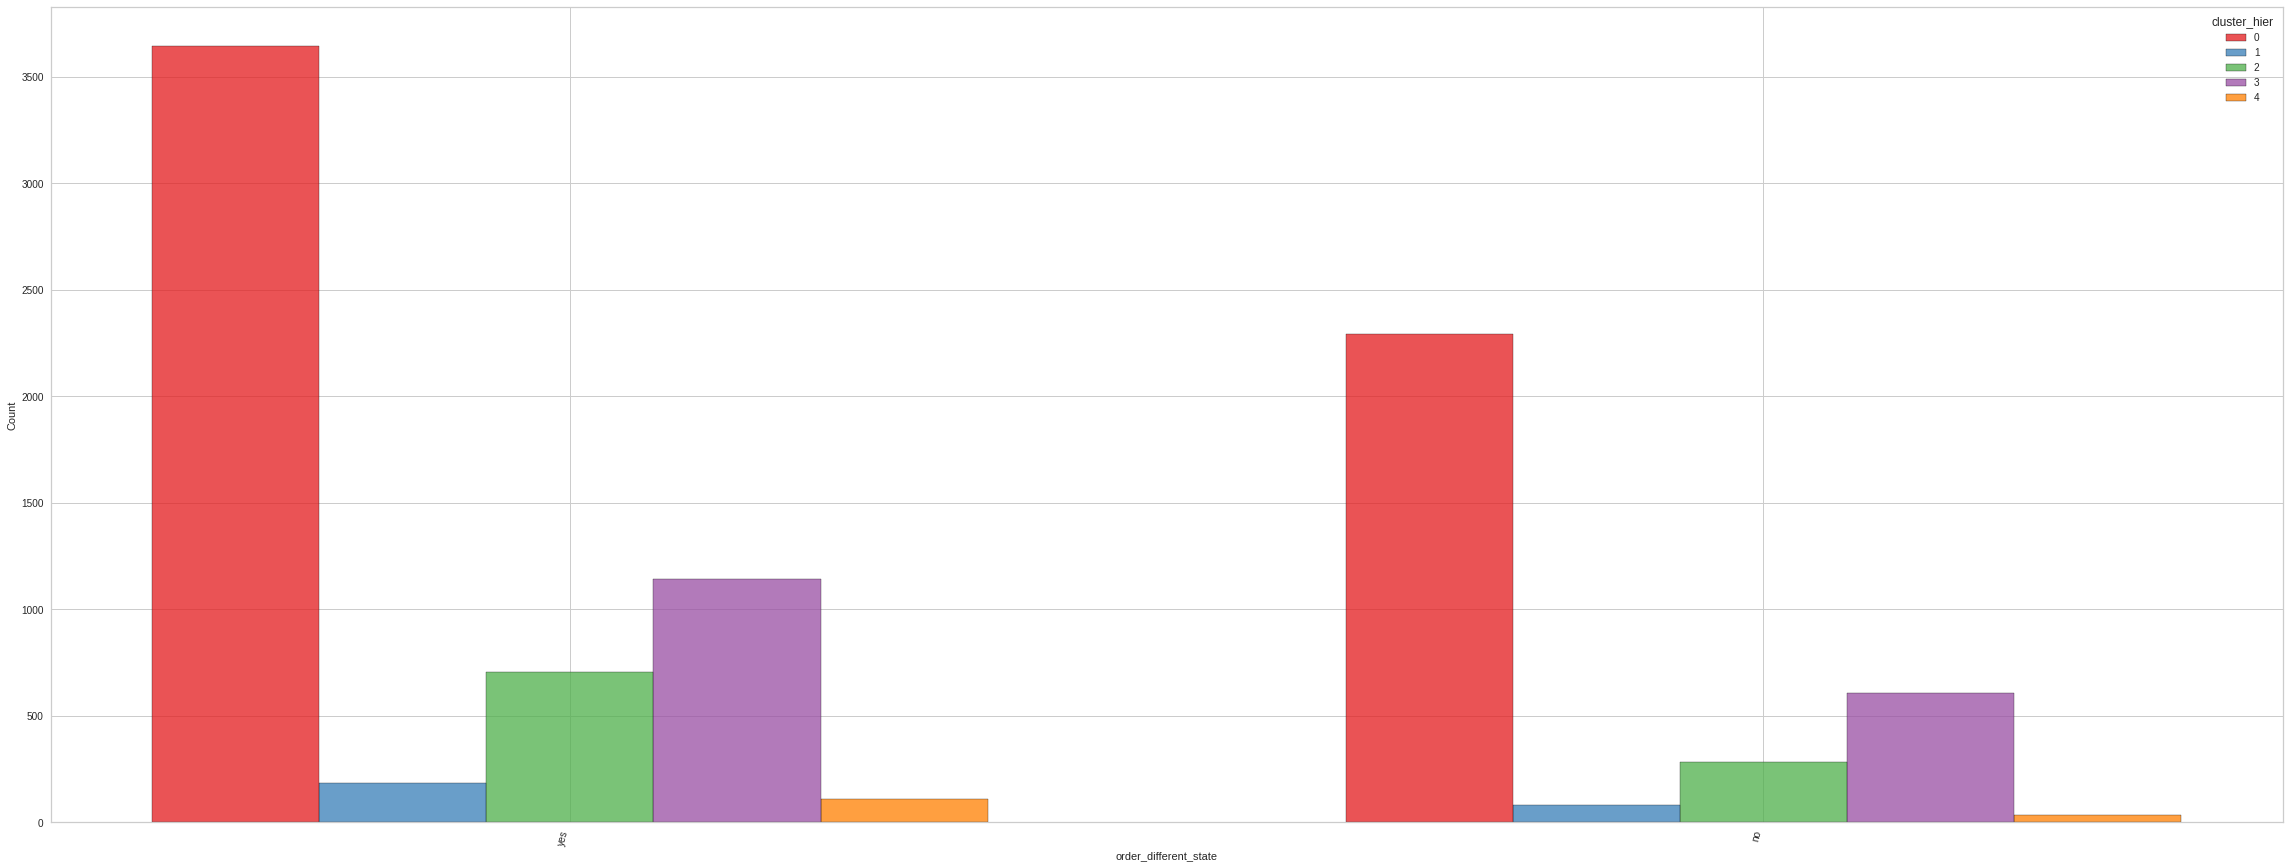

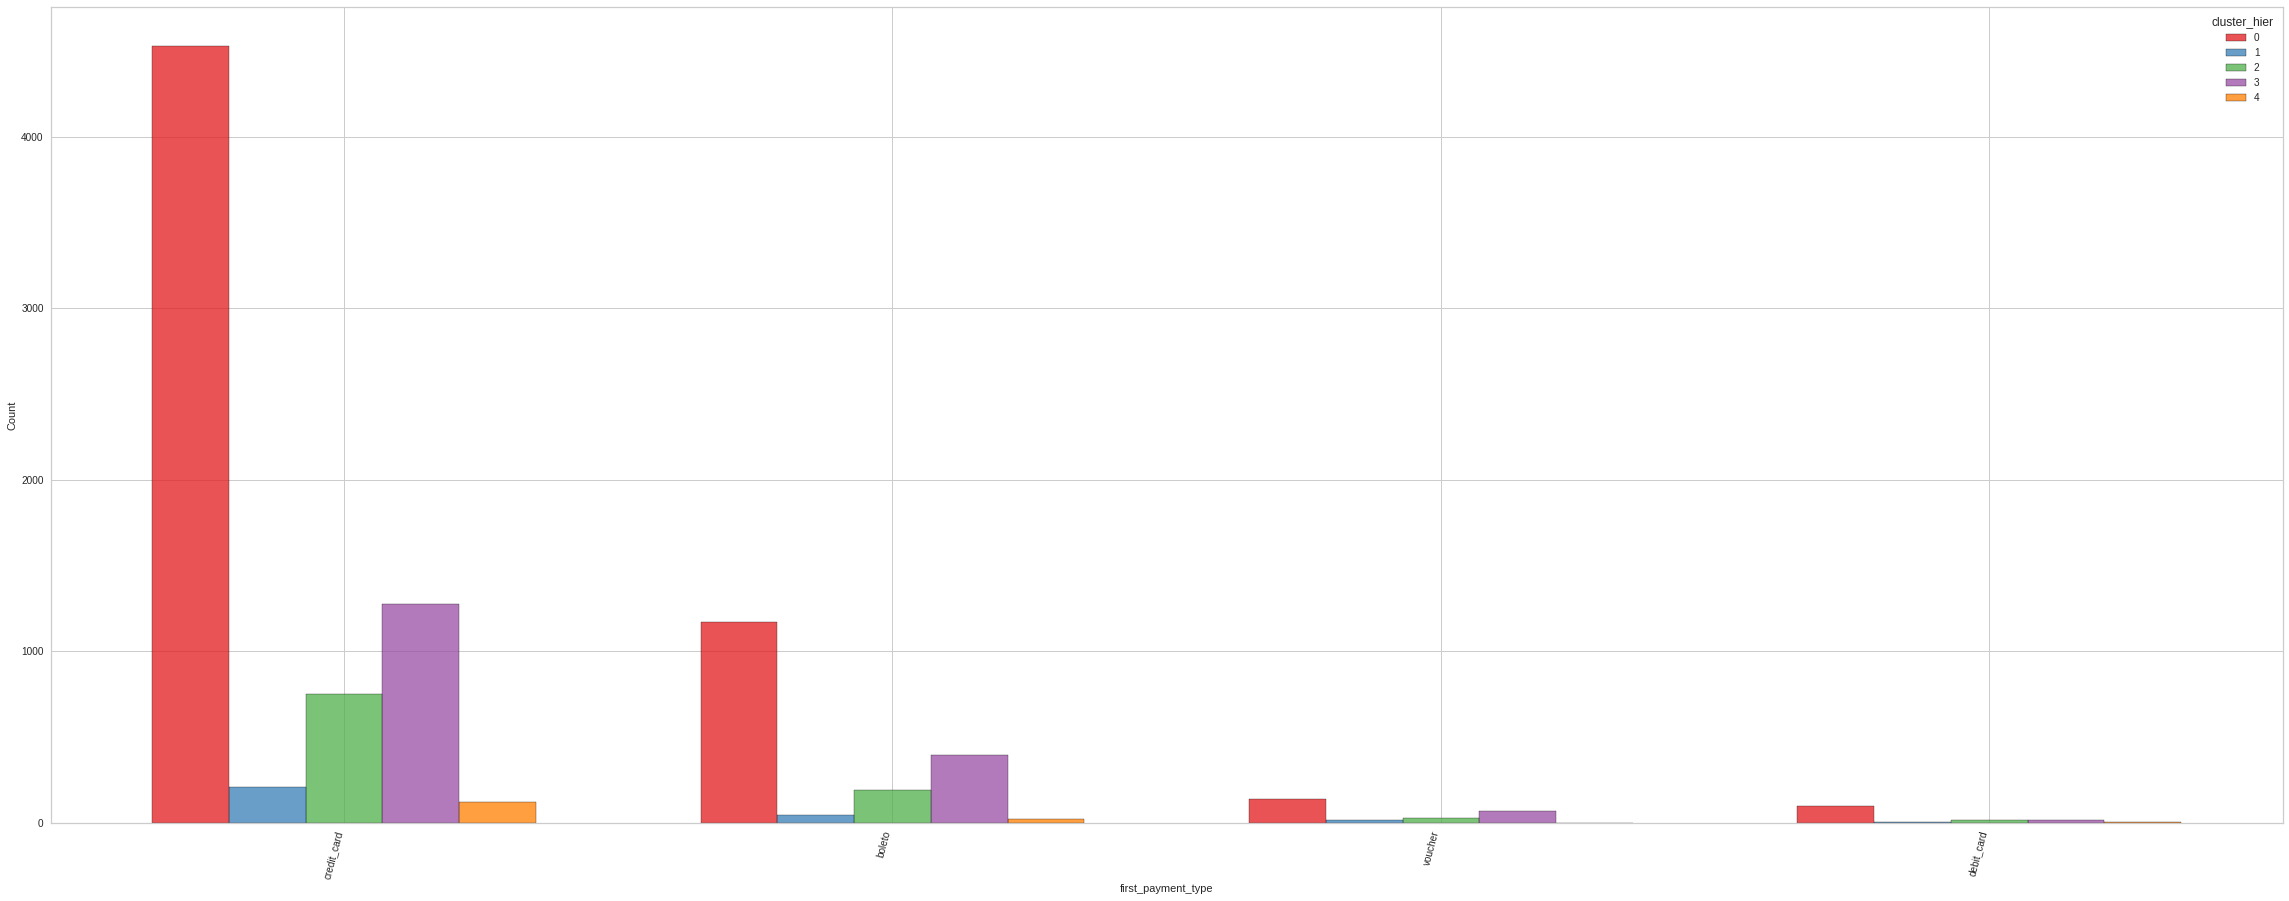

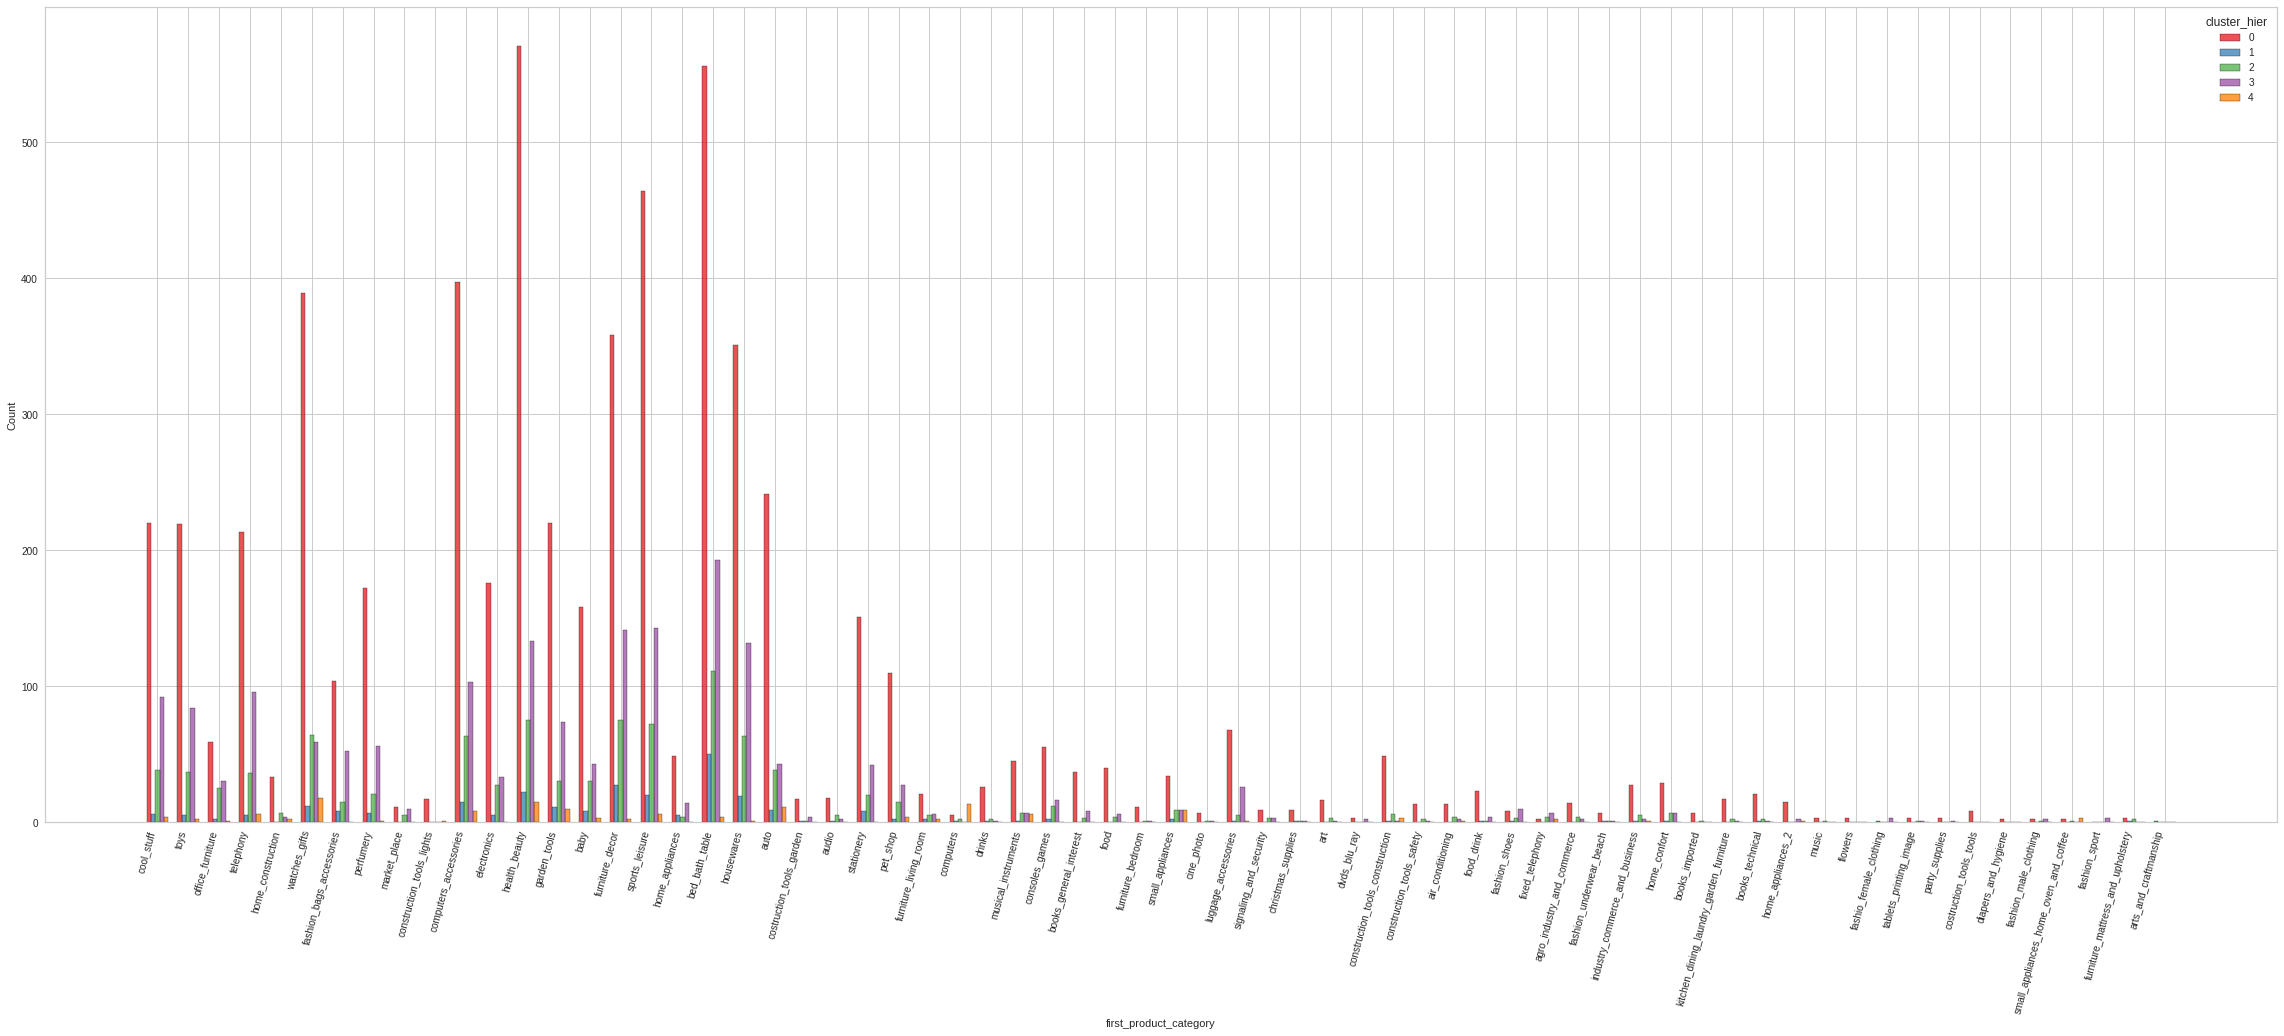

In [37]:
# boxplots par variable et par cluster
for i in cat_var:
    plt.figure(figsize=(40, 15))
    sns.histplot(
        data=df_sample_w_clusters,
        x=i,
        hue="cluster_hier",
        multiple="dodge",
        shrink=0.7,
        palette="Set1",
    )
    plt.xticks(rotation=75, ha="right")
    plt.show()


### Analyse des profils types

Repartition des individus de l'échantillon par cluster:
- **0**:    5278
- **3**:    2196
- **2**:     991
- **1**:     352
- **4**:     259

Profil type des 5 clusters:

- **cluster 4**: contient les acheteurs multiples
- **cluster 3**: contient des individus ayant effectué leur dernier achat il y a plus longtemps
- **cluster 1**: contient les individus ayant des dépenses plus élevées sur la période (idem cluster 0 du KMeans)
- **cluster 2**:contient les individus ayant posté des reviews négatives (toutes les reviews ont une note égale à 1, sauf pour une poignée individus)
- **cluster 0**: n'a aucune particularité

# RFM + reviews + distance + payment installments

Essai de clustering avec deux features supplémentaires:

## KMeans

Les autres types de clustering n'ayant pas apporté satisfaction, je choisi de ne tester que le KMeans avec plus de features et d'abandonner DBscan et clustering agglomératif.

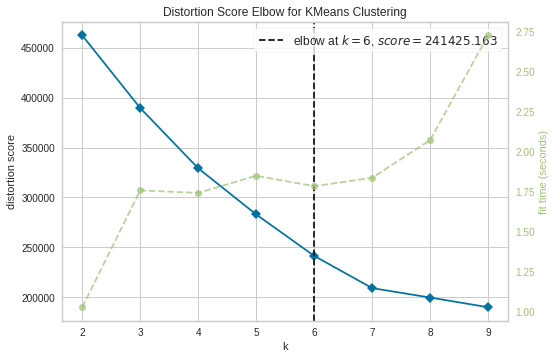

In [38]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data


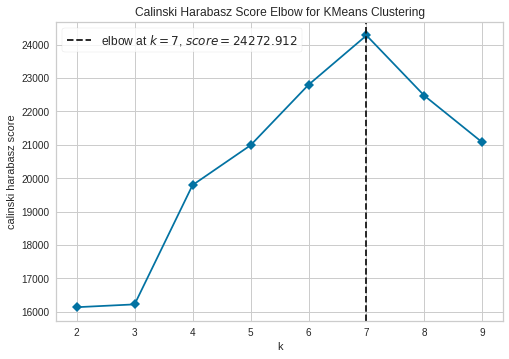

In [39]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 10), metric="calinski_harabasz", timings=False
)

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data


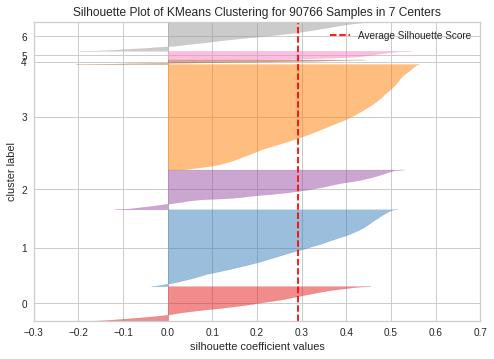

In [40]:
# Instantiate the clustering model and visualizer
model = KMeans(7)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data


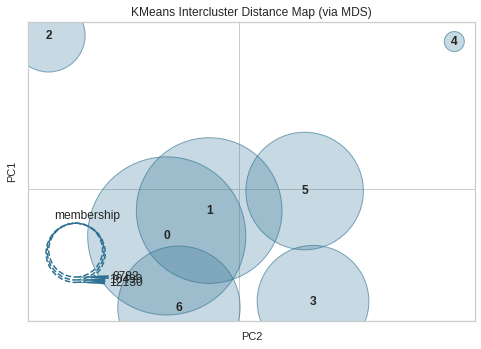

In [41]:
# Inter cluster distance map


# Instantiate the clustering model and visualizer
model = KMeans(7)
visualizer = InterclusterDistance(model)

visualizer.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",
            ]
        ]
    )
)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure


### EDA des clusters

In [42]:
# Choix du modèle dont on explore les clusters
kmeans = KMeans(7)

# fit
kmeans.fit(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",
            ]
        ]
    )
)

# obtention des clusters pour chaque individu
clusters_kmeans = kmeans.fit_predict(
    StandardScaler().fit_transform(
        df_agg[
            [
                "days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",
            ]
        ]
    )
)

# ajout des clusters au DataFrame
df_w_clusters = df_agg.copy()
df_w_clusters["cluster_kmeans"] = clusters_kmeans

# Check
df_w_clusters.head()


,customer_unique_id,last_order,first_order,number_orders,total_amount,average_cart,average_price,average_qty,average_review_score,number_reviews,...,order_different_state,first_payment_type,first_product_category,average_product_name_lenght,average_product_description_lenght,average_review_lenght,average_product_photos_qty,days_since_last_order,review_rate,cluster_kmeans
0,397c24b06740a0578e1e4ef14ab7dc4e,2018-04-13,2018-04-13,1,46.96,46.96,24.90,1.0,5.0,1,...,yes,credit_card,sports_leisure,52.0,1392.0,48.0,1.0,628,1.0,2
1,3cde4b009a25beebc485cf2059ddc991,2018-03-17,2018-03-17,1,38.13,38.13,19.90,1.0,3.0,0,...,yes,boleto,bed_bath_table,52.0,153.0,NaN,1.0,655,0.0,4
2,469356420bccdecae3c5a3f9d8089ddd,2018-02-13,2018-02-13,1,76.17,76.17,59.99,1.0,4.0,0,...,yes,credit_card,bed_bath_table,57.0,504.0,NaN,1.0,687,0.0,2
3,a2353d74607f052ae9640d3af3b81132,2018-02-26,2018-02-26,1,387.14,387.14,369.80,1.0,4.0,0,...,yes,credit_card,watches_gifts,50.0,464.0,NaN,2.0,674,0.0,6
4,99f0c33abddbeb5b72869e0e505453a9,2017-11-25,2017-11-25,1,24.30,24.30,9.20,1.0,5.0,1,...,yes,boleto,auto,60.0,324.0,21.0,1.0,767,1.0,0


In [43]:
# répartition des individus par cluster
df_w_clusters['cluster_kmeans'].value_counts()

2    32029
0    23327
4    12087
6    10514
1     8782
3     2646
5     1381
Name: cluster_kmeans, dtype: int64

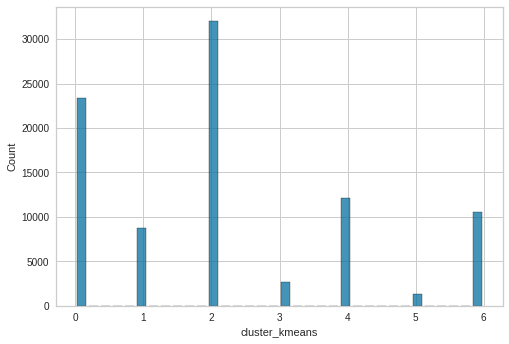

In [44]:
# histograme de la répartition des individus par cluster
sns.histplot(data=df_w_clusters, x="cluster_kmeans", shrink=.8)

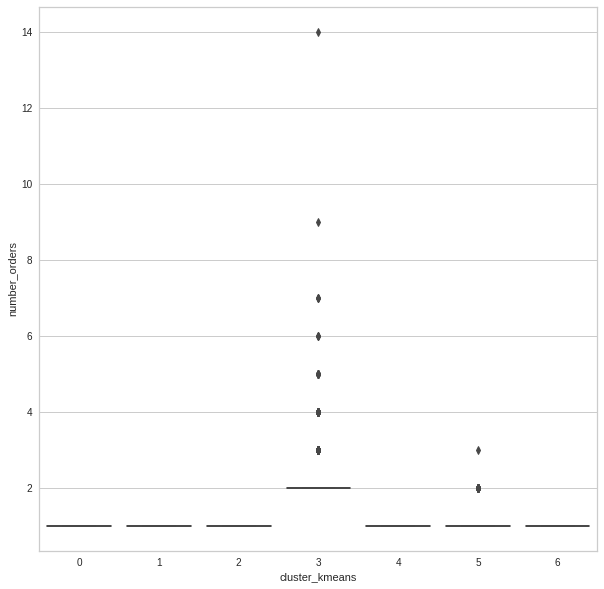

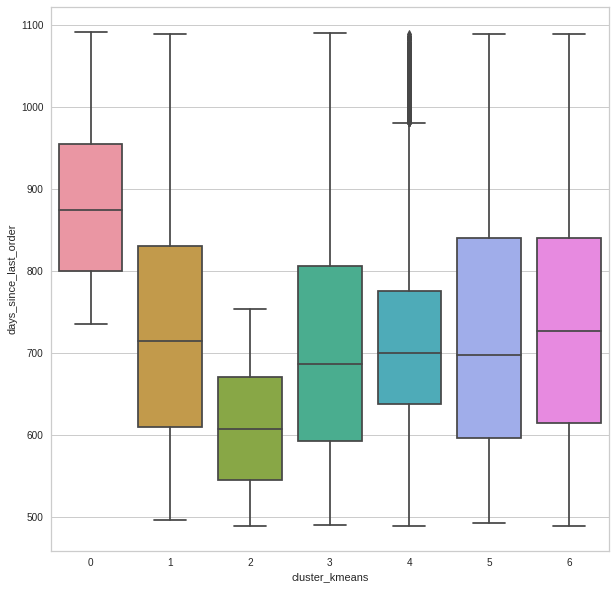

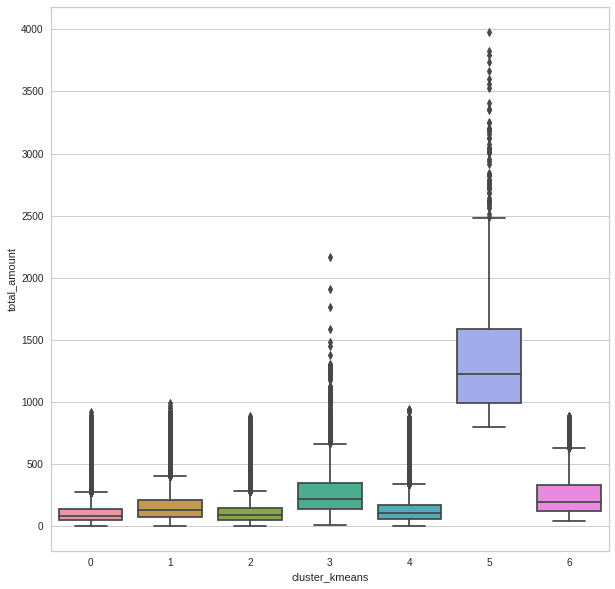

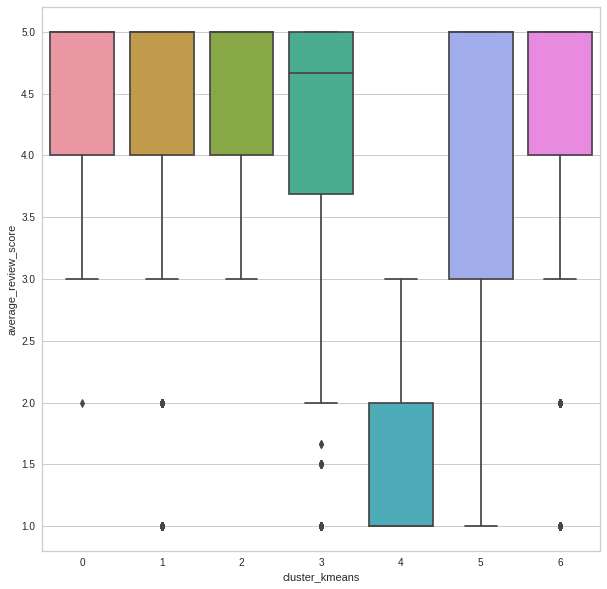

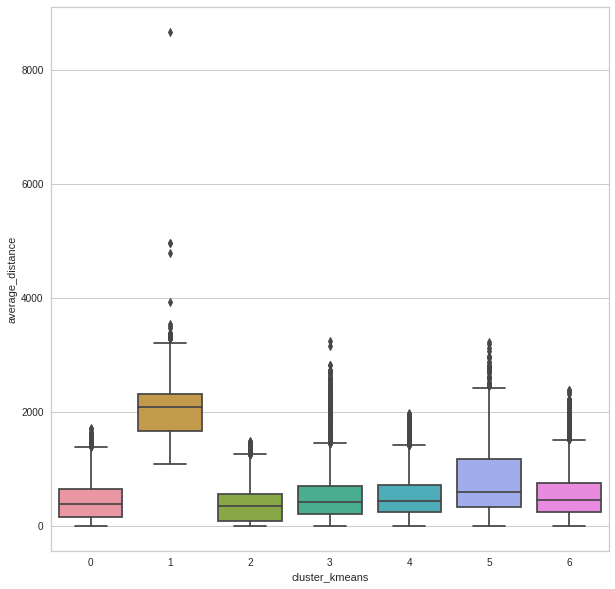

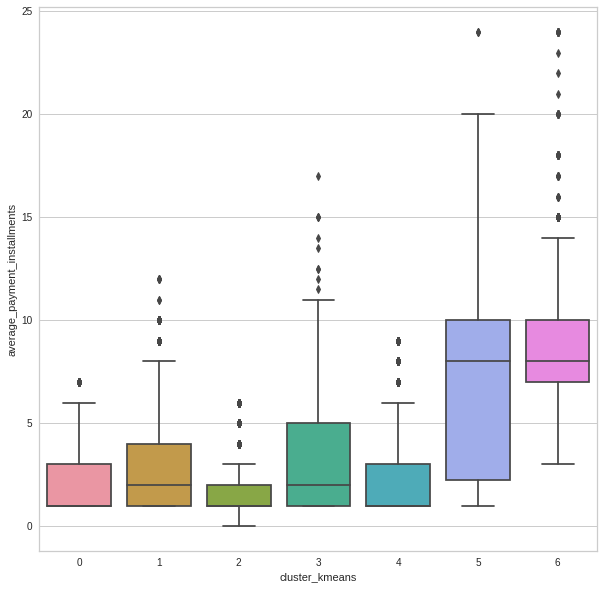

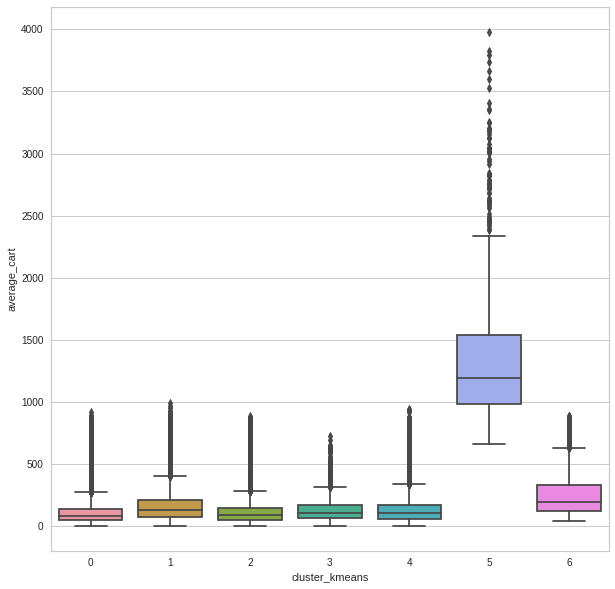

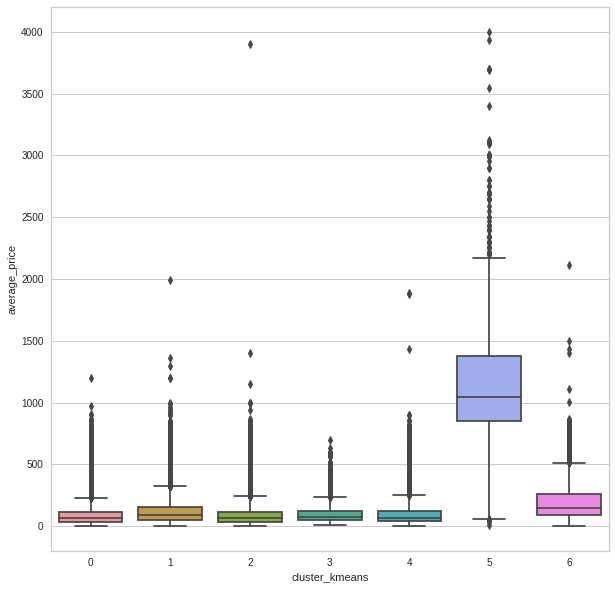

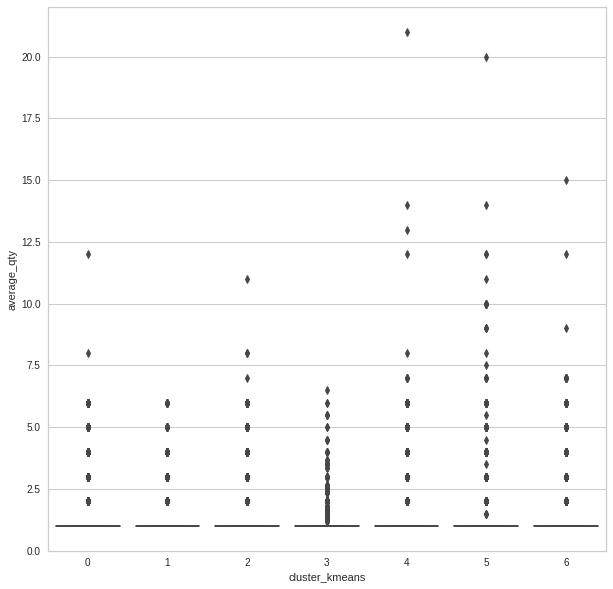

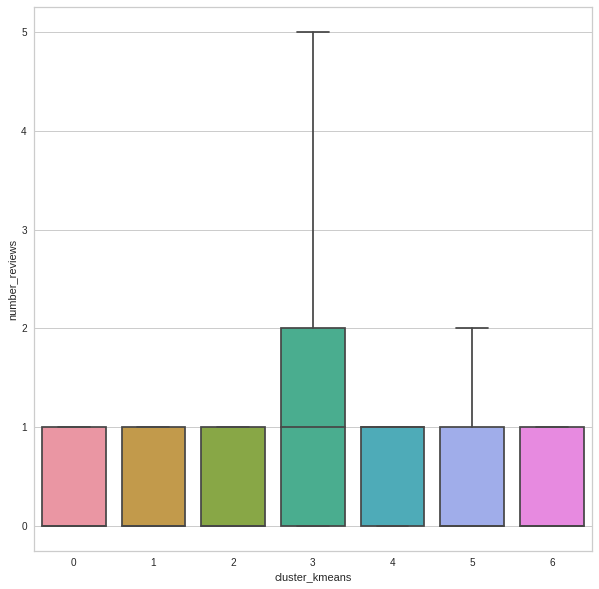

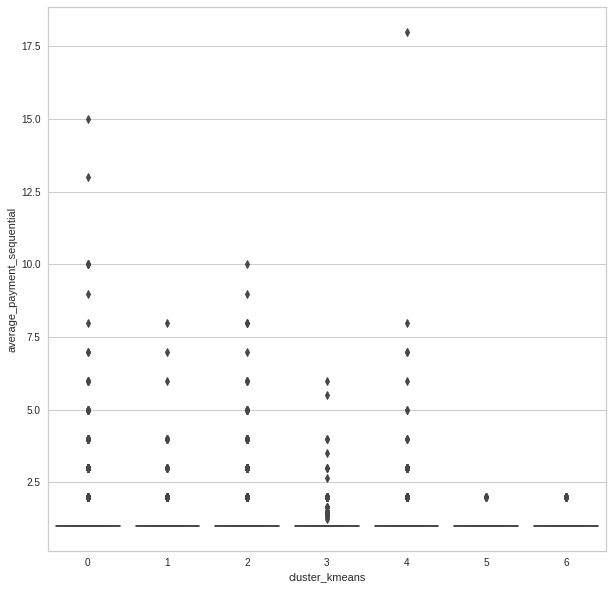

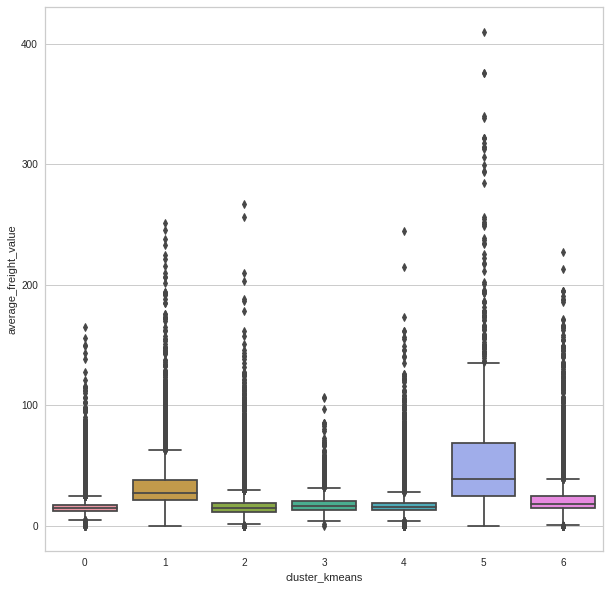

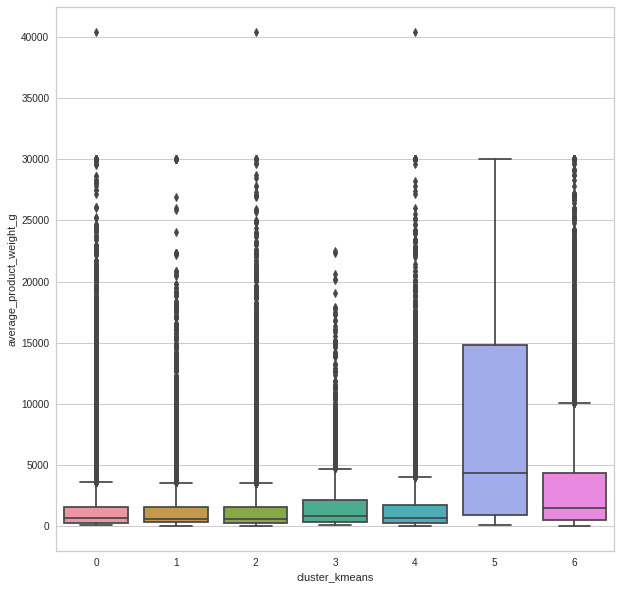

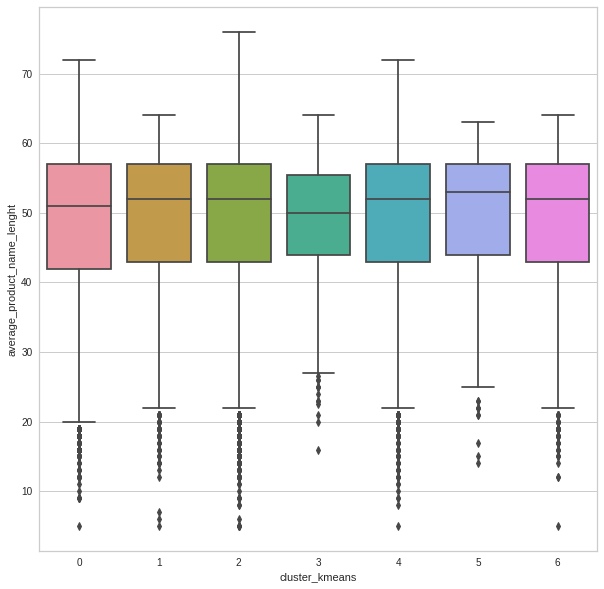

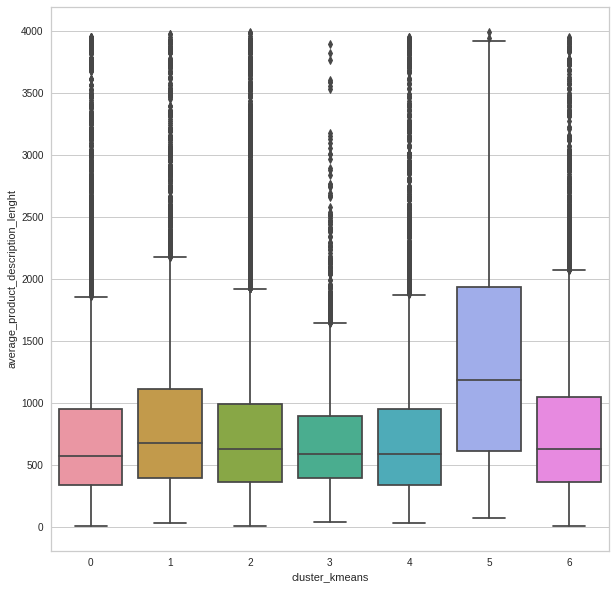

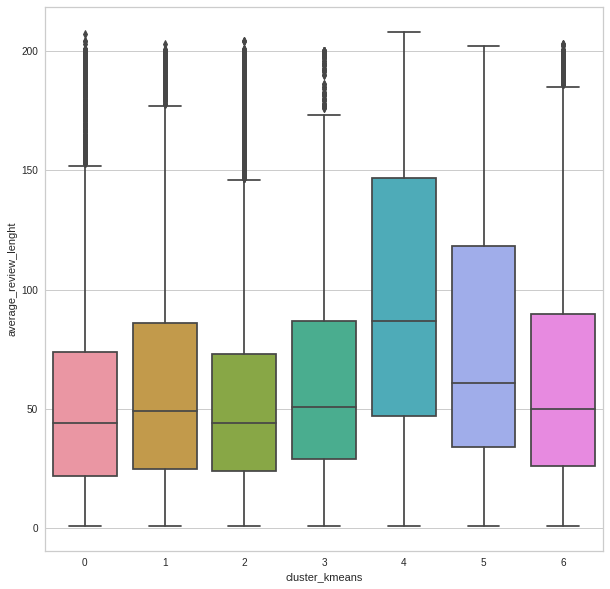

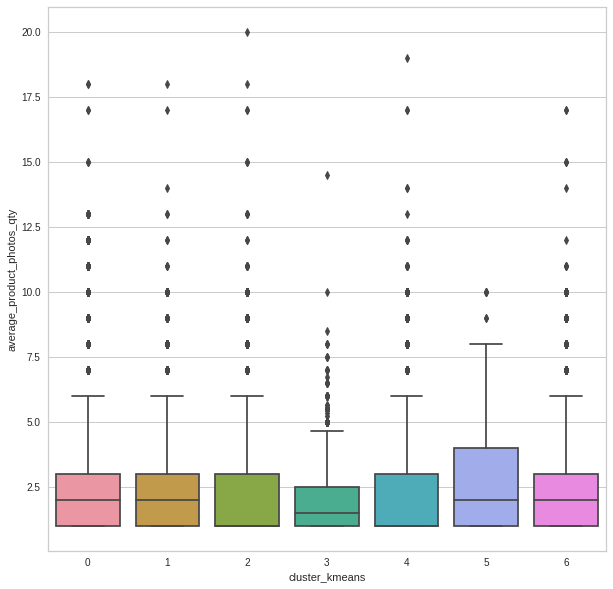

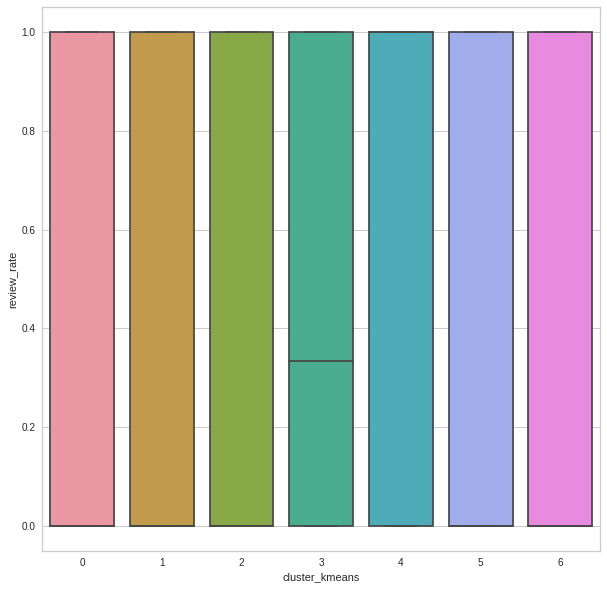

In [45]:
# boxplot par variable et par cluster
for i in quant_var:
    plt.figure(figsize=(10, 10))
    sns.boxplot(
        data=df_w_clusters[df_w_clusters["total_amount"] < 4000],
        x="cluster_kmeans",
        y=i,
    )
    plt.show()


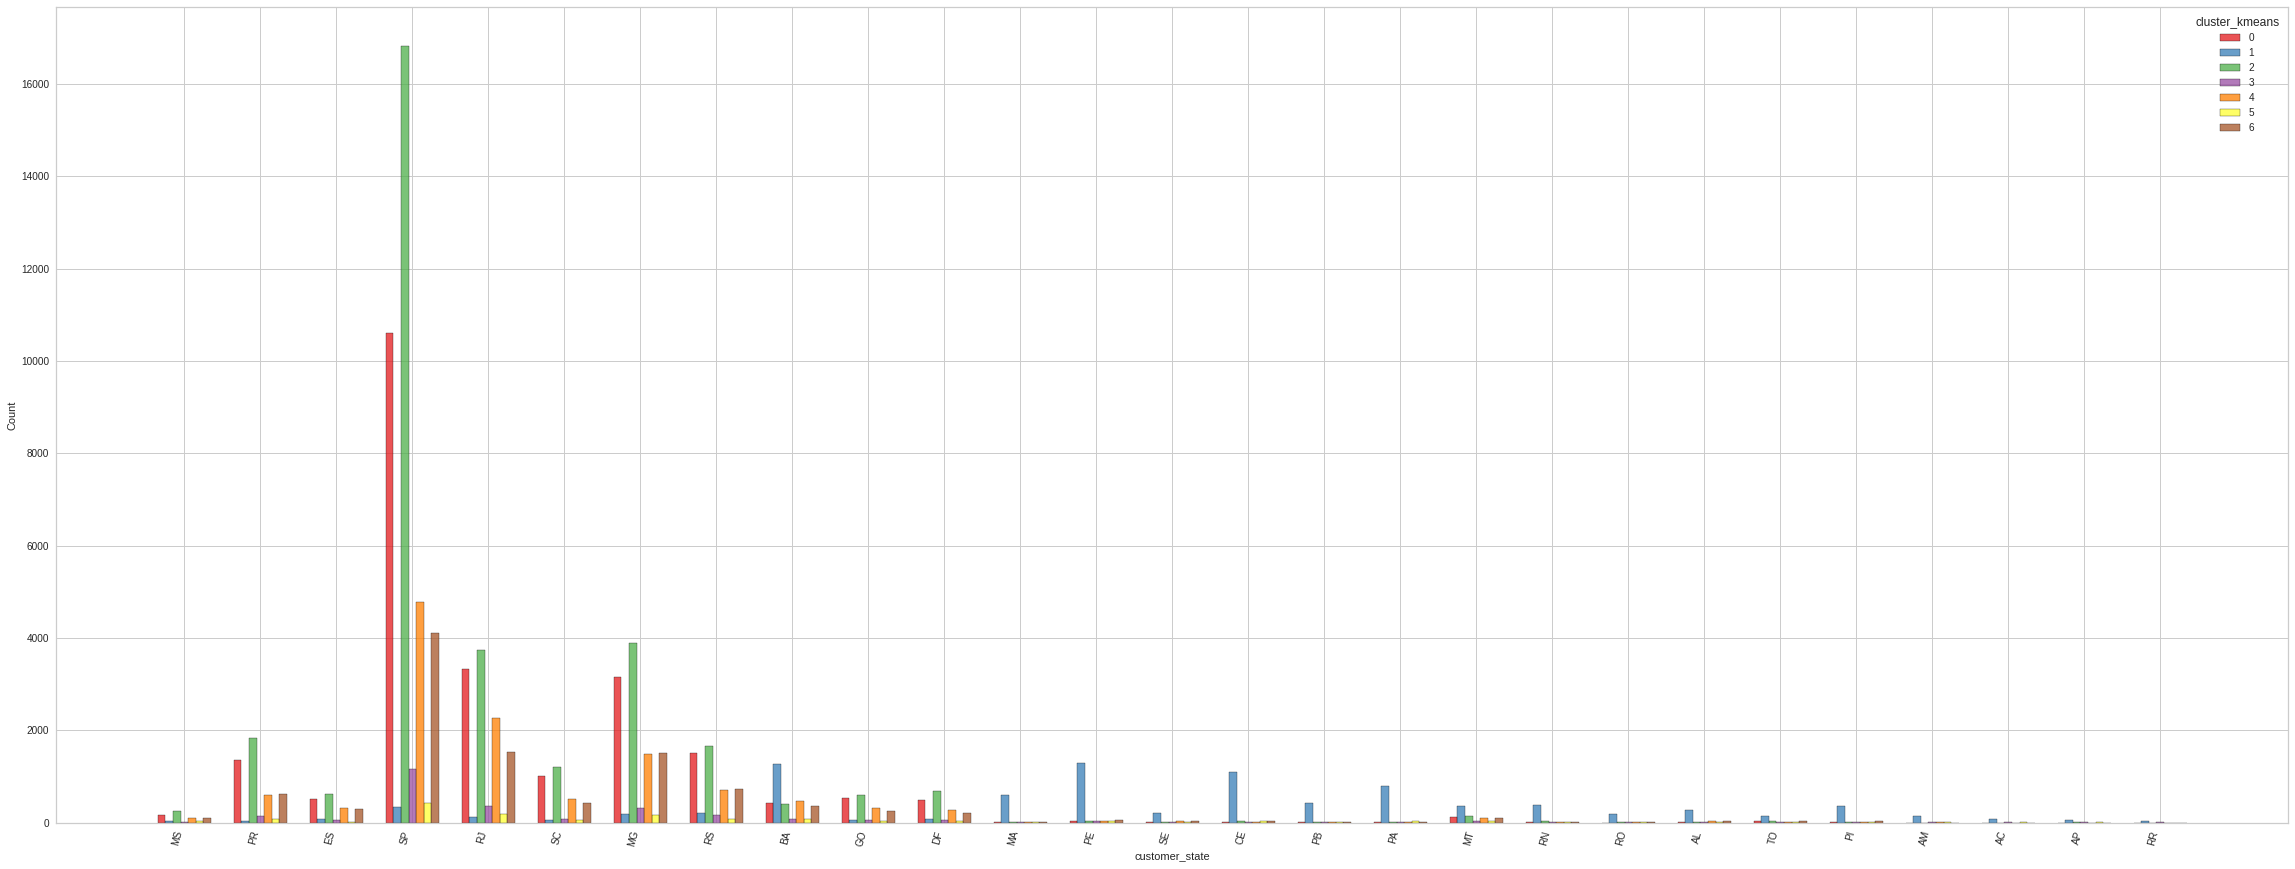

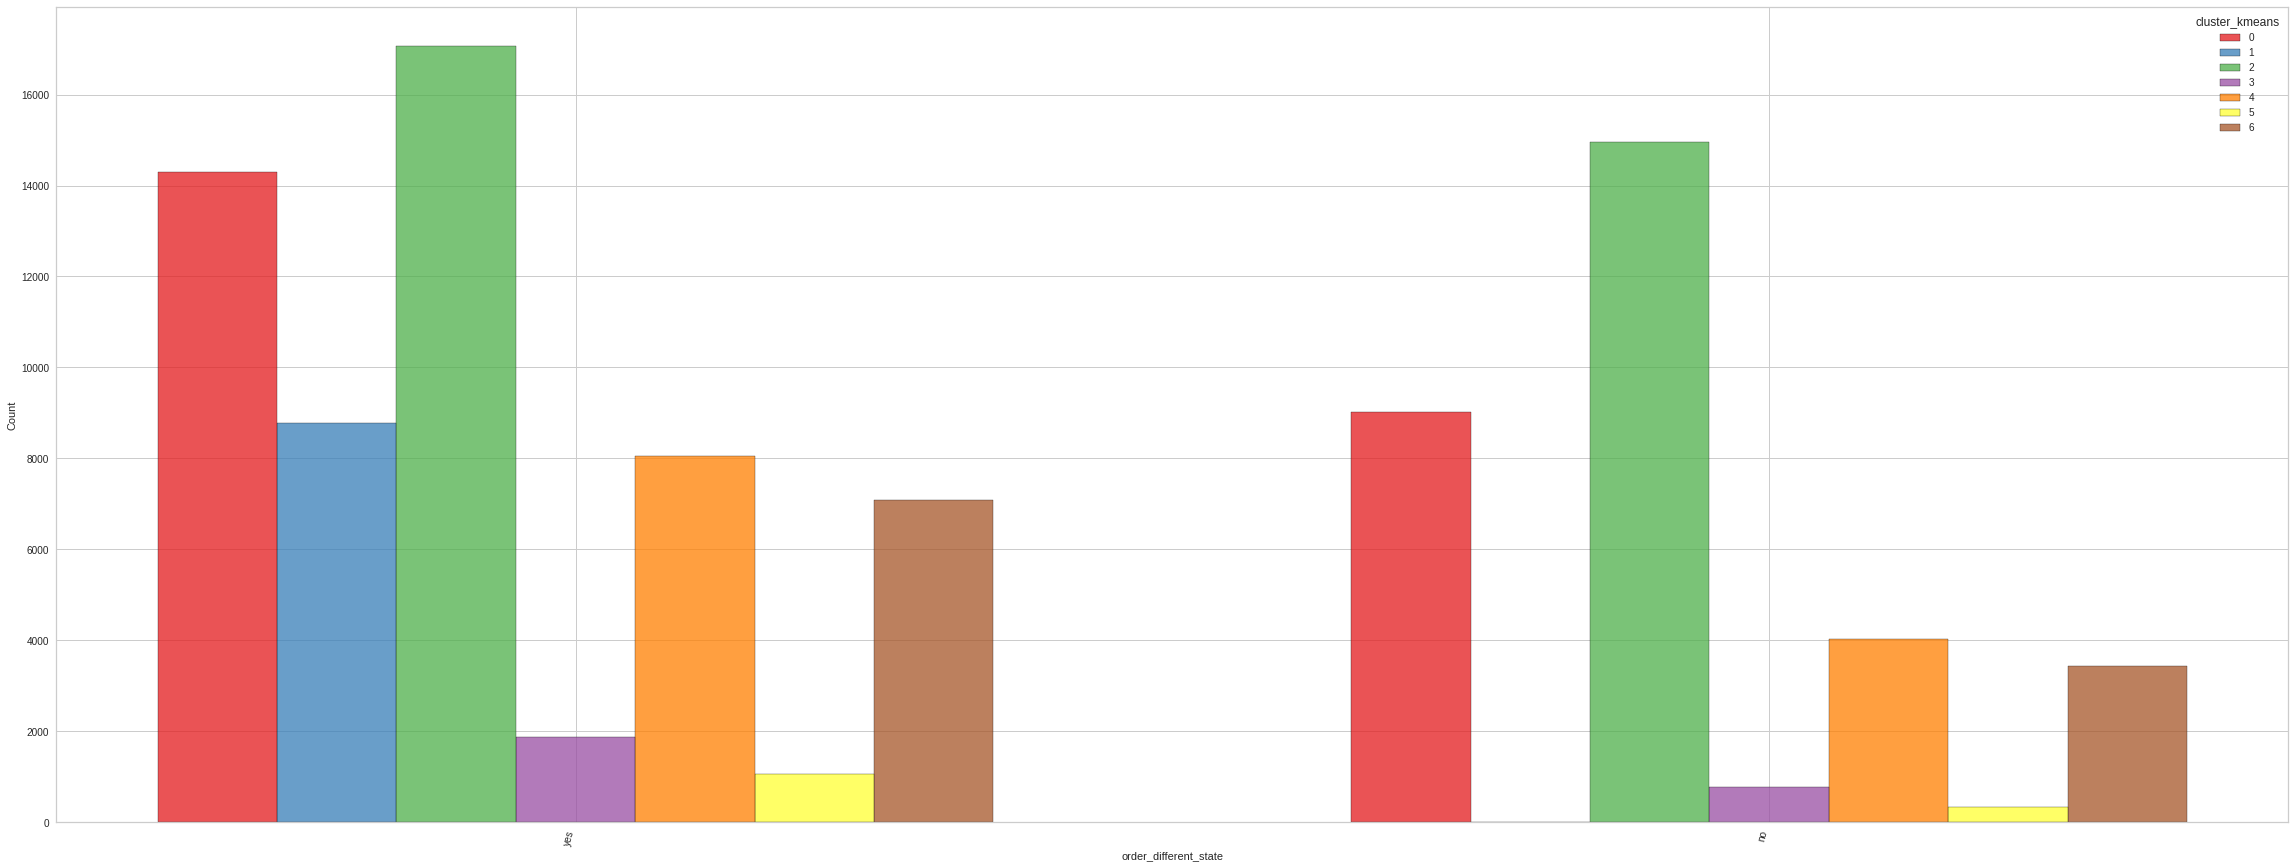

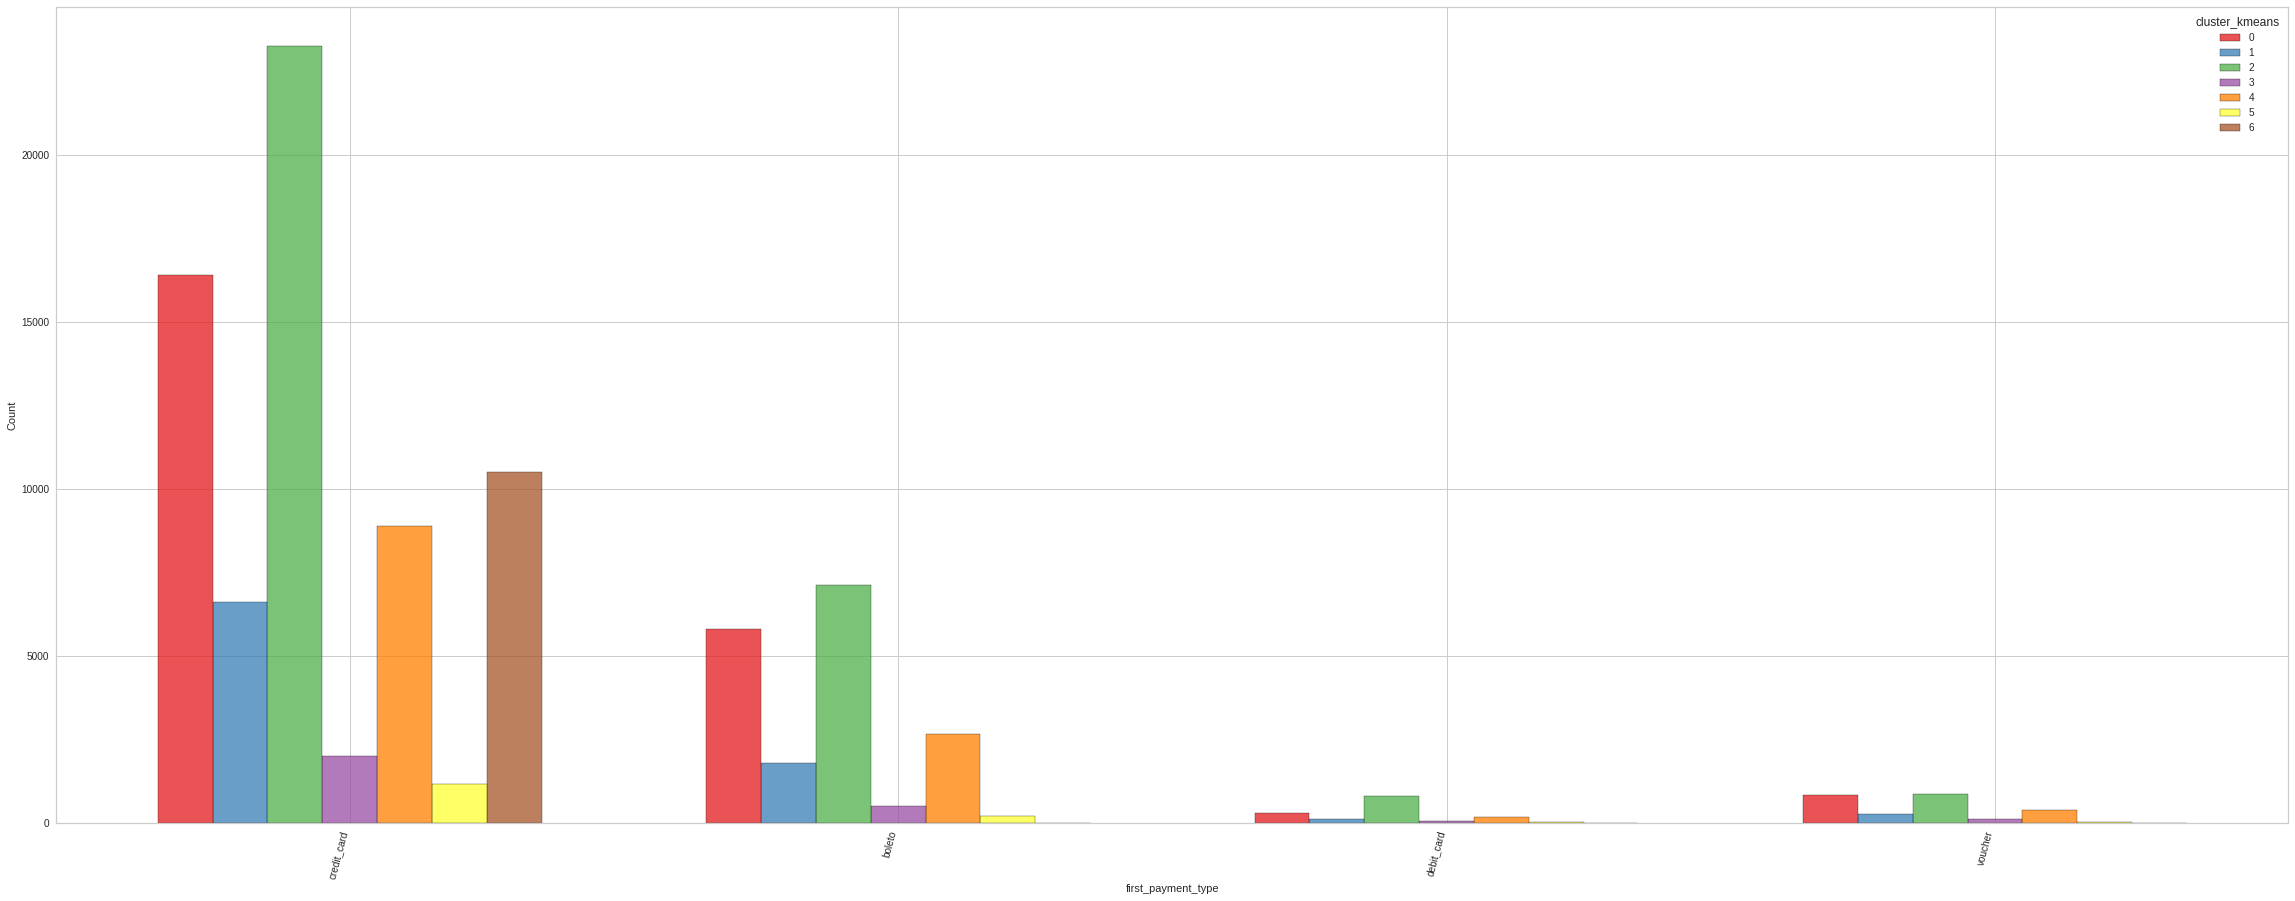

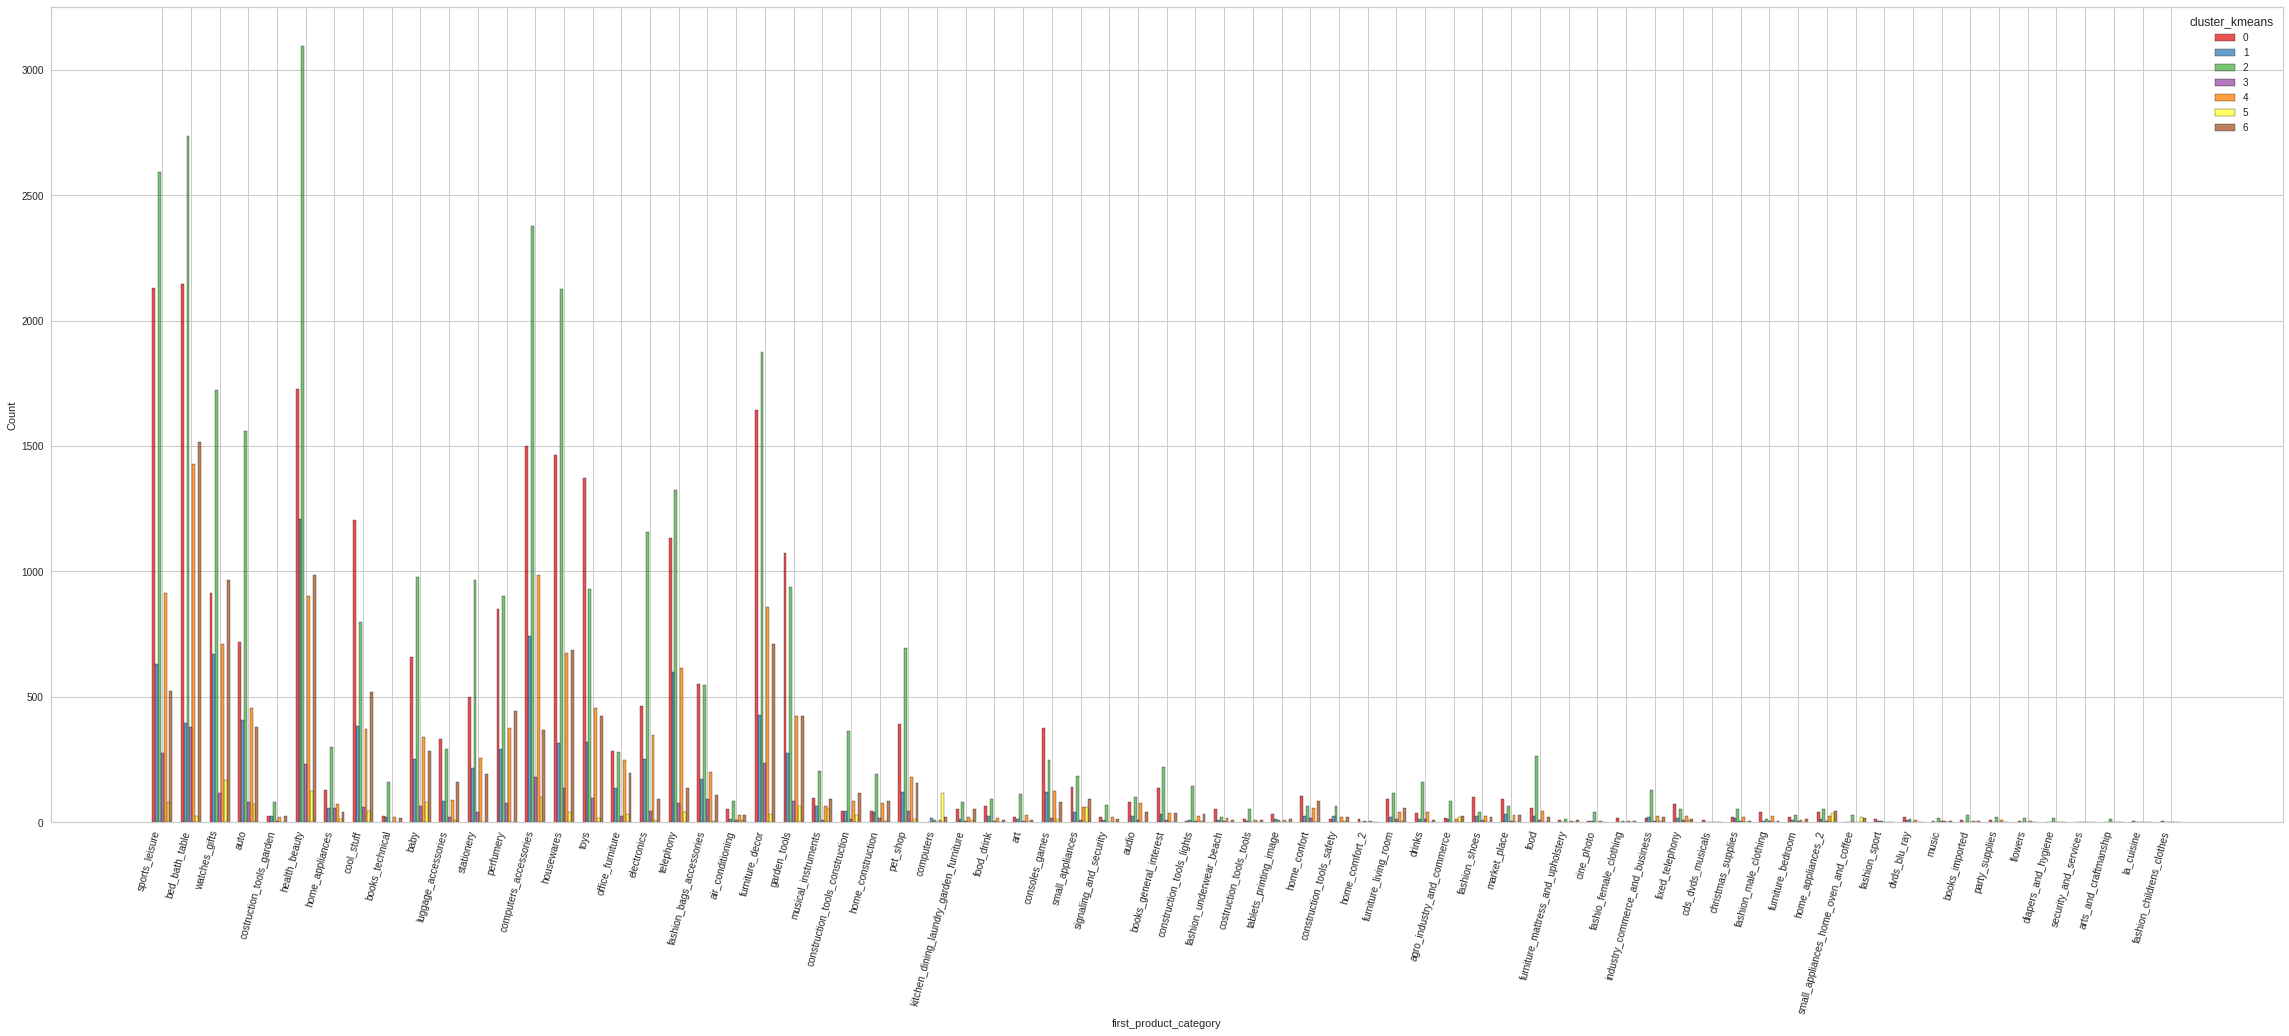

In [46]:
# boxplot par variable et par cluster
for i in cat_var:
    plt.figure(figsize=(40, 15))
    sns.histplot(
        data=df_w_clusters,
        x=i,
        hue="cluster_kmeans",
        multiple="dodge",
        shrink=0.7,
        palette="Set1",
    )
    plt.xticks(rotation=75, ha="right")
    plt.show()


#### ACP

Visualisation des clusters dans un espace réduit via Analyse en Composantes Principales


Le code provient du github OpenClassrooms:    
https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py

Rattaché à ce cours:    
https://openclassrooms.com/fr/courses/5869986-perform-an-exploratory-data-analysis/6172111-analyze-the-results


In [47]:
# constitution du dataset pour l'ACP
df_acp = df_w_clusters[
    [
        "days_since_last_order",
        "number_orders",
        "total_amount",
        "average_review_score",
        "average_distance",
        "average_payment_installments",
    ]
]

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

X = df_acp.values
features = df_acp.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

<Figure size 1080x1080 with 0 Axes>

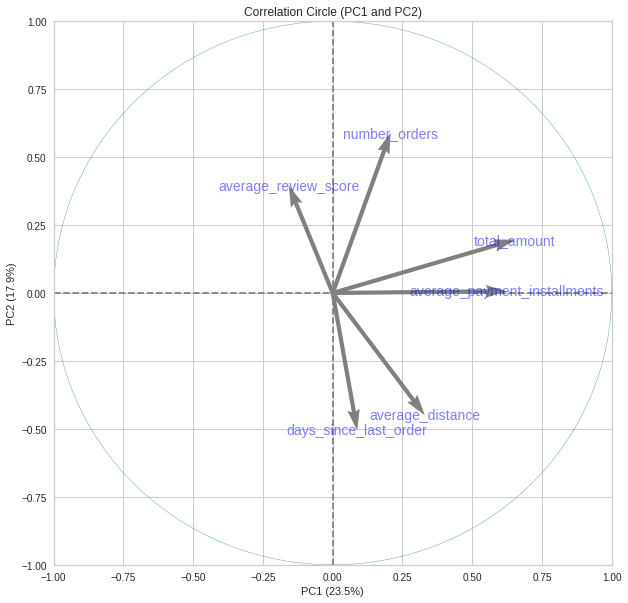

In [48]:
# Cercle des corrélation PC1 x PC2
plt.figure(figsize=(15, 15))
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

<Figure size 1080x1080 with 0 Axes>

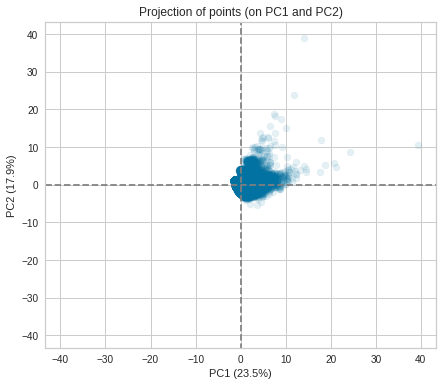

In [49]:
# Projection des points dans le plans PC1 x PC2, colorisés par cluster

# Transform the original scaled data to the new vector space
X_projected = pca.transform(X_scaled) 

# Display a scatter plot of the data points in this new vector space
plt.figure(figsize=(15, 15))
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], alpha = 0.1)
plt.show()

Text(0, 0.5, 'PC2')

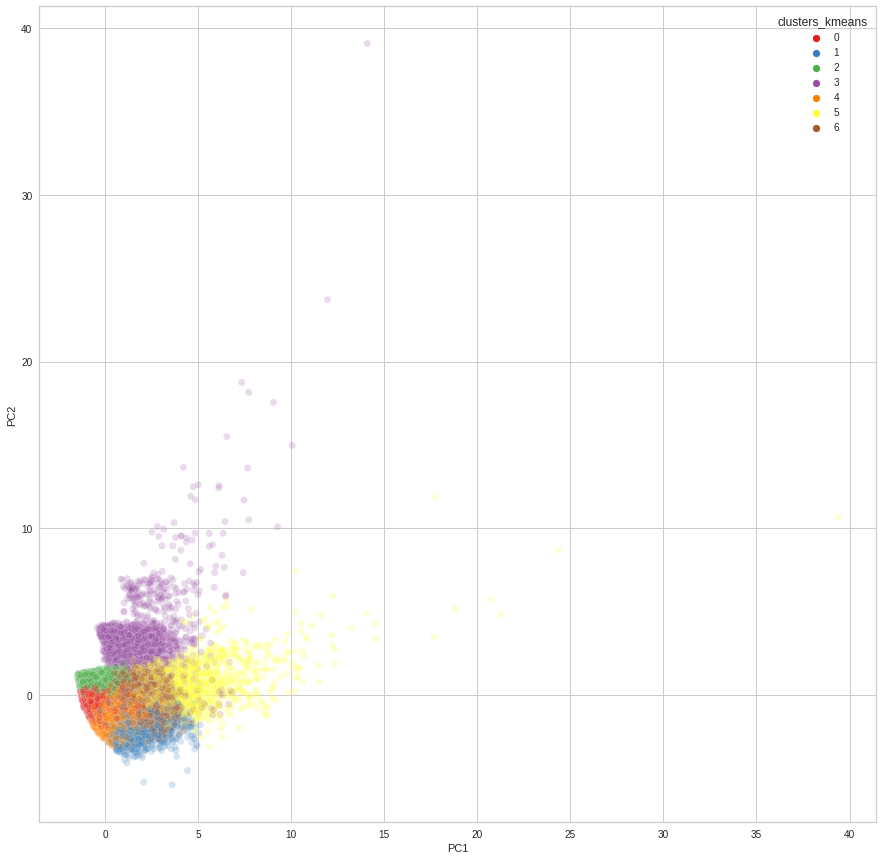

In [50]:
X_p = pd.DataFrame(X_projected)
ck = pd.DataFrame(clusters_kmeans)

X_p['clusters_kmeans'] = ck

# Projection des points dans le plans PC1 x PC2, colorisés par cluster
plt.figure(figsize = (15, 15))
sns.scatterplot(data = X_p,
               x = 0, 
               y = 1,
               hue = "clusters_kmeans",
               palette = "Set1",
               alpha = 0.2)
plt.xlabel("PC1")
plt.ylabel("PC2")

### Analyse des profils types

Nombre d'individus par cluster:
- **4** :   31997
- **1** :   23342
- **2** :   12127
- **6** :   10503
- **0** :    8779
- **5** :    2646
- **3** :    1372


---



Clustering kmeans avec la distance et l'étalement des paiements: 7 clusters

- **cluster 5**: possède tous les individus ayant commandé plusieurs fois (sauf 2 clients), et donc laissant plus de reviews
- **cluster 1**: acheteurs n'ayant pas commandé depuis longtemps
- **cluster 4**: acheteurs plus récents en moyenne
- **cluster 3**: clients ayant dépensé beaucoup (idem OG cluster 0), avec plus d'étalement des payements, et des reviews légèrement plus longues
- **cluster 2**: clients ayant laisser des reviews négatives et en moyennes plus longues
- **cluster 0**: clients ayant acheté à des vendeurs plus éloignés
- **cluster 6**: clients étalant leurs paiements et ayant des dépense "normales"



---


**L'ajout des features de distance vendeur/acheteur et d'étalement des payement permet de capturer les singularités des individus les concernant.**

**Cela se fait au détriment de la segmentation RFM: la séparation des clusters en terme de depense totale sur la periode est moins nette.**

# Choix final de l'algorithme et des features: KMeans sur features RFM et note de review moyenne

**Le Kmeans avec les features RFM et les notes des reviews donne les clusters les plus définis et intéressants d'un point de vue métier**, sur un set de variables données. 

Il est également plus rapide à entrainer et simple à mettre en production. 

Plus d'outils pour évaluer la qualité du clustering sont disponibles en Open Source, comparé aux autres algorithmes.


---


Le DBscan ne fait pas ressortir de clusters exploitables d'un point de vue métier.

De plus certains individus n'ont pas de clusters attribués avec cette methode. Il est d'autant plus problématique qu'il s'agit très probablement de clients important en terme de chiffre d'affaire.


---



Le clustering agglomératif est lourd à calculer en terme de ressources, et par conséquent nécessite d'être calculé sur un échantillon restreint. 
De plus, il n'existe pas de manière robuste de choisir le nombre de clusters.
Certains individus sont dans un cluster "moyen" ne présentant aucune caractéristique particulière.


---


**Le Kmeans avec plus de features brouille partiellement la séparation des clusters en terme de dépense sur la période**. 

Je considère qu'il s'agit d'une feature essentielle d'un point de vue métier (ciblage de campagnes marketing). 

En effet, il s'agit d'une des caractéristiques d'une segmentation clients RFM classiquer (Montant), dont les équipes conaissent généralement les implications en terme d'actions marketing à mener. 



---



---


**Pour les raisons évoquées ci-dessus, et afin de déterminer la fréquence de mise à jour du modèle dans la suite du projet :**

***--> je choisi de me concentrer sur un clustering KMeans à 5 clusters, entrainé sur les 3 features d'une segmentation RFM classique ainsi que sur la note moyenne laissé par l'individu.***



La methode et le code du prochain notebook seront facilement adaptables à un KMeans avec d'autres variables et d'autres hyperparamètres, ainsi qu'à d'autres algorithmes de clustering (model agnostic). Je vais également
